In [1]:
import os
import time
import itertools
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm
import plotly
import matplotlib.pyplot as plt

import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
import optuna
from sklearn.model_selection import train_test_split, KFold
import skopt
import skopt.plots

from Dataset_Construction import Balance_Ratio 
from Sampling import label_divide
from AdaClassifier import train_set, multiple_set, print_badC, bad_plot, line_chart, cf_matrix
from AdaRegressor import AUC, PR_curve, multiple_curve, PR_matrix, best_threshold 
from Aging_Score import score1
from XGBoost import optuna_history, all_optuna

os.chdir('C:/Users/user/Desktop/Darui_R08621110')  
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

### Boosting model

In [2]:
def LightGBMC(train_x, test_x, train_y, test_y, config):
    
    clf = LGBMClassifier(**config)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result


def LightGBMR(train_x, test_x, train_y, test_y, config):
    
    reg = LGBMRegressor(**config)
    reg.fit(train_x, train_y)
    predict_y = reg.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result

### Run all dataset

In [3]:
def runall_LightGBMC(num_set, trainset_x, test_x, trainset_y, test_y, config, record_bad = True):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config
        
        result = LightGBMC(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)
        table = cf_matrix(result, trainset_y[f'set{i}'])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})
        
        if record_bad:
            bad_table = print_badC(result, test_x, Bad_Types) 
            bad_set = pd.concat([bad_set, bad_table]).rename(index = {0: f'dataset {i}'})

    if record_bad:
        return table_set, bad_set
    else:
        return table_set
    
    
def runall_LightGBMR(num_set, trainset_x, test_x, trainset_y, test_y, config, thres_target = 'Recall', threshold = 0.8, 
                     record_bad = True):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config

        predict = LightGBMR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})
        
        if record_bad:
            bad_table = print_badC(predict, test_x, Bad_Types, threshold = best_thres)
            bad_set = pd.concat([bad_set, bad_table]).rename(index = {0: f'dataset {i}'})
    
    if record_bad:
        return pr_dict, table_set, bad_set
    else:
        return pr_dict, table_set

## Data Processing

In [4]:
###bad types###
bad = pd.read_csv('event/Bad_Types.csv').iloc[:, 1:]
Bad_Types = {bad.cb[i]:i for i in range (len(bad))}
print('Total bad types:', len(bad))

###single dataset###
test = pd.read_csv('event/TestingSet_0.csv').iloc[:, 2:]
train = pd.read_csv('event/TrainingSet_new.csv').iloc[:, 2:]
print('\ntraining data:', train.shape, '\nBalance Ratio:', Balance_Ratio(train))
print('\ntesting data:', test.shape, '\nBalance Ratio:', Balance_Ratio(test))

train_x, train_y, test_x, test_y = label_divide(train, test, 'GB')

###multiple dataset###
data_dict = multiple_set(num_set = 10)
trainset_x, trainset_y = train_set(data_dict, num_set = 10, label = 'GB')
test_x, test_y = label_divide(test, None, 'GB', train_only = True)


#####for runhist dataset#####
# bad = pd.read_csv('run_bad_types.csv').iloc[:, 1:]
# Bad_Types = {bad.cb[i]:i for i in range (len(bad))}
# print('Total bad types:', len(bad))

run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of run test:', run_test.shape)

Total bad types: 62

training data: (77138, 83) 
Balance Ratio: 18.17902

testing data: (55903, 83) 
Balance Ratio: 3104.72222
Dimension of dataset 0 : (80518, 141)  balance ratio: 1101.9863
Dimension of dataset 1 : (1634, 141)  balance ratio: 1.0
Dimension of dataset 2 : (1496, 141)  balance ratio: 1.0
Dimension of dataset 3 : (1752, 141)  balance ratio: 1.0
Dimension of dataset 4 : (1608, 141)  balance ratio: 1.0
Dimension of dataset 5 : (1551, 141)  balance ratio: 0.99101
Dimension of dataset 6 : (1528, 141)  balance ratio: 1.05376
Dimension of dataset 7 : (1510, 141)  balance ratio: 1.0
Dimension of dataset 8 : (1526, 141)  balance ratio: 1.0
Dimension of dataset 9 : (831, 141)  balance ratio: 10.38356

 10 datasets are loaded.

Labels of  10 datasets are divided.

 Dimension of run test: (47725, 141)


### Classifier


 Dataset 0:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0015295966474594028

 Dataset 1:
Precision: 0.0006783164830905391 
Recall: 0.6176470588235294 
Aging Rate: 0.648695652173913

 Dataset 2:
Precision: 0.0006176270767710456 
Recall: 0.5882352941176471 
Aging Rate: 0.6785123101100052

 Dataset 3:
Precision: 0.0007081241148448565 
Recall: 0.6470588235294118 
Aging Rate: 0.650979570455736

 Dataset 4:
Precision: 0.0008576035127439882 
Recall: 0.7352941176470589 
Aging Rate: 0.6108119434258774

 Dataset 5:
Precision: 0.0006340962618515611 
Recall: 0.6176470588235294 
Aging Rate: 0.6939339968569932

 Dataset 6:
Precision: 0.0007135721421435707 
Recall: 0.7352941176470589 
Aging Rate: 0.7341016238868517

 Dataset 7:
Precision: 0.0006890287826114191 
Recall: 0.6470588235294118 
Aging Rate: 0.669020429544264

 Dataset 8:
Precision: 0.0006532049643577291 
Recall: 0.6764705882352942 
Aging Rate: 0.7377894185437401

 Dataset 9:
Precision: 0.0006774070037993698 
Recall: 0.6764705882352942 
Agin

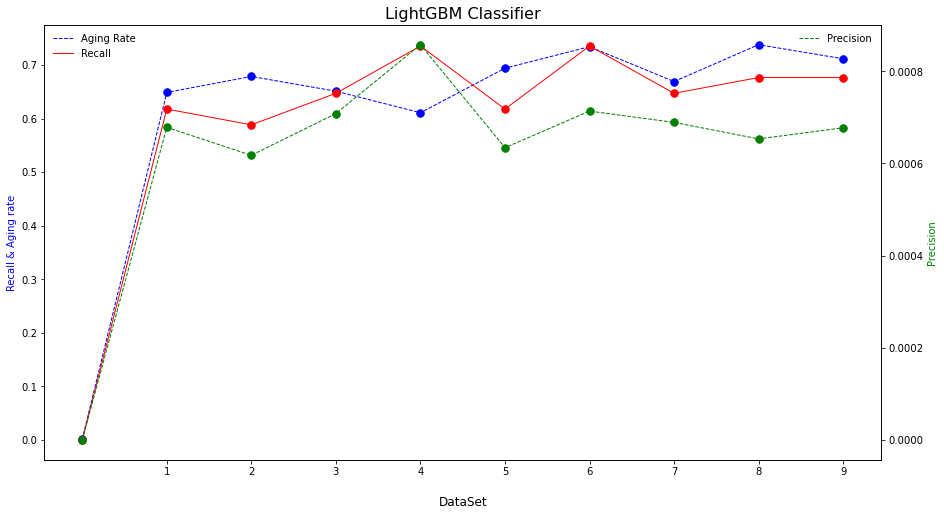

In [8]:
# run_clf_param = {
#         'objective': 'binary',
#         'metric': 'binary_logloss',
#         'boosting_type': 'goss',
#         'num_iterations': 100,
#         'subsample': 0.7,
#         'num_leaves': 20,
#         'min_child_samples': 3,
#         'max_depth': 7,
#         'learning_rate': 0.125,
#         'lambda_l1': 0.0006,

#         'lambda_l2': 0.003
# } #tpe/recall-0.1*aging/set6

#table_setC, bad_setC = runall_LightGBMC(9, trainset_x, test_x, trainset_y, test_y, event_clf_param)
table_setC = runall_LightGBMC(10, trainset_x, run_test_x, trainset_y, run_test_y, best_paramC, record_bad = False)
line_chart(table_setC, title = 'LightGBM Classifier')
#bad_plot(bad_setC)

In [9]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,1101.986301,80445.0,73.0,0.0,73.0,34.0,47618.0,0.000000,0.000000,0.001530,0.000000,0.000000
dataset 1,1.000000,817.0,817.0,21.0,30938.0,13.0,16753.0,0.000678,0.617647,0.648696,0.952137,0.000000
dataset 2,1.000000,748.0,748.0,20.0,32362.0,14.0,15329.0,0.000618,0.588235,0.678512,0.866949,0.000000
dataset 3,1.000000,876.0,876.0,22.0,31046.0,12.0,16645.0,0.000708,0.647059,0.650980,0.993977,0.000000
dataset 4,1.000000,804.0,804.0,25.0,29126.0,9.0,18565.0,0.000858,0.735294,0.610812,1.203798,0.581016
dataset 5,0.991014,772.0,779.0,21.0,33097.0,13.0,14594.0,0.000634,0.617647,0.693934,0.890066,0.000000
dataset 6,1.053763,784.0,744.0,25.0,35010.0,9.0,12681.0,0.000714,0.735294,0.734102,1.001624,0.510264
dataset 7,1.000000,755.0,755.0,22.0,31907.0,12.0,15784.0,0.000689,0.647059,0.669020,0.967173,0.000000
dataset 8,1.000000,763.0,763.0,23.0,35188.0,11.0,12503.0,0.000653,0.676471,0.737789,0.916888,0.000000
dataset 9,10.383562,758.0,73.0,23.0,33930.0,11.0,13761.0,0.000677,0.676471,0.711430,0.950860,0.000000


### Regressor


 Dataset 0:
Best Threshold: 1.1761761202422241e-07 

Recall: [0.70588235] ,   Precision: [0.00068435] ,   Aging Rate: [0.73483499]

 Dataset 1:
Best Threshold: 0.2650568617539551 

Recall: [0.70588235] ,   Precision: [0.00067619] ,   Aging Rate: [0.74369827]

 Dataset 2:
Best Threshold: 0.33113321759125863 

Recall: [0.70588235] ,   Precision: [0.00066862] ,   Aging Rate: [0.75212153]

 Dataset 3:
Best Threshold: 0.4329051580613822 

Recall: [0.70588235] ,   Precision: [0.00076159] ,   Aging Rate: [0.66030382]

 Dataset 4:
Best Threshold: 0.542367881198021 

Recall: [0.70588235] ,   Precision: [0.00089996] ,   Aging Rate: [0.5587847]

 Dataset 5:
Best Threshold: 0.27553572809687477 

Recall: [0.70588235] ,   Precision: [0.00064669] ,   Aging Rate: [0.77762179]

 Dataset 6:
Best Threshold: 0.6567863923178306 

Recall: [0.70588235] ,   Precision: [0.00071657] ,   Aging Rate: [0.70179151]

 Dataset 7:
Best Threshold: 0.3243813559940339 

Recall: [0.70588235] ,   Precision: [0.00070381] ,

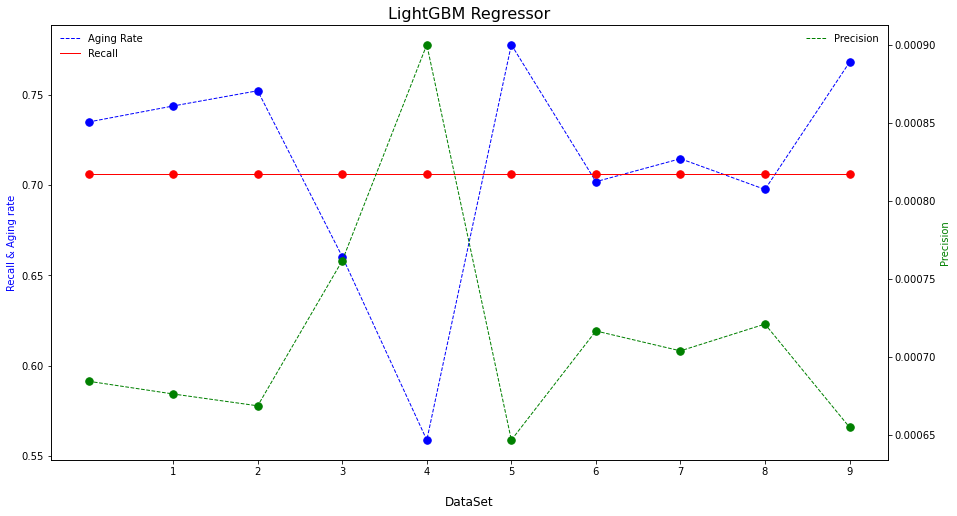

In [10]:
# run_reg_param = {
#         'objective': 'binary',
#         'metric': 'binary_logloss',
#         'boosting_type': 'gbdt',
#         'num_iterations': 150,
#         'subsample': 0.9,
#         'num_leaves': 20,
#         'min_child_samples': 9,
#         'max_depth': 5,
#         'learning_rate': 0.475,
#         'lambda_l1': 0.0003,
#         'lambda_l2': 0.0006
# }

# pr_dict, table_setR, bad_setR = runall_LightGBMR(9, trainset_x, test_x, trainset_y, test_y, event_reg_param, 
#                                                  thres_target = 'Recall', threshold = 0.8)
pr_dict, table_setR = runall_LightGBMR(10, trainset_x, run_test_x, trainset_y, run_test_y, best_paramR, 
                                       thres_target = 'Recall', threshold = 0.7, record_bad = False)
line_chart(table_setR, title = 'LightGBM Regressor')
#bad_plot(bad_setR)

,Class_Prob,train_OK,train_NG,Balance Ratio,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,1.176176e-07,80445.0,73.0,1101.986301,24.0,35046.0,10.0,12645.0,0.000684,0.705882,0.734835,0.960600,0.000000
dataset 1,2.650569e-01,817.0,817.0,1.000000,24.0,35469.0,10.0,12222.0,0.000676,0.705882,0.743698,0.949152,0.000000
dataset 2,3.311332e-01,748.0,748.0,1.000000,24.0,35871.0,10.0,11820.0,0.000669,0.705882,0.752122,0.938522,0.000000
dataset 3,4.329052e-01,876.0,876.0,1.000000,24.0,31489.0,10.0,16202.0,0.000762,0.705882,0.660304,1.069027,0.513232
dataset 4,5.423679e-01,804.0,804.0,1.000000,24.0,26644.0,10.0,21047.0,0.000900,0.705882,0.558785,1.263246,0.576565
dataset 5,2.755357e-01,772.0,779.0,0.991014,24.0,37088.0,10.0,10603.0,0.000647,0.705882,0.777622,0.907745,0.000000
dataset 6,6.567864e-01,784.0,744.0,1.053763,24.0,33469.0,10.0,14222.0,0.000717,0.705882,0.701792,1.005829,0.491335
dataset 7,3.243814e-01,755.0,755.0,1.000000,24.0,34076.0,10.0,13615.0,0.000704,0.705882,0.714510,0.987925,0.000000
dataset 8,4.355829e-01,763.0,763.0,1.000000,24.0,33264.0,10.0,14427.0,0.000721,0.705882,0.697496,1.012023,0.493511
dataset 9,5.185514e-02,758.0,73.0,10.383562,24.0,36624.0,10.0,11067.0,0.000655,0.705882,0.767899,0.919238,0.000000


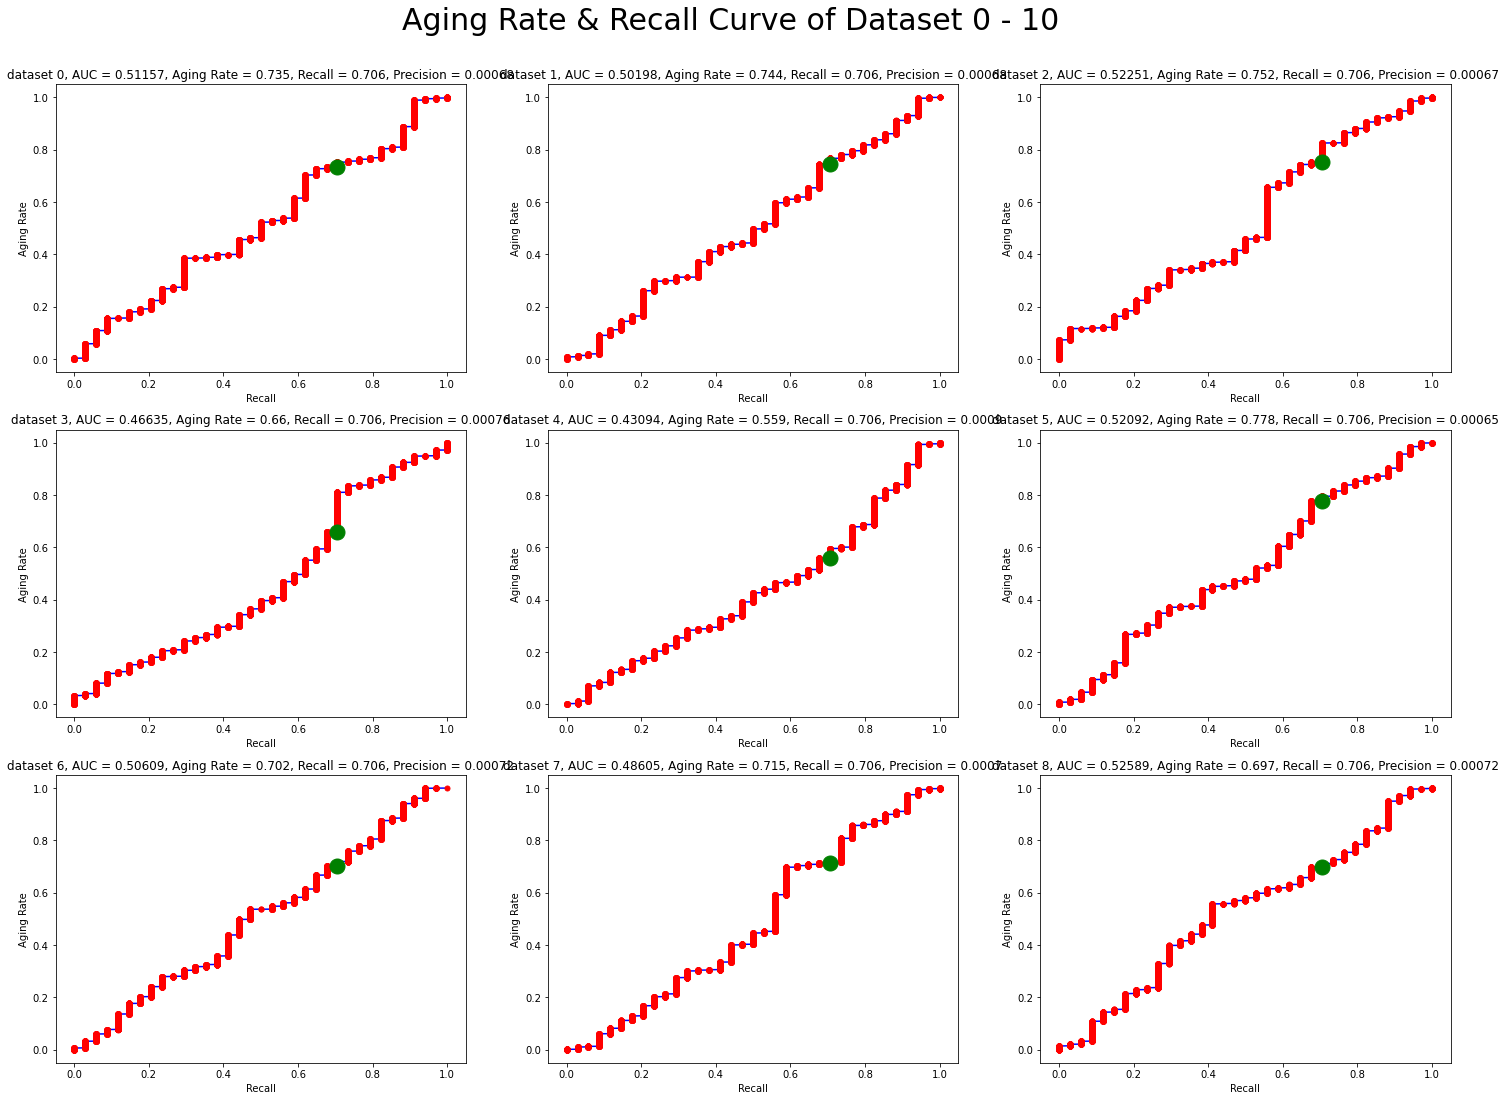

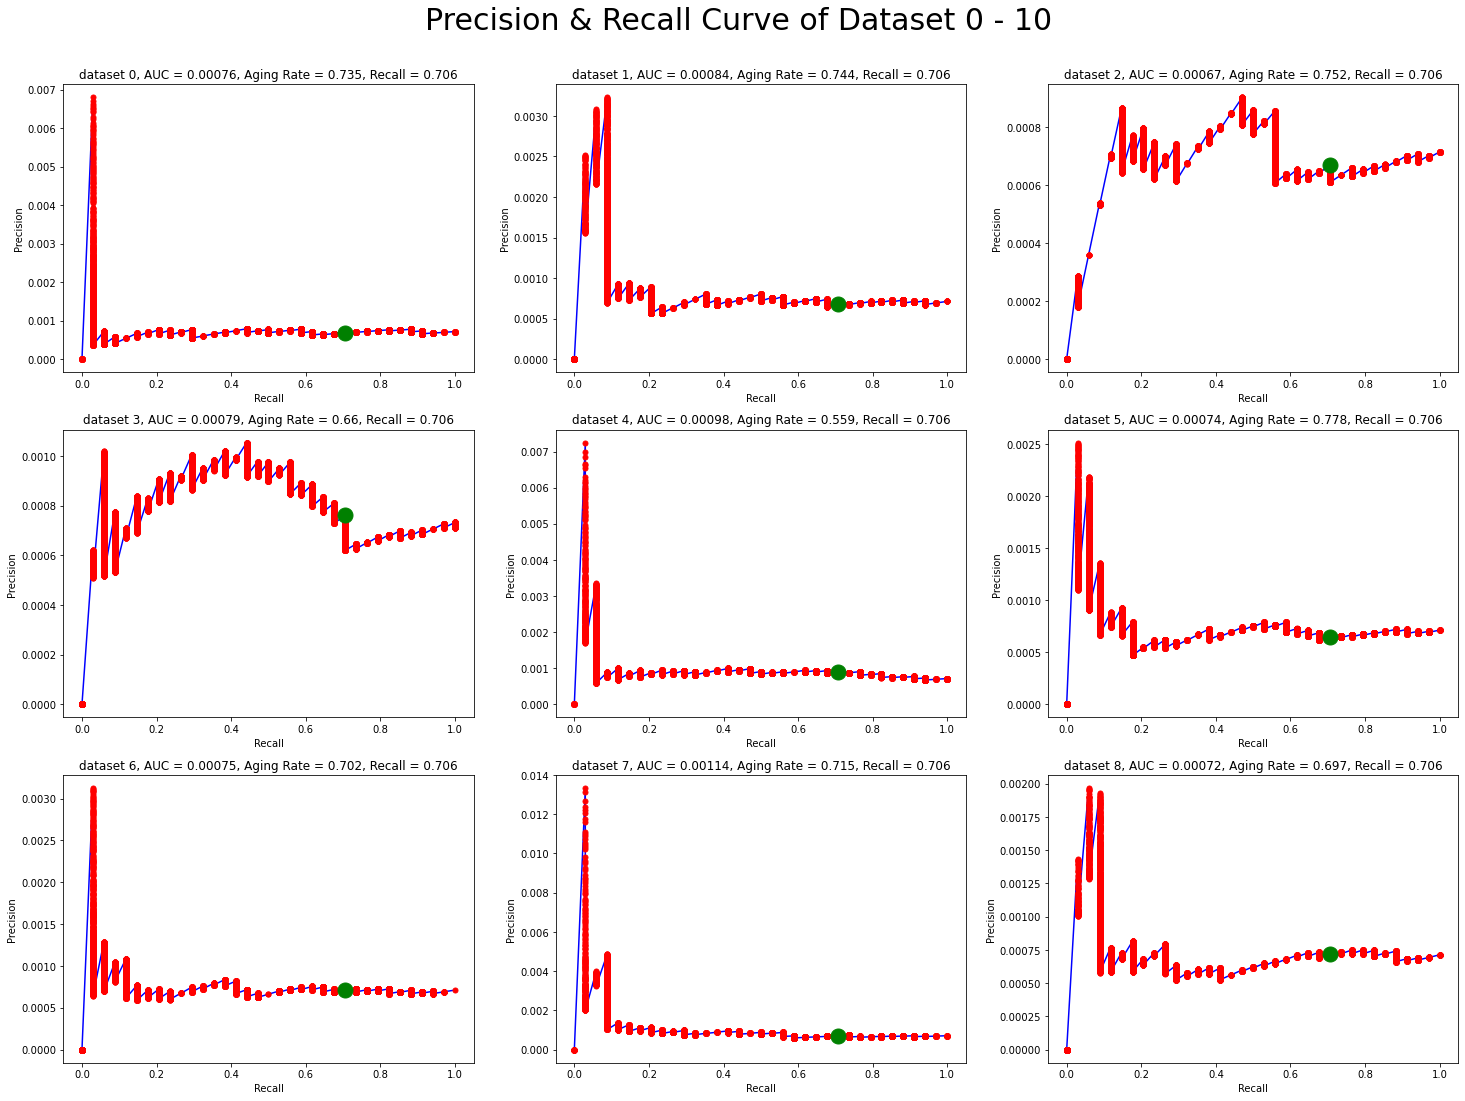

In [11]:
multiple_curve(3, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(3, 3, pr_dict, table_setR, target = 'Precision')
table_setR

## Optimization

### Optuna

In [5]:
def objective_creator(train_data, mode, num_valid = 3, label = 'GB') :

    def objective(trial) :
    
        param = {
            'objective': trial.suggest_categorical('objective', ['binary', 'cross_entropy']),
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss']),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300, step = 50),
            'subsample': trial.suggest_float('subsample', 0.5, 0.9, step = 0.2),
            'num_leaves': trial.suggest_int('num_leaves', 5, 40, step = 5),
            'min_child_samples': trial.suggest_int('min_child_samples', 3, 24, step = 3),
            'max_depth': trial.suggest_int('max_depth', 3, 15, step = 2),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.425, step = 0.05),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 5), # alpha
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 5) # lambda
        }

        result_list = []
        for i in range(num_valid):

            train_x, train_y = label_divide(train_data, None, label, train_only = True)
            train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size = 0.25)

            if mode == 'C':
                result = LightGBMC(train_x, valid_x, train_y, valid_y, param)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                aging = table['Aging Rate']
                effi = table['Efficiency']
            
                #result_list.append(effi)
                result_list.append(recall - 0.1*aging)

            elif mode == 'R':
                result = LightGBMR(train_x, valid_x, train_y, valid_y, param)
                pr_matrix = PR_matrix(result, valid_y)

                #best_data, _ = best_threshold(pr_matrix, target = 'Recall', threshold = 0.8)
                #aging = best_data['Aging Rate']
                #result_list.append((-1)*aging)

                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)

    return objective

In [6]:
best_paramC, all_scoreC = all_optuna(num_set = 10, 
                                     all_data = data_dict, 
                                     mode = 'C', 
                                     TPE_multi = True, 
                                     n_iter = 250,
                                     filename = 'runhist_array_m8m3_one-sided_joinnewevent_eqp+rework_LightGBM',
                                     creator = objective_creator
                                    )

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-09-12 11:24:15,419] A new study created in memory with name: no-name-53a3d1fb-db03-4ec4-b312-2e065a225e2c


Dataset0 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/250 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.07142857142857142 
Aging Rate: 4.9677098857426726e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.5 
Recall: 0.07142857142857142 
Aging Rate: 9.935419771485345e-05
[I 2021-09-12 11:24:27,751] Trial 0 finished with value: 0.04761407990916187 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0056567784700646976, 'reg_lambda': 0.0015695911132720978}. Best is trial 0 with value: 0.04761407990916187.
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0011922503725782414
Precision: 0.018518518518518517 
Recall: 0.05263157894736842 
Aging Rate: 0.002682563338301043
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0029806259314456036
[I 2021-09-12 11:24:58,208] Trial 1 finished with value: 0.017315344994378642 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learnin

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.3333333333333333 
Recall: 0.05 
Aging Rate: 0.00014903129657228018
[I 2021-09-12 11:25:43,074] Trial 5 finished with value: 0.049991720483523766 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'reg_alpha': 3.3573769688835484, 'reg_lambda': 0.016058012601033088}. Best is trial 4 with value: 0.3943997350554727.
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00044709388971684054
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0008445106805762543
Precision: 0.07142857142857142 
Recall: 0.05 
Aging Rate: 0.0006954793840039742
[I 2021-09-12 11:25:48,539] Trial 6 finished with value: 0.016600430534856766 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.3750000000000

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-09-12 11:26:40,936] Trial 9 finished with value: 0.015871359969720625 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 4.787706456028913, 'reg_lambda': 0.0002575803550327768}. Best is trial 8 with value: 0.4542069684306907.
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0006954793840039742
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0007948335817188276
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00029806259314456036
[I 2021-09-12 11:27:08,434] Trial 10 finished with value: -5.961251862891207e-05 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.004612819910791635, 'reg_lambda': 0.00339471524948263}. Best is trial 8 with value: 0.

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.21428571428571427 
Aging Rate: 0.00014903129657228018
[I 2021-09-12 11:28:08,846] Trial 13 finished with value: 0.12141863600879993 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.004650463191449776, 'reg_lambda': 0.03883806938200763}. Best is trial 11 with value: 0.5126904532304725.
Precision: 1.0 
Recall: 0.1111111111111111 
Aging Rate: 9.935419771485345e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-09-12 11:28:17,270] Trial 14 finished with value: 0.03703372523044654 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 0.0006201767039327136, 'reg_lambda': 0.783269078111002}. Best is trial 11 with value: 0.5126904532304725.
Precision: 1.0 
Recall: 0.058823529411764705 
Aging Rate: 4.9677098857426726e-05
Precision: 1.0 
Recall: 0.21052631578947367 
Aging Rate: 0.0001987083954297069
Precision: 1.0 
Recall: 0.4444444444444444 
Aging Rate: 0.0003974167908594138
[I 2021-09-12 11:28:25,531] Trial 15 finished with value: 0.23790990313905605 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.125, 'reg_alpha': 0.002993977725784055, 'reg_lambda': 2.800934722942

Precision: 1.0 
Recall: 0.4375 
Aging Rate: 0.0003477396920019871
[I 2021-09-12 11:35:24,594] Trial 27 finished with value: 0.3436592775613483 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 0.0001137016694493271, 'reg_lambda': 0.26259383277527026}. Best is trial 11 with value: 0.5126904532304725.
Precision: 0.7 
Recall: 0.2692307692307692 
Aging Rate: 0.0004967709885742673
Precision: 1.0 
Recall: 0.45 
Aging Rate: 0.00044709388971684054
Precision: 1.0 
Recall: 0.5294117647058824 
Aging Rate: 0.00044709388971684054
[I 2021-09-12 11:36:20,420] Trial 28 finished with value: 0.4161678126866169 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.125, 'reg_alpha': 0.00021077921803624387, 'reg_lambda': 0.07

Precision: 1.0 
Recall: 0.4444444444444444 
Aging Rate: 0.0003974167908594138
Precision: 0.5625 
Recall: 0.47368421052631576 
Aging Rate: 0.0007948335817188276
[I 2021-09-12 11:41:37,777] Trial 40 finished with value: 0.45181991761154827 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.003862209499048799, 'reg_lambda': 0.004793627771105183}. Best is trial 39 with value: 0.5235280224464612.
Precision: 0.875 
Recall: 0.4666666666666667 
Aging Rate: 0.0003974167908594138
Precision: 0.9230769230769231 
Recall: 0.5217391304347826 
Aging Rate: 0.0006458022851465474
Precision: 0.6666666666666666 
Recall: 0.6666666666666666 
Aging Rate: 0.0005961251862891207
[I 2021-09-12 11:43:14,860] Trial 41 finished with value: 0.5516361764472955 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 3

Precision: 1.0 
Recall: 0.42857142857142855 
Aging Rate: 0.00044709388971684054
Precision: 0.6666666666666666 
Recall: 0.38095238095238093 
Aging Rate: 0.0005961251862891207
Precision: 1.0 
Recall: 0.5263157894736842 
Aging Rate: 0.0004967709885742673
[I 2021-09-12 11:47:37,668] Trial 53 finished with value: 0.44522853333034523 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.08644689100790308, 'reg_lambda': 1.271731211863304}. Best is trial 44 with value: 0.5610614340122537.
Precision: 0.7692307692307693 
Recall: 0.5555555555555556 
Aging Rate: 0.0006458022851465474
Precision: 0.8888888888888888 
Recall: 0.38095238095238093 
Aging Rate: 0.00044709388971684054
Precision: 1.0 
Recall: 0.5714285714285714 
Aging Rate: 0.0003974167908594138
[I 2021-09-12 11:47:57,372] Trial 54 finished with value: 0.5025958255466452 and parameters: 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.09523809523809523 
Aging Rate: 9.935419771485345e-05
[I 2021-09-12 11:48:42,012] Trial 59 finished with value: 0.03174271993944125 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.025, 'reg_alpha': 0.0903226238854984, 'reg_lambda': 0.7827607349645633}. Best is trial 44 with value: 0.5610614340122537.
Precision: 1.0 
Recall: 0.47368421052631576 
Aging Rate: 0.00044709388971684054
Precision: 1.0 
Recall: 0.42105263157894735 
Aging Rate: 0.0003974167908594138
Precision: 1.0 
Recall: 0.6363636363636364 
Aging Rate: 0.0006954793840039742
[I 2021-09-12 11:50:04,273] Trial 60 finished with value: 0.5103154931541471 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 11, 'lea

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-09-12 11:57:02,065] Trial 67 finished with value: 0.07325510555018751 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.025, 'reg_alpha': 0.23139303139114406, 'reg_lambda': 0.7836494559675614}. Best is trial 44 with value: 0.5610614340122537.
Precision: 1.0 
Recall: 0.47058823529411764 
Aging Rate: 0.0003974167908594138
Precision: 1.0 
Recall: 0.3 
Aging Rate: 0.00029806259314456036
Precision: 0.8571428571428571 
Recall: 0.2727272727272727 
Aging Rate: 0.0003477396920019871
[I 2021-09-12 11:58:57,679] Trial 68 finished with value: 0.3477370620379299 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0012261353606889934, 'reg_lamb

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.17647058823529413 
Aging Rate: 0.00014903129657228018
[I 2021-09-12 12:03:09,760] Trial 74 finished with value: 0.11436914954754877 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 1.0890551178162677, 'reg_lambda': 1.8028605701483271}. Best is trial 44 with value: 0.5610614340122537.
Precision: 0.05 
Recall: 0.0625 
Aging Rate: 0.0009935419771485345
Precision: 0.058823529411764705 
Recall: 0.1875 
Aging Rate: 0.002533532041728763
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0005961251862891207
[I 2021-09-12 12:03:19,209] Trial 75 finished with value: 0.08319589335982779 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.225, 'r

Precision: 1.0 
Recall: 0.15 
Aging Rate: 0.00014903129657228018


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-09-12 12:12:28,159] Trial 87 finished with value: 0.08029640668984932 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.1369433240900823, 'reg_lambda': 2.529362576768357}. Best is trial 84 with value: 0.6051520380683452.
Precision: 1.0 
Recall: 0.5 
Aging Rate: 0.0004967709885742673
Precision: 1.0 
Recall: 0.4666666666666667 
Aging Rate: 0.0003477396920019871
Precision: 1.0 
Recall: 0.4090909090909091 
Aging Rate: 0.00044709388971684054
[I 2021-09-12 12:14:22,019] Trial 88 finished with value: 0.45854280510018214 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.011335622946090314, 'reg_lambda': 0.4384

Precision: 1.0 
Recall: 0.5882352941176471 
Aging Rate: 0.0004967709885742673
[I 2021-09-12 12:32:21,191] Trial 100 finished with value: 0.5196171548163631 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0016300500865843901, 'reg_lambda': 0.10223664447997055}. Best is trial 84 with value: 0.6051520380683452.
Precision: 1.0 
Recall: 0.5333333333333333 
Aging Rate: 0.0003974167908594138
Precision: 1.0 
Recall: 0.35 
Aging Rate: 0.0003477396920019871
Precision: 0.7777777777777778 
Recall: 0.5833333333333334 
Aging Rate: 0.00044709388971684054
[I 2021-09-12 12:32:44,881] Trial 101 finished with value: 0.48884914720980294 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.275, 'reg_al

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.058823529411764705 
Aging Rate: 4.9677098857426726e-05
Precision: 1.0 
Recall: 0.04 
Aging Rate: 4.9677098857426726e-05
[I 2021-09-12 12:39:52,333] Trial 107 finished with value: 0.032937864663997736 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.025, 'reg_alpha': 0.010636168665767535, 'reg_lambda': 2.020103272335908}. Best is trial 103 with value: 0.6084953961713846.
Precision: 1.0 
Recall: 0.5 
Aging Rate: 0.0003477396920019871
Precision: 1.0 
Recall: 0.45 
Aging Rate: 0.00044709388971684054
Precision: 0.5833333333333334 
Recall: 0.4117647058823529 
Aging Rate: 0.0005961251862891207
[I 2021-09-12 12:40:26,726] Trial 108 finished with value: 0.45387520333518405 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 4

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.125 
Aging Rate: 0.00014903129657228018
[I 2021-09-12 12:48:35,209] Trial 119 finished with value: 0.04166169895678092 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 1.4771292481083222, 'reg_lambda': 4.123384561132521}. Best is trial 103 with value: 0.6084953961713846.
Precision: 1.0 
Recall: 0.3333333333333333 
Aging Rate: 0.00029806259314456036
Precision: 1.0 
Recall: 0.36363636363636365 
Aging Rate: 0.0001987083954297069
Precision: 0.8 
Recall: 0.47058823529411764 
Aging Rate: 0.0004967709885742673
[I 2021-09-12 12:48:46,459] Trial 120 finished with value: 0.3891528593553666 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-09-12 12:56:50,083] Trial 131 finished with value: 0.0 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 6, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha': 0.0010064641767364038, 'reg_lambda': 4.682766540826395}. Best is trial 103 with value: 0.6084953961713846.
Precision: 1.0 
Recall: 0.45454545454545453 
Aging Rate: 0.00024838549428713363
Precision: 0.03125 
Recall: 0.125 
Aging Rate: 0.0031793343268753105
Precision: 0.056074766355140186 
Recall: 0.3 
Aging Rate: 0.00531544957774466
[I 2021-09-12 12:57:01,032] Trial 132 finished with value: 0.2928903792018546 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.225, 'reg_alpha': 0.0015906898955949972, 'reg_lambda': 0.02156439521419538}. Best is trial 10

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.07692307692307693 
Aging Rate: 9.935419771485345e-05
Precision: 1.0 
Recall: 0.037037037037037035 
Aging Rate: 4.9677098857426726e-05
[I 2021-09-12 12:58:33,100] Trial 134 finished with value: 0.037981736943485576 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0212859974757774, 'reg_lambda': 0.4535054370304747}. Best is trial 103 with value: 0.6084953961713846.
Precision: 0.5 
Recall: 0.08333333333333333 
Aging Rate: 9.935419771485345e-05
Precision: 1.0 
Recall: 0.45 
Aging Rate: 0.00044709388971684054
Precision: 0.8181818181818182 
Recall: 0.45 
Aging Rate: 0.000546448087431694
[I 2021-09-12 13:00:15,011] Trial 135 finished with value: 0.32774134790528237 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subs

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-09-12 13:05:34,513] Trial 141 finished with value: 0.07211813272210166 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 1.982949729124057, 'reg_lambda': 3.762426590900688}. Best is trial 103 with value: 0.6084953961713846.
Precision: 0.8461538461538461 
Recall: 0.4782608695652174 
Aging Rate: 0.0006458022851465474
Precision: 0.875 
Recall: 0.3333333333333333 
Aging Rate: 0.0003974167908594138
Precision: 0.8888888888888888 
Recall: 0.5 
Aging Rate: 0.00044709388971684054
[I 2021-09-12 13:06:34,406] Trial 142 finished with value: 0.4371483905339928 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00020388597361486148, 

Precision: 1.0 
Recall: 0.4090909090909091 
Aging Rate: 0.00044709388971684054
Precision: 0.875 
Recall: 0.4666666666666667 
Aging Rate: 0.0003974167908594138
Precision: 0.9166666666666666 
Recall: 0.6470588235294118 
Aging Rate: 0.0005961251862891207
[I 2021-09-12 13:21:09,900] Trial 154 finished with value: 0.5075574452334336 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.02888898376115428, 'reg_lambda': 0.8628175413213074}. Best is trial 103 with value: 0.6084953961713846.
Precision: 1.0 
Recall: 0.1111111111111111 
Aging Rate: 9.935419771485345e-05
Precision: 1.0 
Recall: 0.21052631578947367 
Aging Rate: 0.0001987083954297069
Precision: 0.875 
Recall: 0.3333333333333333 
Aging Rate: 0.0003974167908594138
[I 2021-09-12 13:21:43,372] Trial 155 finished with value: 0.21830040409850593 and parameters: {'objective

Precision: 1.0 
Recall: 0.15 
Aging Rate: 0.00014903129657228018
Precision: 1.0 
Recall: 0.04 
Aging Rate: 4.9677098857426726e-05
Precision: 1.0 
Recall: 0.2 
Aging Rate: 0.0001987083954297069
[I 2021-09-12 13:35:21,559] Trial 167 finished with value: 0.12998675277363803 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.3038641159013311, 'reg_lambda': 1.4396363878325038}. Best is trial 166 with value: 0.6143111929322151.
Precision: 1.0 
Recall: 0.44 
Aging Rate: 0.000546448087431694
Precision: 0.8888888888888888 
Recall: 0.42105263157894735 
Aging Rate: 0.00044709388971684054
Precision: 0.8461538461538461 
Recall: 0.6111111111111112 
Aging Rate: 0.0006458022851465474
[I 2021-09-12 13:36:20,958] Trial 168 finished with value: 0.49066660275460966 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.0 
Recall: 0.0 
Aging Rate: 4.9677098857426726e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-09-12 13:38:01,447] Trial 171 finished with value: -1.6559032952475575e-06 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 2.9199948270203664, 'reg_lambda': 0.0024204556692912246}. Best is trial 166 with value: 0.6143111929322151.
Precision: 1.0 
Recall: 0.45 
Aging Rate: 0.00044709388971684054
Precision: 1.0 
Recall: 0.7857142857142857 
Aging Rate: 0.000546448087431694
Precision: 0.8888888888888888 
Recall: 0.36363636363636365 
Aging Rate: 0.00044709388971684054
[I 2021-09-12 13:38:13,088] Trial 172 finished with value: 0.533068861921321 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 15, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.025624372815305444, 'reg_lamb

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-09-12 13:45:18,067] Trial 181 finished with value: 0.055121581515024144 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.125, 'reg_alpha': 0.07770746165718521, 'reg_lambda': 1.8660444028560927}. Best is trial 166 with value: 0.6143111929322151.
Precision: 1.0 
Recall: 0.3181818181818182 
Aging Rate: 0.0003477396920019871
Precision: 1.0 
Recall: 0.45454545454545453 
Aging Rate: 0.0004967709885742673
Precision: 1.0 
Recall: 0.45454545454545453 
Aging Rate: 0.00024838549428713363
[I 2021-09-12 13:45:28,720] Trial 182 finished with value: 0.40905447921841365 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.2523209693596668, 'reg_lambda': 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.047619047619047616 
Aging Rate: 4.9677098857426726e-05
[I 2021-09-12 13:46:45,897] Trial 191 finished with value: 0.015871359969720625 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0021899281826450786, 'reg_lambda': 0.10534445864245845}. Best is trial 186 with value: 0.6233219785678803.
Precision: 1.0 
Recall: 0.125 
Aging Rate: 0.00014903129657228018
Precision: 1.0 
Recall: 0.125 
Aging Rate: 9.935419771485345e-05
Precision: 1.0 
Recall: 0.13636363636363635 
Aging Rate: 0.00014903129657228018
[I 2021-09-12 13:46:51,732] Trial 192 finished with value: 0.1287746315615168 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 3, 'learnin

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-09-12 13:49:40,512] Trial 198 finished with value: 0.1388756416625269 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.4473521679795733, 'reg_lambda': 0.4206137423390989}. Best is trial 186 with value: 0.6233219785678803.
Precision: 1.0 
Recall: 0.23076923076923078 
Aging Rate: 0.00029806259314456036
Precision: 1.0 
Recall: 0.38095238095238093 
Aging Rate: 0.0003974167908594138
Precision: 1.0 
Recall: 0.32142857142857145 
Aging Rate: 0.00044709388971684054
[I 2021-09-12 13:50:19,080] Trial 199 finished with value: 0.3110119752742704 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.061150433760801, 'reg_lambd

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-09-12 14:12:04,345] Trial 210 finished with value: 0.05555058784566982 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.025, 'reg_alpha': 0.003116340654499343, 'reg_lambda': 1.5542297345806064}. Best is trial 186 with value: 0.6233219785678803.
Precision: 1.0 
Recall: 0.5238095238095238 
Aging Rate: 0.000546448087431694
Precision: 0.8571428571428571 
Recall: 0.3333333333333333 
Aging Rate: 0.0003477396920019871
Precision: 0.8571428571428571 
Recall: 0.6 
Aging Rate: 0.0006954793840039742
[I 2021-09-12 14:13:12,277] Trial 211 finished with value: 0.4856612968088378 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.029974438661358

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.3333333333333333 
Recall: 0.13333333333333333 
Aging Rate: 0.00029806259314456036
Precision: 1.0 
Recall: 0.058823529411764705 
Aging Rate: 4.9677098857426726e-05
[I 2021-09-12 14:23:40,746] Trial 221 finished with value: 0.06404069625863261 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.2828843466779035, 'reg_lambda': 3.7833741172991626}. Best is trial 186 with value: 0.6233219785678803.
Precision: 0.8571428571428571 
Recall: 0.3157894736842105 
Aging Rate: 0.0003477396920019871
Precision: 1.0 
Recall: 0.7857142857142857 
Aging Rate: 0.000546448087431694
Precision: 0.8333333333333334 
Recall: 0.45454545454545453 
Aging Rate: 0.00029806259314456036
[I 2021-09-12 14:25:53,607] Trial 222 finished with value: 0.5186433296355643 and parameters: {'objective': 'cr

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.15789473684210525 
Aging Rate: 0.00014903129657228018
Precision: 1.0 
Recall: 0.10526315789473684 
Aging Rate: 9.935419771485345e-05
[I 2021-09-12 14:31:28,684] Trial 227 finished with value: 0.08771101872913778 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.125, 'reg_alpha': 0.54087081257814, 'reg_lambda': 1.5099723467701887}. Best is trial 186 with value: 0.6233219785678803.
Precision: 1.0 
Recall: 0.7692307692307693 
Aging Rate: 0.0004967709885742673
Precision: 0.375 
Recall: 0.3157894736842105 
Aging Rate: 0.0007948335817188276
Precision: 0.5 
Recall: 0.42857142857142855 
Aging Rate: 0.0008941877794336811
[I 2021-09-12 14:32:31,552] Trial 228 finished with value: 0.5044576974171452 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsamp

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\AdaClassifier.py:116: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.07692307692307693 
Aging Rate: 4.9677098857426726e-05
Precision: 1.0 
Recall: 0.14285714285714285 
Aging Rate: 0.00014903129657228018
[I 2021-09-12 14:35:33,849] Trial 230 finished with value: 0.07325344964689227 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.916563420339381, 'reg_lambda': 0.43466079975754984}. Best is trial 186 with value: 0.6233219785678803.
Precision: 0.8181818181818182 
Recall: 0.5294117647058824 
Aging Rate: 0.000546448087431694
Precision: 1.0 
Recall: 0.3684210526315789 
Aging Rate: 0.0003477396920019871
Precision: 0.8571428571428571 
Recall: 0.35294117647058826 
Aging Rate: 0.0003477396920019871
[I 2021-09-12 14:37:18,196] Trial 231 finished with value: 0.416883267020302 and parameters: {'objective': 'binary', 'boosting_ty

Precision: 0.8181818181818182 
Recall: 0.42857142857142855 
Aging Rate: 0.000546448087431694
Precision: 0.8571428571428571 
Recall: 0.631578947368421 
Aging Rate: 0.0006954793840039742
Precision: 0.7857142857142857 
Recall: 0.5238095238095238 
Aging Rate: 0.0006954793840039742
[I 2021-09-12 14:56:22,699] Trial 243 finished with value: 0.5279220530212765 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.000197774720394254, 'reg_lambda': 0.10773450605787714}. Best is trial 237 with value: 0.6375101315135828.
Precision: 0.022222222222222223 
Recall: 0.10526315789473684 
Aging Rate: 0.004470938897168405
Precision: 0.0410958904109589 
Recall: 0.15 
Aging Rate: 0.003626428216592151
Precision: 0.02702702702702703 
Recall: 0.1875 
Aging Rate: 0.005514157973174367
[I 2021-09-12 14:59:22,553] Trial 244 finished with value: 0.1471340017953

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-09-12 15:13:57,508] A new study created in memory with name: no-name-d0bd164c-6c03-498b-9298-a1e59253130e


Sampler is TPESampler
Dataset1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/250 [00:00<?, ?it/s]

Precision: 0.95260663507109 
Recall: 0.9710144927536232 
Aging Rate: 0.5158924205378973
Precision: 0.941747572815534 
Recall: 0.941747572815534 
Aging Rate: 0.5036674816625917
Precision: 0.9441860465116279 
Recall: 0.9269406392694064 
Aging Rate: 0.5256723716381418
[I 2021-09-12 15:14:09,440] Trial 0 finished with value: 0.8950598258182335 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 0.0015636905116652702, 'reg_lambda': 3.4435086285800804}. Best is trial 0 with value: 0.8950598258182335.
Precision: 1.0 
Recall: 0.9842931937172775 
Aging Rate: 0.45965770171149145
Precision: 0.995260663507109 
Recall: 0.9905660377358491 
Aging Rate: 0.5158924205378973
Precision: 0.9861111111111112 
Recall: 0.9770642201834863 
Aging Rate: 0.5281173594132029
[I 2021-09-12 15:14:13,344] Trial 1 finished with value: 0.9338522344901179 and parameters

Precision: 0.9802955665024631 
Recall: 0.9851485148514851 
Aging Rate: 0.4963325183374083
Precision: 0.9698492462311558 
Recall: 0.9507389162561576 
Aging Rate: 0.48655256723716384
Precision: 0.9764150943396226 
Recall: 0.9764150943396226 
Aging Rate: 0.5183374083129584
[I 2021-09-12 15:15:58,793] Trial 13 finished with value: 0.9207267586861706 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.025, 'reg_alpha': 0.30158552447235876, 'reg_lambda': 0.021674817916466586}. Best is trial 10 with value: 0.9411007538173687.
Precision: 0.9803921568627451 
Recall: 0.9803921568627451 
Aging Rate: 0.49877750611246946
Precision: 0.9855072463768116 
Recall: 0.9855072463768116 
Aging Rate: 0.5061124694376528
Precision: 0.9951219512195122 
Recall: 0.9902912621359223 
Aging Rate: 0.5012224938875306
[I 2021-09-12 15:16:02,590] Trial 14 finished with value: 0.9351931394772378

Precision: 0.9952830188679245 
Recall: 0.985981308411215 
Aging Rate: 0.5183374083129584
[I 2021-09-12 15:19:41,760] Trial 25 finished with value: 0.9259293139231174 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 1.1470304760879833, 'reg_lambda': 0.3067728399945985}. Best is trial 16 with value: 0.9435936310249557.
Precision: 0.9899497487437185 
Recall: 0.985 
Aging Rate: 0.48655256723716384
Precision: 0.9945054945054945 
Recall: 0.9890710382513661 
Aging Rate: 0.4449877750611247
Precision: 0.9897959183673469 
Recall: 0.9948717948717949 
Aging Rate: 0.4792176039119804
[I 2021-09-12 15:20:41,793] Trial 26 finished with value: 0.942622346167378 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.0750000

Precision: 0.9907834101382489 
Recall: 0.9907834101382489 
Aging Rate: 0.530562347188264
Precision: 0.9953917050691244 
Recall: 0.9773755656108597 
Aging Rate: 0.530562347188264
Precision: 0.995049504950495 
Recall: 0.9804878048780488 
Aging Rate: 0.4938875305623472
[I 2021-09-12 15:21:46,224] Trial 38 finished with value: 0.9310485193777566 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.23714602113377395, 'reg_lambda': 4.561677188911593}. Best is trial 16 with value: 0.9435936310249557.
Precision: 0.9862385321100917 
Recall: 0.9862385321100917 
Aging Rate: 0.5330073349633252
Precision: 0.9698492462311558 
Recall: 0.9796954314720813 
Aging Rate: 0.48655256723716384
Precision: 0.985 
Recall: 0.9800995024875622 
Aging Rate: 0.4889975550122249
[I 2021-09-12 15:21:50,256] Trial 39 finished with value: 0.9317259067828213 and

Precision: 0.9906542056074766 
Recall: 0.9906542056074766 
Aging Rate: 0.5232273838630807
Precision: 0.995260663507109 
Recall: 0.9859154929577465 
Aging Rate: 0.5158924205378973
Precision: 0.9702970297029703 
Recall: 0.9849246231155779 
Aging Rate: 0.4938875305623472
[I 2021-09-12 15:22:23,713] Trial 51 finished with value: 0.9360645293948228 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 2.012205195397886, 'reg_lambda': 0.048248535167282204}. Best is trial 16 with value: 0.9435936310249557.
Precision: 0.9850746268656716 
Recall: 0.99 
Aging Rate: 0.49144254278728605
Precision: 1.0 
Recall: 0.9899497487437185 
Aging Rate: 0.48166259168704156
Precision: 0.9849246231155779 
Recall: 0.9949238578680203 
Aging Rate: 0.48655256723716384
[I 2021-09-12 15:22:26,333] Trial 52 finished with value: 0.9429692788135299 and parameters: {'obj

Precision: 0.9908256880733946 
Recall: 0.9908256880733946 
Aging Rate: 0.5330073349633252
[I 2021-09-12 15:22:44,062] Trial 63 finished with value: 0.9388077318115117 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.01964759102810779, 'reg_lambda': 0.06086266836771322}. Best is trial 54 with value: 0.9448836091398118.
Precision: 0.995049504950495 
Recall: 0.9901477832512315 
Aging Rate: 0.4938875305623472
Precision: 0.9844559585492227 
Recall: 0.9947643979057592 
Aging Rate: 0.4718826405867971
Precision: 0.9947089947089947 
Recall: 0.9690721649484536 
Aging Rate: 0.4621026894865526
[I 2021-09-12 15:22:46,276] Trial 64 finished with value: 0.9370656866806248 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth':

Precision: 0.9864253393665159 
Recall: 0.9864253393665159 
Aging Rate: 0.5403422982885085
Precision: 0.9950248756218906 
Recall: 0.9803921568627451 
Aging Rate: 0.49144254278728605
Precision: 0.9903846153846154 
Recall: 0.9809523809523809 
Aging Rate: 0.508557457212714
[I 2021-09-12 15:23:14,499] Trial 76 finished with value: 0.9312452157842636 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0022662786058027856, 'reg_lambda': 0.9342089714800821}. Best is trial 54 with value: 0.9448836091398118.
Precision: 0.9903381642512077 
Recall: 0.9951456310679612 
Aging Rate: 0.5061124694376528
Precision: 0.9802955665024631 
Recall: 0.9900497512437811 
Aging Rate: 0.4963325183374083
Precision: 0.9951456310679612 
Recall: 0.9855769230769231 
Aging Rate: 0.5036674816625917
[I 2021-09-12 15:23:15,805] Trial 77 finished with valu

Precision: 0.9759615384615384 
Recall: 0.9666666666666667 
Aging Rate: 0.508557457212714
Precision: 0.9952153110047847 
Recall: 0.9811320754716981 
Aging Rate: 0.511002444987775
[I 2021-09-12 15:23:35,547] Trial 88 finished with value: 0.9235931104869235 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 0.012020287279023009, 'reg_lambda': 0.020919084571249146}. Best is trial 54 with value: 0.9448836091398118.
Precision: 0.9848484848484849 
Recall: 0.9701492537313433 
Aging Rate: 0.4841075794621027
Precision: 0.9899497487437185 
Recall: 0.9704433497536946 
Aging Rate: 0.48655256723716384
Precision: 1.0 
Recall: 0.9656862745098039 
Aging Rate: 0.48166259168704156
[I 2021-09-12 15:23:37,205] Trial 89 finished with value: 0.9203488680520703 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 's

Precision: 0.9951219512195122 
Recall: 0.9855072463768116 
Aging Rate: 0.5012224938875306
Precision: 0.9952830188679245 
Recall: 0.9906103286384976 
Aging Rate: 0.5183374083129584
Precision: 0.9950980392156863 
Recall: 0.9806763285024155 
Aging Rate: 0.49877750611246946
[I 2021-09-12 15:23:52,457] Trial 101 finished with value: 0.9349867208954762 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0900736106357283, 'reg_lambda': 0.148787479945007}. Best is trial 97 with value: 0.9450383817797919.
Precision: 0.9743589743589743 
Recall: 0.9844559585492227 
Aging Rate: 0.4767726161369193
Precision: 0.985981308411215 
Recall: 0.9906103286384976 
Aging Rate: 0.5232273838630807
Precision: 0.9951690821256038 
Recall: 0.9809523809523809 
Aging Rate: 0.5061124694376528
[I 2021-09-12 15:23:53,063] Trial 102 finished with value: 0.935

Precision: 0.9846153846153847 
Recall: 0.9896907216494846 
Aging Rate: 0.4767726161369193
Precision: 1.0 
Recall: 0.9908675799086758 
Aging Rate: 0.530562347188264
[I 2021-09-12 15:24:08,916] Trial 114 finished with value: 0.9359511185552831 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.058360764099424645, 'reg_lambda': 0.009539904129684177}. Best is trial 97 with value: 0.9450383817797919.
Precision: 0.9759615384615384 
Recall: 0.9575471698113207 
Aging Rate: 0.508557457212714
Precision: 0.9705882352941176 
Recall: 0.9801980198019802 
Aging Rate: 0.49877750611246946
Precision: 0.9893617021276596 
Recall: 0.9393939393939394 
Aging Rate: 0.45965770171149145
[I 2021-09-12 15:24:10,651] Trial 115 finished with value: 0.9101466208345244 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsamp

Precision: 1.0 
Recall: 0.975609756097561 
Aging Rate: 0.4889975550122249
Precision: 0.9955156950672646 
Recall: 0.9736842105263158 
Aging Rate: 0.5452322738386308
Precision: 0.9543147208121827 
Recall: 0.9791666666666666 
Aging Rate: 0.48166259168704156
[I 2021-09-12 15:24:20,223] Trial 127 finished with value: 0.9256237970789178 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.08495486113137068, 'reg_lambda': 0.007889705390003762}. Best is trial 97 with value: 0.9450383817797919.
Precision: 0.9862385321100917 
Recall: 0.9862385321100917 
Aging Rate: 0.5330073349633252
Precision: 0.9893617021276596 
Recall: 0.9893617021276596 
Aging Rate: 0.45965770171149145
Precision: 0.9952380952380953 
Recall: 0.9858490566037735 
Aging Rate: 0.5134474327628362
[I 2021-09-12 15:24:20,954] Trial 128 finished with value: 0.936946

Precision: 0.984375 
Recall: 0.9692307692307692 
Aging Rate: 0.46943765281173594
Precision: 0.9906976744186047 
Recall: 0.9861111111111112 
Aging Rate: 0.5256723716381418
Precision: 0.9950248756218906 
Recall: 0.9950248756218906 
Aging Rate: 0.49144254278728605
[I 2021-09-12 15:24:34,606] Trial 140 finished with value: 0.9339038330800182 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.0091841185028023, 'reg_lambda': 4.9174207034963135}. Best is trial 97 with value: 0.9450383817797919.
Precision: 0.9946236559139785 
Recall: 0.9840425531914894 
Aging Rate: 0.4547677261613692
Precision: 0.9952380952380953 
Recall: 0.9858490566037735 
Aging Rate: 0.5134474327628362
Precision: 0.9854368932038835 
Recall: 0.9806763285024155 
Aging Rate: 0.5036674816625917
[I 2021-09-12 15:24:35,700] Trial 141 finished with value: 0.9344598914129995 and para

Precision: 0.9901477832512315 
Recall: 0.9852941176470589 
Aging Rate: 0.4963325183374083
Precision: 0.9949748743718593 
Recall: 0.9801980198019802 
Aging Rate: 0.48655256723716384
Precision: 0.9903381642512077 
Recall: 0.9761904761904762 
Aging Rate: 0.5061124694376528
[I 2021-09-12 15:24:49,514] Trial 153 finished with value: 0.9309276193794309 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.059694686063531927, 'reg_lambda': 0.00025317616815849996}. Best is trial 97 with value: 0.9450383817797919.
Precision: 0.9908675799086758 
Recall: 0.9774774774774775 
Aging Rate: 0.5354523227383863
Precision: 0.9804878048780488 
Recall: 0.9804878048780488 
Aging Rate: 0.5012224938875306
Precision: 0.9754901960784313 
Recall: 0.9660194174757282 
Aging Rate: 0.49877750611246946
[I 2021-09-12 15:24:50,787] Trial 154 finished wit

Precision: 0.9852941176470589 
Recall: 0.9804878048780488 
Aging Rate: 0.49877750611246946
Precision: 1.0 
Recall: 0.9904306220095693 
Aging Rate: 0.5061124694376528
[I 2021-09-12 15:25:02,204] Trial 165 finished with value: 0.9333828661645898 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.4683326698488793, 'reg_lambda': 0.014983562568824821}. Best is trial 97 with value: 0.9450383817797919.
Precision: 0.9899497487437185 
Recall: 0.985 
Aging Rate: 0.48655256723716384
Precision: 0.9907834101382489 
Recall: 0.9862385321100917 
Aging Rate: 0.530562347188264
Precision: 0.9897435897435898 
Recall: 0.9897435897435898 
Aging Rate: 0.4767726161369193
[I 2021-09-12 15:25:02,903] Trial 166 finished with value: 0.937197789599149 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.

Precision: 0.990909090909091 
Recall: 0.9864253393665159 
Aging Rate: 0.5378973105134475
Precision: 0.9893617021276596 
Recall: 0.96875 
Aging Rate: 0.45965770171149145
Precision: 0.9634703196347032 
Recall: 0.985981308411215 
Aging Rate: 0.5354523227383863
[I 2021-09-12 15:25:22,273] Trial 178 finished with value: 0.9292853047604662 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 0.000436934592358126, 'reg_lambda': 0.00033583247023296633}. Best is trial 97 with value: 0.9450383817797919.
Precision: 1.0 
Recall: 0.9658536585365853 
Aging Rate: 0.4841075794621027
Precision: 0.9950980392156863 
Recall: 0.9902439024390244 
Aging Rate: 0.49877750611246946
Precision: 0.9852216748768473 
Recall: 0.9852216748768473 
Aging Rate: 0.4963325183374083
[I 2021-09-12 15:25:23,975] Trial 179 finished with value: 0.9311324918204197 and parameter

Precision: 1.0 
Recall: 0.9800995024875622 
Aging Rate: 0.48166259168704156
Precision: 0.9812206572769953 
Recall: 0.9952380952380953 
Aging Rate: 0.5207823960880196
Precision: 1.0 
Recall: 0.9802955665024631 
Aging Rate: 0.48655256723716384
[I 2021-09-12 15:25:30,910] Trial 191 finished with value: 0.935577802908966 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.026369736324658402, 'reg_lambda': 4.179155119373734}. Best is trial 97 with value: 0.9450383817797919.
Precision: 1.0 
Recall: 0.9732142857142857 
Aging Rate: 0.5330073349633252
Precision: 1.0 
Recall: 0.9847715736040609 
Aging Rate: 0.4743276283618582
Precision: 0.9812206572769953 
Recall: 0.9812206572769953 
Aging Rate: 0.5207823960880196
[I 2021-09-12 15:25:32,113] Trial 192 finished with value: 0.9287982602180072 and parameters: {'objective': 'cross_entropy', 'boosting_t

Precision: 0.9901960784313726 
Recall: 1.0 
Aging Rate: 0.49877750611246946
Precision: 0.995475113122172 
Recall: 0.9821428571428571 
Aging Rate: 0.5403422982885085
Precision: 0.9951923076923077 
Recall: 0.9857142857142858 
Aging Rate: 0.508557457212714
[I 2021-09-12 15:25:42,911] Trial 204 finished with value: 0.9376964722319245 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.13636836182833956, 'reg_lambda': 0.0003027570120690599}. Best is trial 195 with value: 0.9451313565453981.
Precision: 0.9728260869565217 
Recall: 0.988950276243094 
Aging Rate: 0.44987775061124696
Precision: 0.9807692307692307 
Recall: 0.9855072463768116 
Aging Rate: 0.508557457212714
Precision: 0.9757281553398058 
Recall: 0.9852941176470589 
Aging Rate: 0.5036674816625917
[I 2021-09-12 15:25:43,549] Trial 205 finished with value: 0.9378471237727698 and 

Precision: 0.9852941176470589 
Recall: 0.9901477832512315 
Aging Rate: 0.49877750611246946
[I 2021-09-12 15:25:54,370] Trial 216 finished with value: 0.9311115453333353 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0003100086942628309, 'reg_lambda': 0.0037533185449250724}. Best is trial 195 with value: 0.9451313565453981.
Precision: 0.9898477157360406 
Recall: 0.9898477157360406 
Aging Rate: 0.48166259168704156
Precision: 0.9855072463768116 
Recall: 0.9855072463768116 
Aging Rate: 0.5061124694376528
Precision: 0.9949494949494949 
Recall: 0.9800995024875622 
Aging Rate: 0.4841075794621027
[I 2021-09-12 15:25:54,869] Trial 217 finished with value: 0.9360887335139115 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth

Precision: 0.98 
Recall: 0.98 
Aging Rate: 0.4889975550122249
Precision: 0.9950738916256158 
Recall: 0.9805825242718447 
Aging Rate: 0.4963325183374083
Precision: 0.9864253393665159 
Recall: 0.9954337899543378 
Aging Rate: 0.5403422982885085
[I 2021-09-12 15:26:05,854] Trial 229 finished with value: 0.9344830256874562 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.2529966240367043, 'reg_lambda': 0.0007554822729895458}. Best is trial 225 with value: 0.9477321171086452.
Precision: 0.9951456310679612 
Recall: 0.9761904761904762 
Aging Rate: 0.5036674816625917
Precision: 0.9908256880733946 
Recall: 0.9953917050691244 
Aging Rate: 0.5330073349633252
Precision: 1.0 
Recall: 0.9897959183673469 
Aging Rate: 0.4743276283618582
[I 2021-09-12 15:26:07,023] Trial 230 finished with value: 0.9367592850427234 and parameters: {'objective': 'b

Precision: 0.9802955665024631 
Recall: 0.9476190476190476 
Aging Rate: 0.4963325183374083
Precision: 0.9894179894179894 
Recall: 0.949238578680203 
Aging Rate: 0.4621026894865526
Precision: 0.9705882352941176 
Recall: 0.9473684210526315 
Aging Rate: 0.49877750611246946
[I 2021-09-12 15:26:15,913] Trial 242 finished with value: 0.8995015919860796 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha': 0.0510072128150432, 'reg_lambda': 0.02234421483543954}. Best is trial 225 with value: 0.9477321171086452.
Precision: 0.9716981132075472 
Recall: 0.9716981132075472 
Aging Rate: 0.5183374083129584
Precision: 0.9646464646464646 
Recall: 0.9646464646464646 
Aging Rate: 0.4841075794621027
Precision: 0.9485981308411215 
Recall: 0.9620853080568721 
Aging Rate: 0.5232273838630807
[I 2021-09-12 15:26:16,767] Trial 243 finished with value: 0.91528754

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-09-12 15:26:21,767] A new study created in memory with name: no-name-b89f05ab-72dd-4c15-a1ed-f307085f78c2


Precision: 0.9902912621359223 
Recall: 0.9902912621359223 
Aging Rate: 0.5036674816625917
[I 2021-09-12 15:26:21,645] Trial 249 finished with value: 0.9349073666503264 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0072729157326967, 'reg_lambda': 0.0007361869601884944}. Best is trial 225 with value: 0.9477321171086452.
Sampler is TPESampler
Dataset2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/250 [00:00<?, ?it/s]

Precision: 0.967391304347826 
Recall: 1.0 
Aging Rate: 0.4919786096256685
Precision: 0.9789473684210527 
Recall: 0.9946524064171123 
Aging Rate: 0.5080213903743316
Precision: 0.973404255319149 
Recall: 0.9838709677419355 
Aging Rate: 0.5026737967914439
[I 2021-09-12 15:26:22,232] Trial 0 finished with value: 0.9427519981599678 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.4600202930323418, 'reg_lambda': 0.012131719663476596}. Best is trial 0 with value: 0.9427519981599678.
Precision: 0.988950276243094 
Recall: 0.9835164835164835 
Aging Rate: 0.4839572192513369
Precision: 0.9902439024390244 
Recall: 0.9902439024390244 
Aging Rate: 0.5481283422459893
Precision: 0.9790575916230366 
Recall: 0.9790575916230366 
Aging Rate: 0.5106951871657754
[I 2021-09-12 15:26:22,523] Trial 1 finished with value: 0.9328466342374114 and param

Precision: 0.9836956521739131 
Recall: 0.9890710382513661 
Aging Rate: 0.4919786096256685
Precision: 0.9951690821256038 
Recall: 1.0 
Aging Rate: 0.553475935828877
Precision: 0.9888888888888889 
Recall: 0.9888888888888889 
Aging Rate: 0.48128342245989303
[I 2021-09-12 15:26:32,353] Trial 13 finished with value: 0.9417620434496037 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.16821857990198055, 'reg_lambda': 1.7681954145371601}. Best is trial 11 with value: 0.9429051893557681.
Precision: 0.9846153846153847 
Recall: 0.9896907216494846 
Aging Rate: 0.5213903743315508
Precision: 0.9830508474576272 
Recall: 0.9942857142857143 
Aging Rate: 0.4732620320855615
Precision: 0.9791666666666666 
Recall: 0.9894736842105263 
Aging Rate: 0.5133689839572193
[I 2021-09-12 15:26:33,239] Trial 14 finished with value: 0.9408826603694306 an

Precision: 0.9633507853403142 
Recall: 0.9945945945945946 
Aging Rate: 0.5106951871657754
Precision: 0.9831460674157303 
Recall: 0.9887005649717514 
Aging Rate: 0.47593582887700536
Precision: 0.989010989010989 
Recall: 0.972972972972973 
Aging Rate: 0.48663101604278075
[I 2021-09-12 15:26:42,506] Trial 26 finished with value: 0.9363139764435876 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.02028763214608102, 'reg_lambda': 0.04015048308314977}. Best is trial 16 with value: 0.9439733959795163.
Precision: 0.967741935483871 
Recall: 0.9836065573770492 
Aging Rate: 0.49732620320855614
Precision: 0.973404255319149 
Recall: 0.9786096256684492 
Aging Rate: 0.5026737967914439
Precision: 0.9696969696969697 
Recall: 0.9896907216494846 
Aging Rate: 0.5294117647058824
[I 2021-09-12 15:26:43,040] Trial 27 finished with value: 0.9329

Precision: 0.9774011299435028 
Recall: 1.0 
Aging Rate: 0.4732620320855615
Precision: 0.98989898989899 
Recall: 0.9949238578680203 
Aging Rate: 0.5294117647058824
Precision: 0.9899497487437185 
Recall: 0.9949494949494949 
Aging Rate: 0.5320855614973262
[I 2021-09-12 15:26:56,345] Trial 39 finished with value: 0.9454658056628794 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.004845840567961338, 'reg_lambda': 0.0056226709163162405}. Best is trial 32 with value: 0.9484159890027605.
Precision: 0.9893617021276596 
Recall: 0.9893617021276596 
Aging Rate: 0.5026737967914439
Precision: 0.9722222222222222 
Recall: 1.0 
Aging Rate: 0.48128342245989303
Precision: 0.9738219895287958 
Recall: 0.9841269841269841 
Aging Rate: 0.5106951871657754
[I 2021-09-12 15:26:57,441] Trial 40 finished with value: 0.9413411485376441 and pa

Precision: 0.9738219895287958 
Recall: 0.9946524064171123 
Aging Rate: 0.5106951871657754
Precision: 0.9790575916230366 
Recall: 0.9790575916230366 
Aging Rate: 0.5106951871657754
Precision: 1.0 
Recall: 0.9898477157360406 
Aging Rate: 0.5213903743315508
[I 2021-09-12 15:27:14,960] Trial 52 finished with value: 0.9364265463032931 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 24, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.0016383881184833305, 'reg_lambda': 0.005154046421765393}. Best is trial 32 with value: 0.9484159890027605.
Precision: 0.9896907216494846 
Recall: 0.9896907216494846 
Aging Rate: 0.5187165775401069
Precision: 0.9885714285714285 
Recall: 0.9885714285714285 
Aging Rate: 0.4679144385026738
Precision: 0.9623655913978495 
Recall: 1.0 
Aging Rate: 0.49732620320855614
[I 2021-09-12 15:27:15,869] Trial 53 finished with value: 0.9432888094319264 and parameters: {'objecti

Precision: 0.9781420765027322 
Recall: 0.988950276243094 
Aging Rate: 0.4893048128342246
Precision: 1.0 
Recall: 1.0 
Aging Rate: 0.5240641711229946
Precision: 0.9792746113989638 
Recall: 0.984375 
Aging Rate: 0.516042780748663
[I 2021-09-12 15:27:39,092] Trial 65 finished with value: 0.9401280332575018 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.0080722497278832, 'reg_lambda': 0.00327371296533146}. Best is trial 32 with value: 0.9484159890027605.
Precision: 0.9835164835164835 
Recall: 0.9835164835164835 
Aging Rate: 0.48663101604278075
Precision: 0.9783783783783784 
Recall: 0.9945054945054945 
Aging Rate: 0.4946524064171123
Precision: 0.9895833333333334 
Recall: 0.9895833333333334 
Aging Rate: 0.5133689839572193
[I 2021-09-12 15:27:41,133] Trial 66 finished with value: 0.9393800235712 and parameters: {'objective': 'binary'

Precision: 0.9668508287292817 
Recall: 0.9887005649717514 
Aging Rate: 0.4839572192513369
Precision: 0.9945945945945946 
Recall: 0.9945945945945946 
Aging Rate: 0.4946524064171123
Precision: 0.989247311827957 
Recall: 0.989247311827957 
Aging Rate: 0.49732620320855614
[I 2021-09-12 15:28:03,816] Trial 78 finished with value: 0.9416496295022009 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.0061891232318442915, 'reg_lambda': 0.18289009980981508}. Best is trial 32 with value: 0.9484159890027605.
Precision: 0.9802955665024631 
Recall: 0.9851485148514851 
Aging Rate: 0.5427807486631016
Precision: 0.9698492462311558 
Recall: 0.9796954314720813 
Aging Rate: 0.5320855614973262
Precision: 0.984375 
Recall: 0.984375 
Aging Rate: 0.5133689839572193
[I 2021-09-12 15:28:05,216] Trial 79 finished with value: 0.9301318056372673 and parameters: {'

Precision: 0.9624413145539906 
Recall: 0.9903381642512077 
Aging Rate: 0.56951871657754
Precision: 0.9890710382513661 
Recall: 0.9783783783783784 
Aging Rate: 0.4893048128342246
Precision: 0.9796954314720813 
Recall: 0.9897435897435898 
Aging Rate: 0.5267379679144385
[I 2021-09-12 15:28:25,597] Trial 91 finished with value: 0.9333013275468519 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.5076870152332644, 'reg_lambda': 0.6510234813675938}. Best is trial 81 with value: 0.948651520186914.
Precision: 1.0 
Recall: 0.9830508474576272 
Aging Rate: 0.46524064171123
Precision: 0.9893048128342246 
Recall: 0.9736842105263158 
Aging Rate: 0.5
Precision: 0.9885714285714285 
Recall: 0.9829545454545454 
Aging Rate: 0.4679144385026738
[I 2021-09-12 15:28:27,417] Trial 92 finished with value: 0.932124698472366 and parameters: {'objective': 'binary

Precision: 0.9646464646464646 
Recall: 0.9947916666666666 
Aging Rate: 0.5294117647058824
Precision: 0.975 
Recall: 0.9898477157360406 
Aging Rate: 0.5347593582887701
Precision: 0.9746192893401016 
Recall: 0.9948186528497409 
Aging Rate: 0.5267379679144385
[I 2021-09-12 15:28:46,912] Trial 104 finished with value: 0.9401223753871797 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.11563760558249096, 'reg_lambda': 0.005559739717514788}. Best is trial 81 with value: 0.948651520186914.
Precision: 0.973404255319149 
Recall: 0.9945652173913043 
Aging Rate: 0.5026737967914439
Precision: 0.9798994974874372 
Recall: 0.9848484848484849 
Aging Rate: 0.5320855614973262
Precision: 0.9846938775510204 
Recall: 0.9846938775510204 
Aging Rate: 0.5240641711229946
[I 2021-09-12 15:28:49,643] Trial 105 finished with value: 0.9360750756165443 and paramet

Precision: 0.9704142011834319 
Recall: 1.0 
Aging Rate: 0.45187165775401067
Precision: 0.9629629629629629 
Recall: 1.0 
Aging Rate: 0.5053475935828877
Precision: 0.9790575916230366 
Recall: 0.9946808510638298 
Aging Rate: 0.5106951871657754
[I 2021-09-12 15:29:02,371] Trial 117 finished with value: 0.9492964690711875 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.1419635362784563, 'reg_lambda': 0.0024047382066716885}. Best is trial 117 with value: 0.9492964690711875.
Precision: 0.9842105263157894 
Recall: 0.9946808510638298 
Aging Rate: 0.5080213903743316
Precision: 0.9841269841269841 
Recall: 0.9841269841269841 
Aging Rate: 0.5053475935828877
Precision: 1.0 
Recall: 0.9946236559139785 
Aging Rate: 0.4946524064171123
[I 2021-09-12 15:29:02,910] Trial 118 finished with value: 0.9408764506891197 and parameters: {'o

Precision: 0.9891304347826086 
Recall: 0.9837837837837838 
Aging Rate: 0.4919786096256685
[I 2021-09-12 15:29:17,398] Trial 129 finished with value: 0.938358013613768 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.008398677451424882, 'reg_lambda': 0.03274209212881571}. Best is trial 117 with value: 0.9492964690711875.
Precision: 0.9631578947368421 
Recall: 0.953125 
Aging Rate: 0.5080213903743316
Precision: 0.9578947368421052 
Recall: 0.978494623655914 
Aging Rate: 0.5080213903743316
Precision: 0.95 
Recall: 0.979381443298969 
Aging Rate: 0.5347593582887701
[I 2021-09-12 15:29:18,054] Trial 130 finished with value: 0.9186402843503799 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.0750000

Precision: 0.9944444444444445 
Recall: 0.9675675675675676 
Aging Rate: 0.48128342245989303
Precision: 0.9894179894179894 
Recall: 0.9790575916230366 
Aging Rate: 0.5053475935828877
Precision: 0.9836065573770492 
Recall: 1.0 
Aging Rate: 0.4893048128342246
[I 2021-09-12 15:29:36,644] Trial 142 finished with value: 0.9330105254343013 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 0.017620750944438535, 'reg_lambda': 0.029021960301159895}. Best is trial 117 with value: 0.9492964690711875.
Precision: 0.9888268156424581 
Recall: 0.9725274725274725 
Aging Rate: 0.4786096256684492
Precision: 0.9783783783783784 
Recall: 0.9836956521739131 
Aging Rate: 0.4946524064171123
Precision: 0.989010989010989 
Recall: 0.989010989010989 
Aging Rate: 0.48663101604278075
[I 2021-09-12 15:29:38,241] Trial 143 finished with value: 0.9330816029665135 and

Precision: 0.9798994974874372 
Recall: 1.0 
Aging Rate: 0.5320855614973262
[I 2021-09-12 15:29:54,219] Trial 154 finished with value: 0.9455104258988172 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0003042605859339, 'reg_lambda': 0.0025723781625710267}. Best is trial 117 with value: 0.9492964690711875.
Precision: 0.9696969696969697 
Recall: 0.9948186528497409 
Aging Rate: 0.5294117647058824
Precision: 0.9834254143646409 
Recall: 0.9834254143646409 
Aging Rate: 0.4839572192513369
Precision: 0.9790575916230366 
Recall: 1.0 
Aging Rate: 0.5106951871657754
[I 2021-09-12 15:29:55,474] Trial 155 finished with value: 0.9419458833673607 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.275, 'reg

Precision: 0.9846153846153847 
Recall: 0.9896907216494846 
Aging Rate: 0.5213903743315508
Precision: 0.9736842105263158 
Recall: 0.9893048128342246 
Aging Rate: 0.5080213903743316
Precision: 0.9949494949494949 
Recall: 0.9949494949494949 
Aging Rate: 0.5294117647058824
[I 2021-09-12 15:30:11,423] Trial 167 finished with value: 0.9393542254973425 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0052569283344217664, 'reg_lambda': 0.5226114058514206}. Best is trial 117 with value: 0.9492964690711875.
Precision: 0.9946236559139785 
Recall: 0.9893048128342246 
Aging Rate: 0.49732620320855614
Precision: 0.9888268156424581 
Recall: 0.9888268156424581 
Aging Rate: 0.4786096256684492
Precision: 0.9629629629629629 
Recall: 0.9680851063829787 
Aging Rate: 0.5053475935828877
[I 2021-09-12 15:30:13,078] Trial 168 finished with v

Precision: 0.9728260869565217 
Recall: 0.9835164835164835 
Aging Rate: 0.4919786096256685
[I 2021-09-12 15:30:29,187] Trial 179 finished with value: 0.9364375587064663 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0007305260848870575, 'reg_lambda': 0.07941420010203525}. Best is trial 117 with value: 0.9492964690711875.
Precision: 0.9613259668508287 
Recall: 0.9775280898876404 
Aging Rate: 0.4839572192513369
Precision: 0.9540229885057471 
Recall: 0.9707602339181286 
Aging Rate: 0.46524064171123
Precision: 0.9852216748768473 
Recall: 0.9950248756218906 
Aging Rate: 0.5427807486631016
[I 2021-09-12 15:30:29,708] Trial 180 finished with value: 0.9313717794883644 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 15, '

Precision: 0.9891304347826086 
Recall: 0.994535519125683 
Aging Rate: 0.4919786096256685
Precision: 0.9847715736040609 
Recall: 0.9948717948717949 
Aging Rate: 0.5267379679144385
Precision: 0.9888888888888889 
Recall: 0.994413407821229 
Aging Rate: 0.48128342245989303
[I 2021-09-12 15:30:46,023] Trial 192 finished with value: 0.9446069072729024 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0027764587811333983, 'reg_lambda': 0.013313563007627718}. Best is trial 117 with value: 0.9492964690711875.
Precision: 0.9945054945054945 
Recall: 1.0 
Aging Rate: 0.48663101604278075
Precision: 0.9951456310679612 
Recall: 0.9951456310679612 
Aging Rate: 0.5508021390374331
Precision: 0.9833333333333333 
Recall: 0.9779005524861878 
Aging Rate: 0.48128342245989303
[I 2021-09-12 15:30:48,024] Trial 193 finished with value: 0.940

Precision: 0.9788359788359788 
Recall: 1.0 
Aging Rate: 0.5053475935828877
[I 2021-09-12 15:31:05,949] Trial 204 finished with value: 0.9406513312395667 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.02498215928602757, 'reg_lambda': 0.1700981771692673}. Best is trial 117 with value: 0.9492964690711875.
Precision: 0.9836065573770492 
Recall: 1.0 
Aging Rate: 0.4893048128342246
Precision: 0.9947643979057592 
Recall: 0.9895833333333334 
Aging Rate: 0.5106951871657754
Precision: 0.9890710382513661 
Recall: 0.9731182795698925 
Aging Rate: 0.4893048128342246
[I 2021-09-12 15:31:07,407] Trial 205 finished with value: 0.9379237105399345 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha':

Precision: 0.9885714285714285 
Recall: 1.0 
Aging Rate: 0.4679144385026738
Precision: 0.9941520467836257 
Recall: 0.9826589595375722 
Aging Rate: 0.4572192513368984
Precision: 0.988950276243094 
Recall: 0.9781420765027322 
Aging Rate: 0.4839572192513369
[I 2021-09-12 15:31:23,418] Trial 217 finished with value: 0.9399639817104045 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.0004941145004333285, 'reg_lambda': 0.0014222263216896766}. Best is trial 117 with value: 0.9492964690711875.
Precision: 0.9797979797979798 
Recall: 0.9948717948717949 
Aging Rate: 0.5294117647058824
Precision: 1.0 
Recall: 0.9949494949494949 
Aging Rate: 0.5267379679144385
Precision: 0.9771428571428571 
Recall: 1.0 
Aging Rate: 0.4679144385026738
[I 2021-09-12 15:31:24,526] Trial 218 finished with value: 0.9458049575696634 and parameters: {'objective': 'b

Precision: 0.9662921348314607 
Recall: 0.9885057471264368 
Aging Rate: 0.47593582887700536
Precision: 0.9946808510638298 
Recall: 0.9739583333333334 
Aging Rate: 0.5026737967914439
Precision: 0.9781420765027322 
Recall: 0.9835164835164835 
Aging Rate: 0.4893048128342246
[I 2021-09-12 15:31:44,585] Trial 230 finished with value: 0.9330630400419954 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.06732842836270801, 'reg_lambda': 0.009808828751187233}. Best is trial 117 with value: 0.9492964690711875.
Precision: 0.9788359788359788 
Recall: 0.9840425531914894 
Aging Rate: 0.5053475935828877
Precision: 0.9896373056994818 
Recall: 0.9896373056994818 
Aging Rate: 0.516042780748663
Precision: 0.9857142857142858 
Recall: 0.9857142857142858 
Aging Rate: 0.5614973262032086
[I 2021-09-12 15:31:46,218] Trial 231 finished with value: 0.9337017915172

Precision: 0.988950276243094 
Recall: 0.9944444444444445 
Aging Rate: 0.4839572192513369
Precision: 0.988950276243094 
Recall: 0.9944444444444445 
Aging Rate: 0.4839572192513369
Precision: 0.9791666666666666 
Recall: 0.9894736842105263 
Aging Rate: 0.5133689839572193
[I 2021-09-12 15:32:06,787] Trial 243 finished with value: 0.9434114102844754 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0020421413392812406, 'reg_lambda': 0.0006094965530748606}. Best is trial 117 with value: 0.9492964690711875.
Precision: 0.9948453608247423 
Recall: 0.9948453608247423 
Aging Rate: 0.5187165775401069
Precision: 0.9611111111111111 
Recall: 0.9885714285714285 
Aging Rate: 0.48128342245989303
Precision: 0.9947368421052631 
Recall: 0.9895287958115183 
Aging Rate: 0.5080213903743316
[I 2021-09-12 15:32:08,530] Trial 244 finished with

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-09-12 15:32:18,819] A new study created in memory with name: no-name-02141a85-d3fc-46ba-9e15-c9b4bb87fb73


Sampler is TPESampler
Dataset3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/250 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9714285714285714 
Aging Rate: 0.4657534246575342
Precision: 1.0 
Recall: 0.9748743718592965 
Aging Rate: 0.4429223744292237
Precision: 0.9955156950672646 
Recall: 0.9736842105263158 
Aging Rate: 0.5091324200913242
[I 2021-09-12 15:32:19,292] Trial 0 finished with value: 0.9260687772987918 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.32500000000000007, 'reg_alpha': 1.2660643113037806, 'reg_lambda': 0.0775104673000379}. Best is trial 0 with value: 0.9260687772987918.
Precision: 1.0 
Recall: 0.9775784753363229 
Aging Rate: 0.4977168949771689
Precision: 1.0 
Recall: 0.9819819819819819 
Aging Rate: 0.4977168949771689
Precision: 1.0 
Recall: 0.9776785714285714 
Aging Rate: 0.5
[I 2021-09-12 15:32:21,330] Trial 1 finished with value: 0.9292318832504808 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimat

Precision: 1.0 
Recall: 0.9411764705882353 
Aging Rate: 0.4748858447488584
Precision: 0.9954337899543378 
Recall: 0.9732142857142857 
Aging Rate: 0.5
[I 2021-09-12 15:32:40,224] Trial 13 finished with value: 0.9125185844118878 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.275, 'reg_alpha': 0.000350469637936124, 'reg_lambda': 0.0001358340357035288}. Best is trial 2 with value: 0.9354521071250761.
Precision: 1.0 
Recall: 0.9861111111111112 
Aging Rate: 0.4863013698630137
Precision: 0.9953488372093023 
Recall: 0.9727272727272728 
Aging Rate: 0.4908675799086758
Precision: 0.9953051643192489 
Recall: 0.9680365296803652 
Aging Rate: 0.4863013698630137
[I 2021-09-12 15:32:42,120] Trial 14 finished with value: 0.9268426271850929 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 2

Precision: 1.0 
Recall: 0.9817351598173516 
Aging Rate: 0.4908675799086758
Precision: 0.9950738916256158 
Recall: 0.9528301886792453 
Aging Rate: 0.4634703196347032
Precision: 0.9955156950672646 
Recall: 0.9694323144104804 
Aging Rate: 0.5091324200913242
[I 2021-09-12 15:33:09,815] Trial 26 finished with value: 0.9192168769812024 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.061282654802921874, 'reg_lambda': 1.1776006880938599}. Best is trial 18 with value: 0.9368490970931482.
Precision: 0.995260663507109 
Recall: 0.9545454545454546 
Aging Rate: 0.4817351598173516
Precision: 1.0 
Recall: 0.9638009049773756 
Aging Rate: 0.4863013698630137
Precision: 1.0 
Recall: 0.9715639810426541 
Aging Rate: 0.4680365296803653
[I 2021-09-12 15:33:13,389] Trial 27 finished with value: 0.9154343448764705 and parameters: {'objective': 'cross_entropy',

Precision: 0.9951456310679612 
Recall: 0.9490740740740741 
Aging Rate: 0.4703196347031963
Precision: 1.0 
Recall: 0.9699570815450643 
Aging Rate: 0.5159817351598174
Precision: 1.0 
Recall: 0.9647577092511013 
Aging Rate: 0.5
[I 2021-09-12 15:33:35,478] Trial 39 finished with value: 0.9117195759613127 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 6, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.3281209231628779, 'reg_lambda': 1.5751364253801903}. Best is trial 18 with value: 0.9368490970931482.
Precision: 0.9854368932038835 
Recall: 0.9759615384615384 
Aging Rate: 0.4703196347031963
Precision: 1.0 
Recall: 0.976303317535545 
Aging Rate: 0.4703196347031963
Precision: 0.9954337899543378 
Recall: 0.960352422907489 
Aging Rate: 0.5
[I 2021-09-12 15:33:36,708] Trial 40 finished with value: 0.922851117321311 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estim

Precision: 0.9954337899543378 
Recall: 0.9775784753363229 
Aging Rate: 0.5
Precision: 1.0 
Recall: 0.9898477157360406 
Aging Rate: 0.4452054794520548
Precision: 0.990990990990991 
Recall: 0.9865470852017937 
Aging Rate: 0.5068493150684932
[I 2021-09-12 15:33:53,608] Trial 52 finished with value: 0.9362559322740341 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.0019025182428890417, 'reg_lambda': 3.4399595188750043}. Best is trial 18 with value: 0.9368490970931482.
Precision: 0.9956140350877193 
Recall: 0.978448275862069 
Aging Rate: 0.5205479452054794
Precision: 0.9951219512195122 
Recall: 0.9807692307692307 
Aging Rate: 0.4680365296803653
Precision: 1.0 
Recall: 0.9911504424778761 
Aging Rate: 0.5114155251141552
[I 2021-09-12 15:33:55,930] Trial 53 finished with value: 0.9334559830363919 and parameters: {'objective': 'cross_e

Precision: 0.9955156950672646 
Recall: 0.9736842105263158 
Aging Rate: 0.5091324200913242
Precision: 1.0 
Recall: 0.9647577092511013 
Aging Rate: 0.5
Precision: 1.0 
Recall: 0.9690265486725663 
Aging Rate: 0.5
[I 2021-09-12 15:34:05,315] Trial 65 finished with value: 0.9188517421469503 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.0012736950338546383, 'reg_lambda': 1.1837759331333069}. Best is trial 18 with value: 0.9368490970931482.
Precision: 1.0 
Recall: 0.9651741293532339 
Aging Rate: 0.4429223744292237
Precision: 1.0 
Recall: 0.9772727272727273 
Aging Rate: 0.4908675799086758
Precision: 0.995260663507109 
Recall: 0.995260663507109 
Aging Rate: 0.4817351598173516
[I 2021-09-12 15:34:06,187] Trial 66 finished with value: 0.9320516695725151 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimator

Precision: 0.9949494949494949 
Recall: 0.9656862745098039 
Aging Rate: 0.4520547945205479
Precision: 1.0 
Recall: 0.9866666666666667 
Aging Rate: 0.5068493150684932
Precision: 0.9953488372093023 
Recall: 0.9727272727272728 
Aging Rate: 0.4908675799086758
[I 2021-09-12 15:34:27,926] Trial 78 finished with value: 0.9267010149846572 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.005168532284016508, 'reg_lambda': 0.037286261695649886}. Best is trial 68 with value: 0.9402989637620512.
Precision: 0.9951690821256038 
Recall: 0.958139534883721 
Aging Rate: 0.4726027397260274
Precision: 0.9947368421052631 
Recall: 0.9692307692307692 
Aging Rate: 0.4337899543378995
Precision: 0.9953051643192489 
Recall: 0.9680365296803652 
Aging Rate: 0.4863013698630137
[I 2021-09-12 15:34:29,232] Trial 79 finished with value: 0.9187124758007205 and para

Precision: 1.0 
Recall: 0.9758454106280193 
Aging Rate: 0.4611872146118721
Precision: 1.0 
Recall: 0.9690265486725663 
Aging Rate: 0.5
Precision: 1.0 
Recall: 0.96875 
Aging Rate: 0.4954337899543379
[I 2021-09-12 15:34:44,354] Trial 91 finished with value: 0.9226532862813214 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.015091278909254982, 'reg_lambda': 2.9513033344072155}. Best is trial 68 with value: 0.9402989637620512.
Precision: 0.9905660377358491 
Recall: 0.963302752293578 
Aging Rate: 0.4840182648401826
Precision: 1.0 
Recall: 0.9742489270386266 
Aging Rate: 0.5182648401826484
Precision: 1.0 
Recall: 0.9773755656108597 
Aging Rate: 0.4931506849315068
[I 2021-09-12 15:34:45,106] Trial 92 finished with value: 0.9217946219825435 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, '

Precision: 0.995260663507109 
Recall: 0.9813084112149533 
Aging Rate: 0.4817351598173516
Precision: 0.9951690821256038 
Recall: 0.9903846153846154 
Aging Rate: 0.4726027397260274
Precision: 0.9906542056074766 
Recall: 0.986046511627907 
Aging Rate: 0.4885844748858447
[I 2021-09-12 15:35:02,919] Trial 104 finished with value: 0.9378157669281845 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0031235628407785287, 'reg_lambda': 2.395898096127035}. Best is trial 68 with value: 0.9402989637620512.
Precision: 1.0 
Recall: 0.9864253393665159 
Aging Rate: 0.4977168949771689
Precision: 0.9957264957264957 
Recall: 0.9588477366255144 
Aging Rate: 0.5342465753424658
Precision: 1.0 
Recall: 0.9720930232558139 
Aging Rate: 0.4771689497716895
[I 2021-09-12 15:35:04,442] Trial 105 finished with value: 0.9221509524129039 and parameters:

Precision: 1.0 
Recall: 1.0 
Aging Rate: 0.4885844748858447
Precision: 1.0 
Recall: 0.9852216748768473 
Aging Rate: 0.45662100456621
Precision: 1.0 
Recall: 0.9864864864864865 
Aging Rate: 0.5
[I 2021-09-12 15:35:20,154] Trial 117 finished with value: 0.9423958711393761 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.00509951202187332, 'reg_lambda': 1.1602437539947714}. Best is trial 117 with value: 0.9423958711393761.
Precision: 0.9905660377358491 
Recall: 0.9545454545454546 
Aging Rate: 0.4840182648401826
Precision: 1.0 
Recall: 0.9449152542372882 
Aging Rate: 0.5091324200913242
Precision: 1.0 
Recall: 0.9583333333333334 
Aging Rate: 0.4726027397260274
[I 2021-09-12 15:35:20,783] Trial 118 finished with value: 0.9037395665501076 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 25

Precision: 1.0 
Recall: 0.9956896551724138 
Aging Rate: 0.5273972602739726
Precision: 1.0 
Recall: 0.9868995633187773 
Aging Rate: 0.5159817351598174
Precision: 1.0 
Recall: 0.9484978540772532 
Aging Rate: 0.5045662100456622
[I 2021-09-12 15:35:47,603] Trial 130 finished with value: 0.9254308506734997 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0032746018098939724, 'reg_lambda': 4.44569446764294}. Best is trial 117 with value: 0.9423958711393761.
Precision: 1.0 
Recall: 0.9596412556053812 
Aging Rate: 0.4885844748858447
Precision: 1.0 
Recall: 0.9809523809523809 
Aging Rate: 0.4703196347031963
Precision: 1.0 
Recall: 0.974025974025974 
Aging Rate: 0.5136986301369864
[I 2021-09-12 15:35:50,919] Trial 131 finished with value: 0.9224531122037111 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estima

Precision: 1.0 
Recall: 0.9523809523809523 
Aging Rate: 0.502283105022831
Precision: 0.9909502262443439 
Recall: 0.9733333333333334 
Aging Rate: 0.5045662100456622
Precision: 1.0 
Recall: 0.9559471365638766 
Aging Rate: 0.4954337899543379
[I 2021-09-12 15:36:12,295] Trial 143 finished with value: 0.910477703925293 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 1.5540991368201291, 'reg_lambda': 0.06375382575671538}. Best is trial 117 with value: 0.9423958711393761.
Precision: 1.0 
Recall: 0.976303317535545 
Aging Rate: 0.4703196347031963
Precision: 1.0 
Recall: 0.9647577092511013 
Aging Rate: 0.5
Precision: 1.0 
Recall: 0.9766355140186916 
Aging Rate: 0.4771689497716895
[I 2021-09-12 15:36:13,138] Trial 144 finished with value: 0.924315894119283 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 

Precision: 1.0 
Recall: 0.9541284403669725 
Aging Rate: 0.4748858447488584
Precision: 1.0 
Recall: 0.958139534883721 
Aging Rate: 0.4703196347031963
Precision: 1.0 
Recall: 0.9534883720930233 
Aging Rate: 0.4680365296803653
[I 2021-09-12 15:36:27,644] Trial 156 finished with value: 0.9081440488101583 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 9, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 0.0005935678163197324, 'reg_lambda': 0.00031834154523521676}. Best is trial 117 with value: 0.9423958711393761.
Precision: 0.9906103286384976 
Recall: 0.9678899082568807 
Aging Rate: 0.4863013698630137
Precision: 1.0 
Recall: 0.954954954954955 
Aging Rate: 0.4840182648401826
Precision: 0.9826839826839827 
Recall: 0.9742489270386266 
Aging Rate: 0.5273972602739726
[I 2021-09-12 15:36:28,103] Trial 157 finished with value: 0.9157740335842485 and parameters: {'objective': 'cross_entropy', 'boosting

Precision: 0.9951690821256038 
Recall: 0.9951690821256038 
Aging Rate: 0.4726027397260274
Precision: 1.0 
Recall: 0.9812206572769953 
Aging Rate: 0.4771689497716895
Precision: 1.0 
Recall: 0.972972972972973 
Aging Rate: 0.4931506849315068
[I 2021-09-12 15:36:44,048] Trial 169 finished with value: 0.9350234916442166 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 3, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.07172890490582053, 'reg_lambda': 1.026041410996524}. Best is trial 117 with value: 0.9423958711393761.
Precision: 0.9953271028037384 
Recall: 0.9681818181818181 
Aging Rate: 0.4885844748858447
Precision: 1.0 
Recall: 0.9631336405529954 
Aging Rate: 0.4771689497716895
Precision: 1.0 
Recall: 0.9817351598173516 
Aging Rate: 0.4908675799086758
[I 2021-09-12 15:36:44,736] Trial 170 finished with value: 0.9224628393651814 and parameters: {'objective': 'binary', 

Precision: 1.0 
Recall: 0.9652173913043478 
Aging Rate: 0.5068493150684932
Precision: 0.9953917050691244 
Recall: 0.9515418502202643 
Aging Rate: 0.4954337899543379
Precision: 1.0 
Recall: 0.9760765550239234 
Aging Rate: 0.4657534246575342
[I 2021-09-12 15:37:02,784] Trial 182 finished with value: 0.9153440478601663 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 3, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.40552034247399427, 'reg_lambda': 0.022746822769277794}. Best is trial 117 with value: 0.9423958711393761.
Precision: 0.9955156950672646 
Recall: 0.9823008849557522 
Aging Rate: 0.5091324200913242
Precision: 0.9953488372093023 
Recall: 0.9861751152073732 
Aging Rate: 0.4908675799086758
Precision: 1.0 
Recall: 0.9781659388646288 
Aging Rate: 0.5114155251141552
[I 2021-09-12 15:37:04,434] Trial 183 finished with value: 0.9318334621721128 and parameters: {'obj

Precision: 1.0 
Recall: 0.9539170506912442 
Aging Rate: 0.4726027397260274
Precision: 1.0 
Recall: 0.9812206572769953 
Aging Rate: 0.4771689497716895
Precision: 0.9905660377358491 
Recall: 0.9722222222222222 
Aging Rate: 0.4840182648401826
[I 2021-09-12 15:37:23,111] Trial 195 finished with value: 0.9213269782522239 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.310342216865405, 'reg_lambda': 0.06848520796048782}. Best is trial 117 with value: 0.9423958711393761.
Precision: 1.0 
Recall: 0.9238095238095239 
Aging Rate: 0.4429223744292237
Precision: 1.0 
Recall: 0.9858490566037735 
Aging Rate: 0.4771689497716895
Precision: 1.0 
Recall: 0.9767441860465116 
Aging Rate: 0.4794520547945205
[I 2021-09-12 15:37:24,290] Trial 196 finished with value: 0.9154828095200885 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'g

Precision: 0.9872340425531915 
Recall: 0.9626556016597511 
Aging Rate: 0.5365296803652968
Precision: 0.9955555555555555 
Recall: 0.9531914893617022 
Aging Rate: 0.5136986301369864
Precision: 1.0 
Recall: 0.9728506787330317 
Aging Rate: 0.4908675799086758
[I 2021-09-12 15:37:41,540] Trial 208 finished with value: 0.9115293935711297 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.0017831803011248576, 'reg_lambda': 2.086048901926374}. Best is trial 117 with value: 0.9423958711393761.
Precision: 0.9951219512195122 
Recall: 0.966824644549763 
Aging Rate: 0.4680365296803653
Precision: 0.9955156950672646 
Recall: 0.9823008849557522 
Aging Rate: 0.5091324200913242
Precision: 1.0 
Recall: 0.9513274336283186 
Aging Rate: 0.4908675799086758
[I 2021-09-12 15:37:44,051] Trial 209 finished with value: 0.9178831033885991 and parameters: {'objective

Precision: 0.9949748743718593 
Recall: 0.9850746268656716 
Aging Rate: 0.454337899543379
Precision: 1.0 
Recall: 0.9910714285714286 
Aging Rate: 0.5068493150684932
Precision: 0.9952380952380953 
Recall: 0.9720930232558139 
Aging Rate: 0.4794520547945205
[I 2021-09-12 15:38:08,497] Trial 221 finished with value: 0.9347250505840917 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.08761284795144389, 'reg_lambda': 0.009391909262513001}. Best is trial 117 with value: 0.9423958711393761.
Precision: 1.0 
Recall: 0.9726027397260274 
Aging Rate: 0.4863013698630137
Precision: 1.0 
Recall: 0.9663461538461539 
Aging Rate: 0.4589041095890411
Precision: 0.995475113122172 
Recall: 0.9734513274336283 
Aging Rate: 0.5045662100456622
[I 2021-09-12 15:38:10,147] Trial 222 finished with value: 0.9224743506853459 and parameters: {'obje

Precision: 1.0 
Recall: 0.9732142857142857 
Aging Rate: 0.4977168949771689
Precision: 1.0 
Recall: 0.9760765550239234 
Aging Rate: 0.4657534246575342
Precision: 0.9953271028037384 
Recall: 0.9815668202764977 
Aging Rate: 0.4885844748858447
[I 2021-09-12 15:38:30,981] Trial 234 finished with value: 0.9285507271875506 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0034371225828939696, 'reg_lambda': 4.799212484974932}. Best is trial 117 with value: 0.9423958711393761.
Precision: 0.9952380952380953 
Recall: 0.9812206572769953 
Aging Rate: 0.4794520547945205
Precision: 0.995475113122172 
Recall: 0.9821428571428571 
Aging Rate: 0.5045662100456622
Precision: 1.0 
Recall: 0.971830985915493 
Aging Rate: 0.4726027397260274
[I 2021-09-12 15:38:32,566] Trial 235 finished with value: 0.929844133292908 and parameters: {'object

Precision: 0.9954545454545455 
Recall: 0.9733333333333334 
Aging Rate: 0.502283105022831
Precision: 1.0 
Recall: 0.978448275862069 
Aging Rate: 0.5182648401826484
Precision: 0.9902912621359223 
Recall: 0.9807692307692307 
Aging Rate: 0.4703196347031963
[I 2021-09-12 15:38:55,319] Trial 247 finished with value: 0.9278213606579216 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.04267382230669974, 'reg_lambda': 0.44681003765636923}. Best is trial 117 with value: 0.9423958711393761.
Precision: 1.0 
Recall: 0.9815668202764977 
Aging Rate: 0.4863013698630137
Precision: 0.9954128440366973 
Recall: 0.9559471365638766 
Aging Rate: 0.4977168949771689
Precision: 1.0 
Recall: 0.9695652173913043 
Aging Rate: 0.5091324200913242
[I 2021-09-12 15:38:56,550] Trial 248 finished with value: 0.9192547019128426 and parameters: {'obje

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-09-12 15:38:58,137] A new study created in memory with name: no-name-c44e8157-5e3c-4c3c-9b52-84ccb5005544


Precision: 1.0 
Recall: 0.9863636363636363 
Aging Rate: 0.4954337899543379
[I 2021-09-12 15:38:58,013] Trial 249 finished with value: 0.931492739664681 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.42891843100391985, 'reg_lambda': 1.5370985505794177}. Best is trial 117 with value: 0.9423958711393761.
Sampler is TPESampler
Dataset4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/250 [00:00<?, ?it/s]

Precision: 0.9949748743718593 
Recall: 0.9658536585365853 
Aging Rate: 0.49502487562189057
Precision: 0.9852941176470589 
Recall: 0.9852941176470589 
Aging Rate: 0.5074626865671642
Precision: 0.964824120603015 
Recall: 0.9795918367346939 
Aging Rate: 0.49502487562189057
[I 2021-09-12 15:39:00,082] Trial 0 finished with value: 0.9269961230457479 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.125, 'reg_alpha': 0.0003992553640473267, 'reg_lambda': 4.2551192387815995}. Best is trial 0 with value: 0.9269961230457479.
Precision: 0.98989898989899 
Recall: 0.9751243781094527 
Aging Rate: 0.4925373134328358
Precision: 0.9950738916256158 
Recall: 0.9711538461538461 
Aging Rate: 0.5049751243781094
Precision: 0.990990990990991 
Recall: 0.9821428571428571 
Aging Rate: 0.5522388059701493
[I 2021-09-12 15:39:01,145] Trial 1 finished with value: 0.9244819856760155 and p

Precision: 0.9856459330143541 
Recall: 0.9903846153846154 
Aging Rate: 0.5199004975124378
Precision: 1.0 
Recall: 0.9696969696969697 
Aging Rate: 0.47761194029850745
Precision: 0.9902912621359223 
Recall: 0.9902912621359223 
Aging Rate: 0.5124378109452736
[I 2021-09-12 15:39:12,042] Trial 13 finished with value: 0.9331259407806285 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.23916579196921767, 'reg_lambda': 2.2641354454863865}. Best is trial 11 with value: 0.9376305232729631.
Precision: 0.9808612440191388 
Recall: 0.9903381642512077 
Aging Rate: 0.5199004975124378
Precision: 0.9947643979057592 
Recall: 0.9547738693467337 
Aging Rate: 0.47512437810945274
Precision: 0.995049504950495 
Recall: 0.9852941176470589 
Aging Rate: 0.5024875621890548
[I 2021-09-12 15:39:12,564] Trial 14 finished with value: 0.9268849691546351 and parameters: 

Precision: 0.9949494949494949 
Recall: 0.985 
Aging Rate: 0.4925373134328358
Precision: 0.9861751152073732 
Recall: 0.9861751152073732 
Aging Rate: 0.5398009950248757
Precision: 0.9891891891891892 
Recall: 0.9631578947368421 
Aging Rate: 0.4601990049751244
[I 2021-09-12 15:39:24,898] Trial 26 finished with value: 0.9283597595336438 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.6513298923157921, 'reg_lambda': 3.0566173260522196}. Best is trial 11 with value: 0.9376305232729631.
Precision: 1.0 
Recall: 0.9811320754716981 
Aging Rate: 0.5174129353233831
Precision: 0.9903381642512077 
Recall: 0.9715639810426541 
Aging Rate: 0.5149253731343284
Precision: 0.9951923076923077 
Recall: 0.981042654028436 
Aging Rate: 0.5174129353233831
[I 2021-09-12 15:39:25,668] Trial 27 finished with value: 0.9262545287215597 and parameters: {'objective': '

Precision: 1.0 
Recall: 0.9846938775510204 
Aging Rate: 0.48009950248756217
Precision: 0.9948979591836735 
Recall: 0.9848484848484849 
Aging Rate: 0.48756218905472637
Precision: 0.9836065573770492 
Recall: 0.9782608695652174 
Aging Rate: 0.4552238805970149
[I 2021-09-12 15:39:35,174] Trial 39 finished with value: 0.9351715582502642 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.000354748621505329, 'reg_lambda': 0.4262863250286825}. Best is trial 31 with value: 0.942931318785147.
Precision: 1.0 
Recall: 0.9754901960784313 
Aging Rate: 0.49502487562189057
Precision: 0.9948979591836735 
Recall: 0.9948979591836735 
Aging Rate: 0.48756218905472637
Precision: 1.0 
Recall: 0.9698492462311558 
Aging Rate: 0.48009950248756217
[I 2021-09-12 15:39:36,406] Trial 40 finished with value: 0.9313229149256141 and parameters: {'objective': 'binary', 'b

Precision: 1.0 
Recall: 0.9753694581280788 
Aging Rate: 0.4925373134328358
Precision: 1.0 
Recall: 0.9605911330049262 
Aging Rate: 0.48507462686567165
Precision: 0.9619047619047619 
Recall: 0.9711538461538461 
Aging Rate: 0.5223880597014925
[I 2021-09-12 15:39:52,457] Trial 52 finished with value: 0.9190381457622837 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.2847528398166688, 'reg_lambda': 0.17482774249521035}. Best is trial 31 with value: 0.942931318785147.
Precision: 1.0 
Recall: 0.9855072463768116 
Aging Rate: 0.5074626865671642
Precision: 0.9951219512195122 
Recall: 1.0 
Aging Rate: 0.5099502487562189
Precision: 1.0 
Recall: 0.9623655913978495 
Aging Rate: 0.44527363184079605
[I 2021-09-12 15:39:53,426] Trial 53 finished with value: 0.9338680603527477 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimato

Precision: 0.9946236559139785 
Recall: 0.9840425531914894 
Aging Rate: 0.4626865671641791
Precision: 0.985 
Recall: 0.9752475247524752 
Aging Rate: 0.4975124378109453
Precision: 0.9803921568627451 
Recall: 0.970873786407767 
Aging Rate: 0.5074626865671642
[I 2021-09-12 15:40:08,014] Trial 65 finished with value: 0.927799231732501 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.0071235862913365386, 'reg_lambda': 4.052877102349345}. Best is trial 31 with value: 0.942931318785147.
Precision: 0.9801980198019802 
Recall: 0.99 
Aging Rate: 0.5024875621890548
Precision: 1.0 
Recall: 0.964824120603015 
Aging Rate: 0.47761194029850745
Precision: 0.985981308411215 
Recall: 0.9723502304147466 
Aging Rate: 0.5323383084577115
[I 2021-09-12 15:40:09,233] Trial 66 finished with value: 0.9253101899744114 and parameters: {'objective': 'binary', 'boosti

Precision: 0.995049504950495 
Recall: 0.9804878048780488 
Aging Rate: 0.5024875621890548
Precision: 0.9891891891891892 
Recall: 0.9786096256684492 
Aging Rate: 0.4601990049751244
Precision: 0.9797979797979798 
Recall: 0.9948717948717949 
Aging Rate: 0.4925373134328358
[I 2021-09-12 15:40:29,353] Trial 78 finished with value: 0.9361489457861971 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 0.00028801959163178884, 'reg_lambda': 1.614416511844076}. Best is trial 31 with value: 0.942931318785147.
Precision: 0.9851485148514851 
Recall: 0.9802955665024631 
Aging Rate: 0.5024875621890548
Precision: 0.9811320754716981 
Recall: 0.9674418604651163 
Aging Rate: 0.527363184079602
Precision: 0.9949494949494949 
Recall: 0.9656862745098039 
Aging Rate: 0.4925373134328358
[I 2021-09-12 15:40:30,798] Trial 79 finished with value: 0.9203949651690779 a

Precision: 1.0 
Recall: 0.9682539682539683 
Aging Rate: 0.4552238805970149
Precision: 0.9831460674157303 
Recall: 0.9615384615384616 
Aging Rate: 0.4427860696517413
Precision: 1.0 
Recall: 0.9735449735449735 
Aging Rate: 0.4577114427860697
[I 2021-09-12 15:40:46,583] Trial 91 finished with value: 0.9225884213446403 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.3476093951002416, 'reg_lambda': 0.0421813162528825}. Best is trial 31 with value: 0.942931318785147.
Precision: 0.9906542056074766 
Recall: 0.9906542056074766 
Aging Rate: 0.5323383084577115
Precision: 1.0 
Recall: 0.9813953488372092 
Aging Rate: 0.5248756218905473
Precision: 0.9897435897435898 
Recall: 0.9897435897435898 
Aging Rate: 0.48507462686567165
[I 2021-09-12 15:40:47,289] Trial 92 finished with value: 0.9358547628222942 and parameters: {'objective': 'bi

Precision: 1.0 
Recall: 0.9895833333333334 
Aging Rate: 0.472636815920398
Precision: 0.989247311827957 
Recall: 0.9633507853403142 
Aging Rate: 0.4626865671641791
[I 2021-09-12 15:41:05,896] Trial 104 finished with value: 0.9317798130035791 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.04385091904052033, 'reg_lambda': 1.0521670643445413}. Best is trial 31 with value: 0.942931318785147.
Precision: 0.9660194174757282 
Recall: 0.9754901960784313 
Aging Rate: 0.5124378109452736
Precision: 0.975609756097561 
Recall: 0.966183574879227 
Aging Rate: 0.5099502487562189
Precision: 0.995 
Recall: 0.9802955665024631 
Aging Rate: 0.4975124378109453
[I 2021-09-12 15:41:09,170] Trial 105 finished with value: 0.9233264292362926 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'nu

Precision: 0.988950276243094 
Recall: 0.9835164835164835 
Aging Rate: 0.4502487562189055
Precision: 0.9954337899543378 
Recall: 0.9864253393665159 
Aging Rate: 0.5447761194029851
Precision: 0.9948186528497409 
Recall: 0.9746192893401016 
Aging Rate: 0.48009950248756217
[I 2021-09-12 15:41:31,419] Trial 117 finished with value: 0.9323495581373852 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha': 0.00037220487754583, 'reg_lambda': 0.09454829390801546}. Best is trial 31 with value: 0.942931318785147.
Precision: 1.0 
Recall: 0.9611111111111111 
Aging Rate: 0.43034825870646765
Precision: 0.9950738916256158 
Recall: 0.9711538461538461 
Aging Rate: 0.5049751243781094
Precision: 0.9815668202764977 
Recall: 0.9906976744186047 
Aging Rate: 0.5398009950248757
[I 2021-09-12 15:41:32,957] Trial 118 finished with value: 0.9251500646242056 and p

Precision: 0.9802955665024631 
Recall: 0.995 
Aging Rate: 0.5049751243781094
Precision: 0.9669811320754716 
Recall: 0.9855769230769231 
Aging Rate: 0.527363184079602
Precision: 0.9692307692307692 
Recall: 0.9895287958115183 
Aging Rate: 0.48507462686567165
[I 2021-09-12 15:41:53,024] Trial 130 finished with value: 0.9394548084520343 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 1.0563309205935216, 'reg_lambda': 0.02010687021323829}. Best is trial 31 with value: 0.942931318785147.
Precision: 0.9947368421052631 
Recall: 0.9692307692307692 
Aging Rate: 0.472636815920398
Precision: 0.99 
Recall: 0.9753694581280788 
Aging Rate: 0.4975124378109453
Precision: 0.9758454106280193 
Recall: 0.9805825242718447 
Aging Rate: 0.5149253731343284
[I 2021-09-12 15:41:53,675] Trial 131 finished with value: 0.9255584296480418 and parameters

Precision: 1.0 
Recall: 0.9695431472081218 
Aging Rate: 0.47512437810945274
Precision: 0.9948717948717949 
Recall: 0.9748743718592965 
Aging Rate: 0.48507462686567165
Precision: 0.9946524064171123 
Recall: 0.96875 
Aging Rate: 0.4651741293532338
[I 2021-09-12 15:42:12,637] Trial 143 finished with value: 0.9235434018781942 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0402262688893372, 'reg_lambda': 0.631518715341648}. Best is trial 31 with value: 0.942931318785147.
Precision: 0.995475113122172 
Recall: 0.995475113122172 
Aging Rate: 0.5497512437810945
Precision: 1.0 
Recall: 0.9806763285024155 
Aging Rate: 0.5049751243781094
Precision: 0.9690721649484536 
Recall: 0.9894736842105263 
Aging Rate: 0.48258706467661694
[I 2021-09-12 15:42:13,463] Trial 144 finished with value: 0.9372979275171772 and parameters: {'obj

Precision: 0.9841269841269841 
Recall: 0.9637305699481865 
Aging Rate: 0.4701492537313433
Precision: 0.9893617021276596 
Recall: 0.9893617021276596 
Aging Rate: 0.46766169154228854
Precision: 0.9848484848484849 
Recall: 0.975 
Aging Rate: 0.4925373134328358
[I 2021-09-12 15:42:38,798] Trial 156 finished with value: 0.9283524820683997 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.012808199763829763, 'reg_lambda': 3.990046639056292}. Best is trial 31 with value: 0.942931318785147.
Precision: 0.9950980392156863 
Recall: 0.9759615384615384 
Aging Rate: 0.5074626865671642
Precision: 0.9844559585492227 
Recall: 0.9693877551020408 
Aging Rate: 0.48009950248756217
Precision: 1.0 
Recall: 0.9787234042553191 
Aging Rate: 0.4577114427860697
[I 2021-09-12 15:42:39,992] Trial 157 finished with value: 0.9265151115449397 and parameters: {'

Precision: 1.0 
Recall: 0.9808612440191388 
Aging Rate: 0.5099502487562189
[I 2021-09-12 15:43:03,076] Trial 168 finished with value: 0.929104240024293 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.015180433547951127, 'reg_lambda': 2.425202945589215}. Best is trial 31 with value: 0.942931318785147.
Precision: 1.0 
Recall: 0.9803921568627451 
Aging Rate: 0.4975124378109453
Precision: 0.9947916666666666 
Recall: 0.9744897959183674 
Aging Rate: 0.47761194029850745
Precision: 0.9797979797979798 
Recall: 0.9797979797979798 
Aging Rate: 0.4925373134328358
[I 2021-09-12 15:43:04,144] Trial 169 finished with value: 0.9293045878082878 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 15, 'learning_rate': 0.025, 'r

Precision: 0.9852941176470589 
Recall: 0.9710144927536232 
Aging Rate: 0.5074626865671642
Precision: 0.9949238578680203 
Recall: 0.98989898989899 
Aging Rate: 0.4900497512437811
Precision: 1.0 
Recall: 0.9808612440191388 
Aging Rate: 0.5099502487562189
[I 2021-09-12 15:43:24,069] Trial 181 finished with value: 0.9303428193383452 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.14160751017746742, 'reg_lambda': 0.38177847492736916}. Best is trial 31 with value: 0.942931318785147.
Precision: 0.9897959183673469 
Recall: 0.9847715736040609 
Aging Rate: 0.48756218905472637
Precision: 0.9900497512437811 
Recall: 0.9851485148514851 
Aging Rate: 0.5
Precision: 0.99 
Recall: 0.9850746268656716 
Aging Rate: 0.4975124378109453
[I 2021-09-12 15:43:25,867] Trial 182 finished with value: 0.9354957508782169 and parameters: {'objective': 'binary', 'boo

Precision: 1.0 
Recall: 0.9863013698630136 
Aging Rate: 0.5373134328358209
Precision: 0.9947916666666666 
Recall: 0.9845360824742269 
Aging Rate: 0.47761194029850745
Precision: 0.9790575916230366 
Recall: 0.9842105263157894 
Aging Rate: 0.47512437810945274
[I 2021-09-12 15:43:46,992] Trial 194 finished with value: 0.9353476678428839 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0006550607812829872, 'reg_lambda': 0.014123433638768546}. Best is trial 31 with value: 0.942931318785147.
Precision: 0.9794871794871794 
Recall: 0.9455445544554455 
Aging Rate: 0.48507462686567165
Precision: 0.9894736842105263 
Recall: 0.9591836734693877 
Aging Rate: 0.472636815920398
Precision: 0.9710144927536232 
Recall: 0.9663461538461539 
Aging Rate: 0.5149253731343284
[I 2021-09-12 15:43:48,249] Trial 195 finished with value: 0.9079

Precision: 0.9951456310679612 
Recall: 0.9855769230769231 
Aging Rate: 0.5124378109452736
Precision: 1.0 
Recall: 0.9651741293532339 
Aging Rate: 0.48258706467661694
Precision: 0.9893048128342246 
Recall: 0.9736842105263158 
Aging Rate: 0.4651741293532338
[I 2021-09-12 15:44:12,835] Trial 207 finished with value: 0.9261384541529868 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.14693638623919505, 'reg_lambda': 0.7269462104773923}. Best is trial 31 with value: 0.942931318785147.
Precision: 1.0 
Recall: 0.963302752293578 
Aging Rate: 0.5223880597014925
Precision: 0.9842931937172775 
Recall: 0.9894736842105263 
Aging Rate: 0.47512437810945274
Precision: 0.9805825242718447 
Recall: 0.9805825242718447 
Aging Rate: 0.5124378109452736
[I 2021-09-12 15:44:14,269] Trial 208 finished with value: 0.927454645300109 and parameters: {'objective': 

Precision: 0.9894736842105263 
Recall: 0.9842931937172775 
Aging Rate: 0.472636815920398
Precision: 0.9948186528497409 
Recall: 0.9458128078817734 
Aging Rate: 0.48009950248756217
Precision: 0.9950248756218906 
Recall: 0.970873786407767 
Aging Rate: 0.5
[I 2021-09-12 15:44:41,661] Trial 220 finished with value: 0.9185687187220072 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.039159196502796194, 'reg_lambda': 0.0217104390361247}. Best is trial 31 with value: 0.942931318785147.
Precision: 0.9850746268656716 
Recall: 0.9801980198019802 
Aging Rate: 0.5
Precision: 0.9795918367346939 
Recall: 0.9795918367346939 
Aging Rate: 0.48756218905472637
Precision: 1.0 
Recall: 0.9605911330049262 
Aging Rate: 0.48507462686567165
[I 2021-09-12 15:44:45,519] Trial 221 finished with value: 0.9243724359831867 and parameters: {'objective':

Precision: 0.9896907216494846 
Recall: 0.964824120603015 
Aging Rate: 0.48258706467661694
Precision: 0.9801980198019802 
Recall: 0.9753694581280788 
Aging Rate: 0.5024875621890548
Precision: 0.973404255319149 
Recall: 0.973404255319149 
Aging Rate: 0.46766169154228854
[I 2021-09-12 15:45:03,635] Trial 233 finished with value: 0.9227747340698156 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha': 0.0001499183505093469, 'reg_lambda': 2.8312671454921743}. Best is trial 31 with value: 0.942931318785147.
Precision: 0.9900497512437811 
Recall: 0.9802955665024631 
Aging Rate: 0.5
Precision: 1.0 
Recall: 0.9690265486725663 
Aging Rate: 0.5447761194029851
Precision: 1.0 
Recall: 0.9769585253456221 
Aging Rate: 0.527363184079602
[I 2021-09-12 15:45:04,339] Trial 234 finished with value: 0.923022236724131 and parameters: {'objective': 'cross_entropy'

Precision: 1.0 
Recall: 0.9757281553398058 
Aging Rate: 0.5
Precision: 0.979381443298969 
Recall: 0.979381443298969 
Aging Rate: 0.48258706467661694
Precision: 0.9900497512437811 
Recall: 0.9754901960784313 
Aging Rate: 0.5
[I 2021-09-12 15:45:13,179] Trial 246 finished with value: 0.9274470294165148 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 0.0005356280083074841, 'reg_lambda': 0.8573088250092153}. Best is trial 31 with value: 0.942931318785147.
Precision: 1.0 
Recall: 0.9828571428571429 
Aging Rate: 0.42786069651741293
Precision: 0.9802955665024631 
Recall: 0.9851485148514851 
Aging Rate: 0.5049751243781094
Precision: 1.0 
Recall: 0.975609756097561 
Aging Rate: 0.4975124378109453
[I 2021-09-12 15:45:14,334] Trial 247 finished with value: 0.9335268626451807 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'g

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-09-12 15:45:15,502] A new study created in memory with name: no-name-875c1a8d-eba3-4998-8253-b9b86f214570
C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/250 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 1.0 
Aging Rate: 0.45103092783505155
Precision: 0.9906542056074766 
Recall: 0.986046511627907 
Aging Rate: 0.5515463917525774
Precision: 0.994413407821229 
Recall: 0.9888888888888889 
Aging Rate: 0.46134020618556704
[I 2021-09-12 15:45:16,125] Trial 0 finished with value: 0.942847882646492 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.0018779844222051518, 'reg_lambda': 0.5292768623988492}. Best is trial 0 with value: 0.942847882646492.
Precision: 0.9896907216494846 
Recall: 0.9795918367346939 
Aging Rate: 0.5
Precision: 1.0 
Recall: 0.9748743718592965 
Aging Rate: 0.5
Precision: 0.9900497512437811 
Recall: 0.995 
Aging Rate: 0.5180412371134021
[I 2021-09-12 15:45:16,447] Trial 1 finished with value: 0.9325540282942167 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsa

Precision: 0.9946524064171123 
Recall: 0.9893617021276596 
Aging Rate: 0.48195876288659795
Precision: 1.0 
Recall: 0.9951690821256038 
Aging Rate: 0.5309278350515464
Precision: 0.9948979591836735 
Recall: 0.9948979591836735 
Aging Rate: 0.5051546391752577
[I 2021-09-12 15:45:21,449] Trial 13 finished with value: 0.9425415399085323 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.0026804780935097364, 'reg_lambda': 1.3251552152756783}. Best is trial 12 with value: 0.9468794595850342.
Precision: 0.9949494949494949 
Recall: 0.9949494949494949 
Aging Rate: 0.5103092783505154
Precision: 0.9947643979057592 
Recall: 0.9844559585492227 
Aging Rate: 0.49226804123711343
Precision: 0.9946524064171123 
Recall: 0.9893617021276596 
Aging Rate: 0.48195876288659795
[I 2021-09-12 15:45:21,819] Trial 14 finished with value: 0.9401045157929847 and parame

Precision: 0.9949494949494949 
Recall: 1.0 
Aging Rate: 0.5103092783505154
Precision: 0.994413407821229 
Recall: 0.967391304347826 
Aging Rate: 0.46134020618556704
[I 2021-09-12 15:45:29,045] Trial 26 finished with value: 0.9370258534936733 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.36685687339277195, 'reg_lambda': 0.3569866371233014}. Best is trial 12 with value: 0.9468794595850342.
Precision: 1.0 
Recall: 0.9950738916256158 
Aging Rate: 0.520618556701031
Precision: 0.9945652173913043 
Recall: 0.9945652173913043 
Aging Rate: 0.4742268041237113
Precision: 0.9813084112149533 
Recall: 0.9905660377358491 
Aging Rate: 0.5515463917525774
[I 2021-09-12 15:45:29,633] Trial 27 finished with value: 0.9418553238316791 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves

Precision: 1.0 
Recall: 1.0 
Aging Rate: 0.5077319587628866
Precision: 0.9950248756218906 
Recall: 0.9900990099009901 
Aging Rate: 0.5180412371134021
Precision: 0.9940476190476191 
Recall: 0.9940476190476191 
Aging Rate: 0.4329896907216495
[I 2021-09-12 15:45:34,048] Trial 39 finished with value: 0.9460901134296051 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 1.782652217250583, 'reg_lambda': 0.0003644726295013867}. Best is trial 12 with value: 0.9468794595850342.
Precision: 0.984375 
Recall: 0.9792746113989638 
Aging Rate: 0.4948453608247423
Precision: 0.9900990099009901 
Recall: 1.0 
Aging Rate: 0.520618556701031
Precision: 1.0 
Recall: 0.9693877551020408 
Aging Rate: 0.4896907216494845
[I 2021-09-12 15:45:34,449] Trial 40 finished with value: 0.9327156341944929 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_est

[I 2021-09-12 15:45:38,488] Trial 51 finished with value: 0.9357864874103062 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.035317078599872556, 'reg_lambda': 0.0005900659136188652}. Best is trial 12 with value: 0.9468794595850342.
Precision: 0.9947368421052631 
Recall: 0.9895287958115183 
Aging Rate: 0.4896907216494845
Precision: 1.0 
Recall: 0.9948979591836735 
Aging Rate: 0.5025773195876289
Precision: 1.0 
Recall: 1.0 
Aging Rate: 0.5
[I 2021-09-12 15:45:38,906] Trial 52 finished with value: 0.9450666502904935 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.7794413860349036, 'reg_lambda': 0.6249230270550723}. Best is trial 12 with value: 0.9468794595850

[I 2021-09-12 15:45:43,242] Trial 64 finished with value: 0.9435475463825979 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.31869585163420416, 'reg_lambda': 0.24242122694180243}. Best is trial 12 with value: 0.9468794595850342.
Precision: 1.0 
Recall: 0.9796954314720813 
Aging Rate: 0.49742268041237114
Precision: 0.9808612440191388 
Recall: 0.9855769230769231 
Aging Rate: 0.538659793814433
Precision: 0.995 
Recall: 0.9900497512437811 
Aging Rate: 0.5154639175257731
[I 2021-09-12 15:45:43,571] Trial 65 finished with value: 0.9333891555391759 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.5884170318917455, 'reg_lambda': 0.009743670599901942}. Best is trial 12 with value: 0.946879459

[I 2021-09-12 15:45:48,334] Trial 77 finished with value: 0.936230611709786 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.999415291002808, 'reg_lambda': 0.0016348953657136702}. Best is trial 12 with value: 0.9468794595850342.
Precision: 1.0 
Recall: 0.9738219895287958 
Aging Rate: 0.4793814432989691
Precision: 1.0 
Recall: 0.9947089947089947 
Aging Rate: 0.4845360824742268
Precision: 0.9855072463768116 
Recall: 0.9951219512195122 
Aging Rate: 0.5335051546391752
[I 2021-09-12 15:45:48,894] Trial 78 finished with value: 0.9379702224720218 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.11534629511623914, 'reg_lambda': 0.06912919447420966}. Best is trial 12 

Precision: 1.0 
Recall: 1.0 
Aging Rate: 0.5051546391752577
Precision: 1.0 
Recall: 0.99 
Aging Rate: 0.5103092783505154
[I 2021-09-12 15:45:54,744] Trial 90 finished with value: 0.9392788099307201 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.4809386569067499, 'reg_lambda': 0.0015323404368749363}. Best is trial 12 with value: 0.9468794595850342.
Precision: 0.9901960784313726 
Recall: 0.9950738916256158 
Aging Rate: 0.5257731958762887
Precision: 0.9902912621359223 
Recall: 0.9902912621359223 
Aging Rate: 0.5309278350515464
Precision: 1.0 
Recall: 0.9949238578680203 
Aging Rate: 0.5051546391752577
[I 2021-09-12 15:45:55,382] Trial 91 finished with value: 0.941367814873083 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 11, 

Precision: 0.9951690821256038 
Recall: 0.9951690821256038 
Aging Rate: 0.5335051546391752
Precision: 1.0 
Recall: 0.9942528735632183 
Aging Rate: 0.44587628865979384
[I 2021-09-12 15:46:00,457] Trial 103 finished with value: 0.9449097308660267 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.10510284362804484, 'reg_lambda': 0.41575445702905434}. Best is trial 101 with value: 0.947871734713158.
Precision: 1.0 
Recall: 0.9948186528497409 
Aging Rate: 0.4948453608247423
Precision: 1.0 
Recall: 0.9951456310679612 
Aging Rate: 0.5283505154639175
Precision: 1.0 
Recall: 0.995049504950495 
Aging Rate: 0.5180412371134021
[I 2021-09-12 15:46:00,772] Trial 104 finished with value: 0.9436300258426636 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_s

[I 2021-09-12 15:46:04,835] Trial 115 finished with value: 0.9442726880302796 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.20675737461221827, 'reg_lambda': 2.2095643253380968}. Best is trial 101 with value: 0.947871734713158.
Precision: 1.0 
Recall: 0.9951690821256038 
Aging Rate: 0.5309278350515464
Precision: 0.9948979591836735 
Recall: 0.9898477157360406 
Aging Rate: 0.5051546391752577
Precision: 0.9856459330143541 
Recall: 0.9951690821256038 
Aging Rate: 0.538659793814433
[I 2021-09-12 15:46:05,180] Trial 116 finished with value: 0.9409038843943748 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 0.353781187999131, 'reg_lambda': 0.0015030966959425874}. Best is trial 101 with value

Precision: 1.0 
Recall: 0.9767441860465116 
Aging Rate: 0.5412371134020618
[I 2021-09-12 15:46:09,513] Trial 128 finished with value: 0.9338917770616598 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.6248158521092193, 'reg_lambda': 0.015451285586714896}. Best is trial 101 with value: 0.947871734713158.
Precision: 0.9949494949494949 
Recall: 0.9899497487437185 
Aging Rate: 0.5103092783505154
Precision: 0.995049504950495 
Recall: 0.9901477832512315 
Aging Rate: 0.520618556701031
Precision: 0.989247311827957 
Recall: 0.989247311827957 
Aging Rate: 0.4793814432989691
[I 2021-09-12 15:46:09,800] Trial 129 finished with value: 0.9394379719959517 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 9, 'max_depth': 11, 'learning_ra

Precision: 0.9947089947089947 
Recall: 1.0 
Aging Rate: 0.48711340206185566
Precision: 0.9792746113989638 
Recall: 0.984375 
Aging Rate: 0.49742268041237114
Precision: 0.965 
Recall: 0.9747474747474747 
Aging Rate: 0.5154639175257731
[I 2021-09-12 15:46:14,882] Trial 141 finished with value: 0.9363741582491582 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 4.055833513801366, 'reg_lambda': 0.42528536299500336}. Best is trial 101 with value: 0.947871734713158.
Precision: 1.0 
Recall: 0.9897435897435898 
Aging Rate: 0.49742268041237114
Precision: 0.9888268156424581 
Recall: 1.0 
Aging Rate: 0.46134020618556704
Precision: 0.9895287958115183 
Recall: 1.0 
Aging Rate: 0.49226804123711343
[I 2021-09-12 15:46:15,151] Trial 142 finished with value: 0.9482134989866949 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimator

Precision: 0.9946236559139785 
Recall: 0.9788359788359788 
Aging Rate: 0.4793814432989691
Precision: 0.9948717948717949 
Recall: 0.9847715736040609 
Aging Rate: 0.5025773195876289
Precision: 0.9807692307692307 
Recall: 0.9902912621359223 
Aging Rate: 0.5360824742268041
[I 2021-09-12 15:46:19,590] Trial 154 finished with value: 0.9340315636215406 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 2.3890843189991084, 'reg_lambda': 0.001587390318864814}. Best is trial 142 with value: 0.9482134989866949.
Precision: 1.0 
Recall: 0.9795918367346939 
Aging Rate: 0.4948453608247423
Precision: 1.0 
Recall: 1.0 
Aging Rate: 0.47680412371134023
Precision: 1.0 
Recall: 0.9948453608247423 
Aging Rate: 0.49742268041237114
[I 2021-09-12 15:46:20,118] Trial 155 finished with value: 0.9425099936881969 and parameters: {'objective': 'cross_entropy', 'boosti

Precision: 0.995 
Recall: 0.9802955665024631 
Aging Rate: 0.5154639175257731
Precision: 1.0 
Recall: 0.995 
Aging Rate: 0.5128865979381443
[I 2021-09-12 15:46:24,782] Trial 167 finished with value: 0.9394456012052883 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 1.8203336286643776, 'reg_lambda': 0.000570853395041132}. Best is trial 142 with value: 0.9482134989866949.
Precision: 0.9813084112149533 
Recall: 0.995260663507109 
Aging Rate: 0.5515463917525774
Precision: 0.9893048128342246 
Recall: 0.9893048128342246 
Aging Rate: 0.48195876288659795
Precision: 0.9894179894179894 
Recall: 0.9946808510638298 
Aging Rate: 0.48711340206185566
[I 2021-09-12 15:46:25,140] Trial 168 finished with value: 0.9423948239116866 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leave

Precision: 1.0 
Recall: 0.9828571428571429 
Aging Rate: 0.44329896907216493
Precision: 0.9900990099009901 
Recall: 0.9852216748768473 
Aging Rate: 0.520618556701031
[I 2021-09-12 15:46:29,462] Trial 180 finished with value: 0.9396173378700929 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.5485700627337373, 'reg_lambda': 0.006033769186654572}. Best is trial 142 with value: 0.9482134989866949.
Precision: 0.989010989010989 
Recall: 0.9836065573770492 
Aging Rate: 0.4690721649484536
Precision: 0.9788359788359788 
Recall: 1.0 
Aging Rate: 0.48711340206185566
Precision: 0.9951219512195122 
Recall: 0.9807692307692307 
Aging Rate: 0.5283505154639175
[I 2021-09-12 15:46:29,735] Trial 181 finished with value: 0.9386407266329524 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7

[I 2021-09-12 15:46:34,687] Trial 192 finished with value: 0.945090585236235 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 2.406593051526265, 'reg_lambda': 0.7068117473499039}. Best is trial 142 with value: 0.9482134989866949.
Precision: 0.9899497487437185 
Recall: 0.9425837320574163 
Aging Rate: 0.5128865979381443
Precision: 1.0 
Recall: 0.9560975609756097 
Aging Rate: 0.5051546391752577
Precision: 0.9847715736040609 
Recall: 0.9748743718592965 
Aging Rate: 0.5077319587628866
[I 2021-09-12 15:46:35,053] Trial 193 finished with value: 0.9069927817682313 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 4.643858698334252, 'reg_lambda': 0.027791142471863463}. Best is trial 

Precision: 0.9947916666666666 
Recall: 0.9896373056994818 
Aging Rate: 0.4948453608247423
Precision: 0.9898477157360406 
Recall: 0.9898477157360406 
Aging Rate: 0.5077319587628866
Precision: 0.9947916666666666 
Recall: 0.9646464646464646 
Aging Rate: 0.4948453608247423
[I 2021-09-12 15:46:40,083] Trial 205 finished with value: 0.9314630726802499 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 3.276095270508074, 'reg_lambda': 0.20385605487054326}. Best is trial 142 with value: 0.9482134989866949.
Precision: 1.0 
Recall: 0.9897435897435898 
Aging Rate: 0.49742268041237114
Precision: 1.0 
Recall: 0.9952153110047847 
Aging Rate: 0.5360824742268041
Precision: 0.9897435897435898 
Recall: 0.9897435897435898 
Aging Rate: 0.5025773195876289
[I 2021-09-12 15:46:40,553] Trial 206 finished with value: 0.9403647476897611 and parameters: {'objective

Precision: 0.9783783783783784 
Recall: 0.9783783783783784 
Aging Rate: 0.47680412371134023
Precision: 0.9473684210526315 
Recall: 0.972972972972973 
Aging Rate: 0.4896907216494845
Precision: 0.9947643979057592 
Recall: 0.9547738693467337 
Aging Rate: 0.49226804123711343
[I 2021-09-12 15:46:45,203] Trial 218 finished with value: 0.9200829773460971 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 4.39378664964419, 'reg_lambda': 0.00013019264430160537}. Best is trial 142 with value: 0.9482134989866949.
Precision: 0.9898477157360406 
Recall: 0.9898477157360406 
Aging Rate: 0.5077319587628866
Precision: 1.0 
Recall: 0.9898477157360406 
Aging Rate: 0.5025773195876289
Precision: 1.0 
Recall: 0.9797979797979798 
Aging Rate: 0.5
[I 2021-09-12 15:46:45,662] Trial 219 finished with value: 0.9361541611450032 and parameters: {'objective': 'cr

Precision: 1.0 
Recall: 0.9693877551020408 
Aging Rate: 0.4896907216494845
Precision: 0.9946236559139785 
Recall: 0.9946236559139785 
Aging Rate: 0.4793814432989691
Precision: 0.9900990099009901 
Recall: 0.9852216748768473 
Aging Rate: 0.520618556701031
[I 2021-09-12 15:46:50,390] Trial 231 finished with value: 0.9334213379093059 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 1.3695621198181196, 'reg_lambda': 2.6642675606032804}. Best is trial 142 with value: 0.9482134989866949.
Precision: 0.9789473684210527 
Recall: 0.9789473684210527 
Aging Rate: 0.4896907216494845
Precision: 0.9950248756218906 
Recall: 0.9950248756218906 
Aging Rate: 0.5180412371134021
Precision: 1.0 
Recall: 0.9950248756218906 
Aging Rate: 0.5154639175257731
[I 2021-09-12 15:46:51,346] Trial 232 finished with value: 0.9388925106786559 and parameters:

Precision: 1.0 
Recall: 0.995260663507109 
Aging Rate: 0.5412371134020618
Precision: 1.0 
Recall: 0.9896907216494846 
Aging Rate: 0.4948453608247423
Precision: 1.0 
Recall: 0.9907407407407407 
Aging Rate: 0.5515463917525774
[I 2021-09-12 15:46:55,546] Trial 244 finished with value: 0.9389764130997986 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.0199475853531864, 'reg_lambda': 0.9956054880044124}. Best is trial 142 with value: 0.9482134989866949.
Precision: 1.0 
Recall: 0.9948717948717949 
Aging Rate: 0.5
Precision: 0.9951690821256038 
Recall: 0.9903846153846154 
Aging Rate: 0.5335051546391752
Precision: 0.9948979591836735 
Recall: 0.9948979591836735 
Aging Rate: 0.5051546391752577
[I 2021-09-12 15:46:55,810] Trial 245 finished with value: 0.9420961300195468 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-09-12 15:46:57,222] A new study created in memory with name: no-name-6ed10855-3fb6-4074-8cf2-b020b9902e83


Sampler is TPESampler
Dataset6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/250 [00:00<?, ?it/s]

Precision: 0.9786096256684492 
Recall: 0.9682539682539683 
Aging Rate: 0.4895287958115183
Precision: 1.0 
Recall: 0.9848484848484849 
Aging Rate: 0.5104712041884817
Precision: 0.9774011299435028 
Recall: 0.9611111111111111 
Aging Rate: 0.46335078534031415
[I 2021-09-12 15:46:57,963] Trial 0 finished with value: 0.9226261618931776 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.025, 'reg_alpha': 1.74491143720977, 'reg_lambda': 0.0004735824278234683}. Best is trial 0 with value: 0.9226261618931776.
Precision: 0.953125 
Recall: 0.9384615384615385 
Aging Rate: 0.5026178010471204
Precision: 0.9385474860335196 
Recall: 0.9545454545454546 
Aging Rate: 0.468586387434555
Precision: 0.9337016574585635 
Recall: 0.9941176470588236 
Aging Rate: 0.4738219895287958
[I 2021-09-12 15:46:58,343] Trial 1 finished with value: 0.9142073407549232 and parameters: {'obje

Precision: 0.9824561403508771 
Recall: 0.9824561403508771 
Aging Rate: 0.4476439790575916
Precision: 0.9947089947089947 
Recall: 0.9894736842105263 
Aging Rate: 0.49476439790575916
[I 2021-09-12 15:47:03,705] Trial 13 finished with value: 0.9329215012566171 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00011297425692390605, 'reg_lambda': 0.015341347969790803}. Best is trial 9 with value: 0.9448102751208451.
Precision: 1.0 
Recall: 1.0 
Aging Rate: 0.49476439790575916
Precision: 0.9895833333333334 
Recall: 0.9895833333333334 
Aging Rate: 0.5026178010471204
Precision: 1.0 
Recall: 0.9947916666666666 
Aging Rate: 0.5
[I 2021-09-12 15:47:04,142] Trial 14 finished with value: 0.9448789267015707 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 30, 'm

Precision: 1.0 
Recall: 0.9947368421052631 
Aging Rate: 0.49476439790575916
Precision: 0.9947916666666666 
Recall: 0.9896373056994818 
Aging Rate: 0.5026178010471204
Precision: 0.9891304347826086 
Recall: 0.9891304347826086 
Aging Rate: 0.4816753926701571
[I 2021-09-12 15:47:09,048] Trial 26 finished with value: 0.9418662744750167 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.13766668081672348, 'reg_lambda': 0.3463876010093894}. Best is trial 18 with value: 0.9487378655733303.
Precision: 0.994475138121547 
Recall: 0.9836065573770492 
Aging Rate: 0.4738219895287958
Precision: 0.984375 
Recall: 0.9895287958115183 
Aging Rate: 0.5026178010471204
Precision: 1.0 
Recall: 1.0 
Aging Rate: 0.5157068062827225
[I 2021-09-12 15:47:09,537] Trial 27 finished with value: 0.9413068978342345 and parameters: {'objective': 'binary', 'boosting

Precision: 0.994413407821229 
Recall: 0.978021978021978 
Aging Rate: 0.468586387434555
Precision: 0.9758454106280193 
Recall: 0.9950738916256158 
Aging Rate: 0.5418848167539267
Precision: 0.9947643979057592 
Recall: 0.9844559585492227 
Aging Rate: 0.5
[I 2021-09-12 15:47:15,919] Trial 39 finished with value: 0.9355015692593227 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.002700631919792809, 'reg_lambda': 0.29896639839142086}. Best is trial 18 with value: 0.9487378655733303.
Precision: 0.9850746268656716 
Recall: 0.9949748743718593 
Aging Rate: 0.5261780104712042
Precision: 1.0 
Recall: 0.9776536312849162 
Aging Rate: 0.4581151832460733
Precision: 1.0 
Recall: 0.9888888888888889 
Aging Rate: 0.46596858638743455
[I 2021-09-12 15:47:16,482] Trial 40 finished with value: 0.9388304055117311 and parameters: {'objective': 'binary',

Precision: 1.0 
Recall: 0.9837837837837838 
Aging Rate: 0.47643979057591623
Precision: 0.9938650306748467 
Recall: 0.9642857142857143 
Aging Rate: 0.42670157068062825
Precision: 0.968421052631579 
Recall: 0.9945945945945946 
Aging Rate: 0.4973821989528796
[I 2021-09-12 15:47:22,546] Trial 52 finished with value: 0.9342039122143834 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0003269525966019013, 'reg_lambda': 3.3027363736409403}. Best is trial 18 with value: 0.9487378655733303.
Precision: 0.9947089947089947 
Recall: 0.9894736842105263 
Aging Rate: 0.49476439790575916
Precision: 0.9842931937172775 
Recall: 0.9947089947089947 
Aging Rate: 0.5
Precision: 0.9893617021276596 
Recall: 0.9893617021276596 
Aging Rate: 0.49214659685863876
[I 2021-09-12 15:47:23,023] Trial 53 finished with value: 0.9416177605235804 and paramete

Precision: 0.9945054945054945 
Recall: 0.9836956521739131 
Aging Rate: 0.47643979057591623
Precision: 1.0 
Recall: 0.9786096256684492 
Aging Rate: 0.4790575916230366
[I 2021-09-12 15:47:28,725] Trial 65 finished with value: 0.9374072436668109 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.011305384063245966, 'reg_lambda': 0.18015904556007262}. Best is trial 55 with value: 0.9512474218626051.
Precision: 0.9846153846153847 
Recall: 0.9948186528497409 
Aging Rate: 0.5104712041884817
Precision: 0.9945945945945946 
Recall: 0.989247311827957 
Aging Rate: 0.48429319371727747
Precision: 0.9947643979057592 
Recall: 0.9947643979057592 
Aging Rate: 0.5
[I 2021-09-12 15:47:29,069] Trial 66 finished with value: 0.9431179742642937 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, '

Precision: 1.0 
Recall: 1.0 
Aging Rate: 0.49476439790575916
Precision: 0.9836065573770492 
Recall: 1.0 
Aging Rate: 0.4790575916230366
Precision: 1.0 
Recall: 1.0 
Aging Rate: 0.5445026178010471
[I 2021-09-12 15:47:34,524] Trial 78 finished with value: 0.9493891797556718 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.008392550832939038, 'reg_lambda': 0.7990192926683818}. Best is trial 55 with value: 0.9512474218626051.
Precision: 1.0 
Recall: 0.9790575916230366 
Aging Rate: 0.4895287958115183
Precision: 0.9891891891891892 
Recall: 0.9838709677419355 
Aging Rate: 0.48429319371727747
Precision: 1.0 
Recall: 0.9946524064171123 
Aging Rate: 0.4869109947643979
[I 2021-09-12 15:47:35,097] Trial 79 finished with value: 0.9371692224509216 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5

Precision: 0.9883720930232558 
Recall: 0.9826589595375722 
Aging Rate: 0.450261780104712
Precision: 1.0 
Recall: 0.967741935483871 
Aging Rate: 0.4712041884816754
Precision: 1.0 
Recall: 0.9757281553398058 
Aging Rate: 0.5261780104712042
[I 2021-09-12 15:47:44,634] Trial 91 finished with value: 0.9271215508184967 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.0001697280717606929, 'reg_lambda': 1.933781684456831}. Best is trial 55 with value: 0.9512474218626051.
Precision: 1.0 
Recall: 0.9895287958115183 
Aging Rate: 0.49476439790575916
Precision: 1.0 
Recall: 0.9897959183673469 
Aging Rate: 0.5078534031413613
Precision: 1.0 
Recall: 0.9789473684210527 
Aging Rate: 0.4869109947643979
[I 2021-09-12 15:47:45,252] Trial 92 finished with value: 0.9364397343395887 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_e

Precision: 0.994413407821229 
Recall: 0.9726775956284153 
Aging Rate: 0.468586387434555
Precision: 0.9943820224719101 
Recall: 0.9943820224719101 
Aging Rate: 0.46596858638743455
Precision: 0.9837837837837838 
Recall: 0.994535519125683 
Aging Rate: 0.48429319371727747
[I 2021-09-12 15:47:55,851] Trial 104 finished with value: 0.9399034401573605 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0002826016899451687, 'reg_lambda': 0.16114254483453194}. Best is trial 55 with value: 0.9512474218626051.
Precision: 0.9832402234636871 
Recall: 0.9832402234636871 
Aging Rate: 0.468586387434555
Precision: 1.0 
Recall: 0.9893048128342246 
Aging Rate: 0.48429319371727747
Precision: 0.9949748743718593 
Recall: 0.9949748743718593 
Aging Rate: 0.5209424083769634
[I 2021-09-12 15:47:56,619] Trial 105 finished with value: 0.94004590

Precision: 0.9891304347826086 
Recall: 0.994535519125683 
Aging Rate: 0.4816753926701571
Precision: 1.0 
Recall: 0.9848484848484849 
Aging Rate: 0.5104712041884817
Precision: 1.0 
Recall: 0.9728260869565217 
Aging Rate: 0.468586387434555
[I 2021-09-12 15:48:02,090] Trial 117 finished with value: 0.9353789308337901 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.0034068549130660025, 'reg_lambda': 0.044655152687552935}. Best is trial 55 with value: 0.9512474218626051.
Precision: 0.9891304347826086 
Recall: 0.9891304347826086 
Aging Rate: 0.4816753926701571
Precision: 0.9940119760479041 
Recall: 0.9822485207100592 
Aging Rate: 0.43717277486910994
Precision: 0.9940119760479041 
Recall: 0.9707602339181286 
Aging Rate: 0.43717277486910994
[I 2021-09-12 15:48:02,387] Trial 118 finished with value: 0.9355123650566529 and parameters: {'

Precision: 1.0 
Recall: 1.0 
Aging Rate: 0.46335078534031415
Precision: 0.9942528735632183 
Recall: 0.9664804469273743 
Aging Rate: 0.45549738219895286
Precision: 0.9941176470588236 
Recall: 0.9825581395348837 
Aging Rate: 0.44502617801047123
[I 2021-09-12 15:48:10,977] Trial 130 finished with value: 0.9375503839690947 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 0.0028231155568058937, 'reg_lambda': 0.5914942986542915}. Best is trial 55 with value: 0.9512474218626051.
Precision: 1.0 
Recall: 0.9846938775510204 
Aging Rate: 0.5052356020942408
Precision: 0.9900990099009901 
Recall: 1.0 
Aging Rate: 0.5287958115183246
Precision: 1.0 
Recall: 0.9887640449438202 
Aging Rate: 0.4607329842931937
[I 2021-09-12 15:48:11,636] Trial 131 finished with value: 0.9413271609014217 and parameters: {'objective': 'binary', 'boosting_type': 'gos

Precision: 0.9885714285714285 
Recall: 0.9829545454545454 
Aging Rate: 0.4581151832460733
Precision: 0.9837837837837838 
Recall: 1.0 
Aging Rate: 0.48429319371727747
Precision: 0.9948453608247423 
Recall: 0.9948453608247423 
Aging Rate: 0.5078534031413613
[I 2021-09-12 15:48:18,449] Trial 143 finished with value: 0.9442579094229387 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.004437814783468008, 'reg_lambda': 0.02933403985508632}. Best is trial 55 with value: 0.9512474218626051.
Precision: 0.9949748743718593 
Recall: 0.99 
Aging Rate: 0.5209424083769634
Precision: 1.0 
Recall: 1.0 
Aging Rate: 0.5
Precision: 0.9774011299435028 
Recall: 0.9829545454545454 
Aging Rate: 0.46335078534031415
[I 2021-09-12 15:48:19,002] Trial 144 finished with value: 0.9415084086942725 and parameters: {'objective': 'binary', 'boosting_type'

Precision: 0.9742268041237113 
Recall: 0.9947368421052631 
Aging Rate: 0.5078534031413613
Precision: 1.0 
Recall: 0.9947089947089947 
Aging Rate: 0.49214659685863876
Precision: 1.0 
Recall: 0.9948979591836735 
Aging Rate: 0.5104712041884817
[I 2021-09-12 15:48:23,941] Trial 156 finished with value: 0.9444322251930277 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.11853163476275273, 'reg_lambda': 0.008017334690181956}. Best is trial 55 with value: 0.9512474218626051.
Precision: 1.0 
Recall: 0.9896373056994818 
Aging Rate: 0.5
Precision: 1.0 
Recall: 0.9896907216494846 
Aging Rate: 0.5026178010471204
Precision: 0.9948979591836735 
Recall: 0.9898477157360406 
Aging Rate: 0.5130890052356021
[I 2021-09-12 15:48:24,524] Trial 157 finished with value: 0.9392016874855783 and parameters: {'objective': 'binary', 'boosting_

Precision: 1.0 
Recall: 0.9840425531914894 
Aging Rate: 0.48429319371727747
Precision: 1.0 
Recall: 0.9948186528497409 
Aging Rate: 0.5026178010471204
Precision: 0.994475138121547 
Recall: 0.994475138121547 
Aging Rate: 0.4738219895287958
[I 2021-09-12 15:48:30,884] Trial 169 finished with value: 0.942421015244486 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.125, 'reg_alpha': 0.09678778880091511, 'reg_lambda': 0.031107988251729245}. Best is trial 55 with value: 0.9512474218626051.
Precision: 0.9945945945945946 
Recall: 0.989247311827957 
Aging Rate: 0.48429319371727747
Precision: 0.989010989010989 
Recall: 1.0 
Aging Rate: 0.47643979057591623
Precision: 0.9834254143646409 
Recall: 0.9834254143646409 
Aging Rate: 0.4738219895287958
[I 2021-09-12 15:48:31,444] Trial 170 finished with value: 0.9430724096034663 and parameters: {'objective': 'cross_entropy

Precision: 0.9946524064171123 
Recall: 0.96875 
Aging Rate: 0.4895287958115183
Precision: 0.9891891891891892 
Recall: 0.9838709677419355 
Aging Rate: 0.48429319371727747
Precision: 0.9941176470588236 
Recall: 0.9712643678160919 
Aging Rate: 0.44502617801047123
[I 2021-09-12 15:48:37,846] Trial 182 finished with value: 0.9273335062680336 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.0027158849243777237, 'reg_lambda': 2.8870225758361516}. Best is trial 172 with value: 0.9519197207678883.
Precision: 0.9847715736040609 
Recall: 0.9948717948717949 
Aging Rate: 0.5157068062827225
Precision: 1.0 
Recall: 0.9789473684210527 
Aging Rate: 0.4869109947643979
Precision: 1.0 
Recall: 0.989247311827957 
Aging Rate: 0.4816753926701571
[I 2021-09-12 15:48:38,243] Trial 183 finished with value: 0.9382123852496922 and parameters: {'objective': 'binar

Precision: 0.9946808510638298 
Recall: 0.9894179894179894 
Aging Rate: 0.49214659685863876
Precision: 0.9842105263157894 
Recall: 0.9790575916230366 
Aging Rate: 0.4973821989528796
Precision: 0.994413407821229 
Recall: 1.0 
Aging Rate: 0.468586387434555
[I 2021-09-12 15:48:44,229] Trial 195 finished with value: 0.9408880209054727 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0271570480243937, 'reg_lambda': 0.007646300373594377}. Best is trial 172 with value: 0.9519197207678883.
Precision: 0.994475138121547 
Recall: 1.0 
Aging Rate: 0.4738219895287958
Precision: 0.9791666666666666 
Recall: 0.9894736842105263 
Aging Rate: 0.5026178010471204
Precision: 0.9948453608247423 
Recall: 0.9846938775510204 
Aging Rate: 0.5078534031413613
[I 2021-09-12 15:48:44,884] Trial 196 finished with value: 0.9419127474632729 and para

Precision: 0.9949494949494949 
Recall: 0.9704433497536946 
Aging Rate: 0.518324607329843
Precision: 0.9840425531914894 
Recall: 0.9893048128342246 
Aging Rate: 0.49214659685863876
Precision: 1.0 
Recall: 0.9947368421052631 
Aging Rate: 0.49476439790575916
[I 2021-09-12 15:48:50,984] Trial 208 finished with value: 0.9346538148279193 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.06217591003937446, 'reg_lambda': 0.5859513469681581}. Best is trial 172 with value: 0.9519197207678883.
Precision: 1.0 
Recall: 0.9720670391061452 
Aging Rate: 0.45549738219895286
Precision: 1.0 
Recall: 0.9814814814814815 
Aging Rate: 0.4162303664921466
Precision: 0.9835164835164835 
Recall: 0.9835164835164835 
Aging Rate: 0.47643979057591623
[I 2021-09-12 15:48:51,467] Trial 209 finished with value: 0.9340827500591362 and parameters: {'objectiv

Precision: 1.0 
Recall: 0.9947643979057592 
Aging Rate: 0.4973821989528796
Precision: 0.9836065573770492 
Recall: 0.994475138121547 
Aging Rate: 0.4790575916230366
Precision: 0.994475138121547 
Recall: 1.0 
Aging Rate: 0.4738219895287958
[I 2021-09-12 15:48:57,845] Trial 221 finished with value: 0.948071119338945 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.003869776197336687, 'reg_lambda': 0.7442777337455829}. Best is trial 172 with value: 0.9519197207678883.
Precision: 0.9945945945945946 
Recall: 0.968421052631579 
Aging Rate: 0.48429319371727747
Precision: 1.0 
Recall: 0.988950276243094 
Aging Rate: 0.468586387434555
Precision: 0.9834254143646409 
Recall: 0.9834254143646409 
Aging Rate: 0.4738219895287958
[I 2021-09-12 15:48:58,473] Trial 222 finished with value: 0.9327088620570837 and parameters: {'objective': 'cross_en

Precision: 0.9947643979057592 
Recall: 0.9844559585492227 
Aging Rate: 0.5
Precision: 0.994475138121547 
Recall: 1.0 
Aging Rate: 0.4738219895287958
[I 2021-09-12 15:49:04,724] Trial 234 finished with value: 0.9374186224984244 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'reg_alpha': 1.8510900381247475, 'reg_lambda': 0.003953196518652983}. Best is trial 172 with value: 0.9519197207678883.
Precision: 1.0 
Recall: 0.9791666666666666 
Aging Rate: 0.49214659685863876
Precision: 0.9946524064171123 
Recall: 0.9946524064171123 
Aging Rate: 0.4895287958115183
Precision: 0.994535519125683 
Recall: 0.994535519125683 
Aging Rate: 0.4790575916230366
[I 2021-09-12 15:49:05,167] Trial 235 finished with value: 0.9407604312600476 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leav

Precision: 1.0 
Recall: 0.9947643979057592 
Aging Rate: 0.4973821989528796
Precision: 0.9949748743718593 
Recall: 1.0 
Aging Rate: 0.5209424083769634
Precision: 0.9891891891891892 
Recall: 0.9838709677419355 
Aging Rate: 0.48429319371727747
[I 2021-09-12 15:49:12,306] Trial 247 finished with value: 0.9427911951809942 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.00010468492737965564, 'reg_lambda': 0.5087288079554889}. Best is trial 172 with value: 0.9519197207678883.
Precision: 0.9945945945945946 
Recall: 0.9945945945945946 
Aging Rate: 0.48429319371727747
Precision: 0.9897435897435898 
Recall: 0.9948453608247423 
Aging Rate: 0.5104712041884817
Precision: 1.0 
Recall: 0.978494623655914 
Aging Rate: 0.47643979057591623
[I 2021-09-12 15:49:12,657] Trial 248 finished with value: 0.940271386742361 and parameters: {

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-09-12 15:49:13,452] A new study created in memory with name: no-name-2acdeff9-0e3c-4ed4-bb51-734c5423acd3


Precision: 0.994475138121547 
Recall: 0.989010989010989 
Aging Rate: 0.4738219895287958
[I 2021-09-12 15:49:13,342] Trial 249 finished with value: 0.9452510936804132 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.012095189712834263, 'reg_lambda': 3.2624112417759505}. Best is trial 172 with value: 0.9519197207678883.
Sampler is TPESampler
Dataset7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/250 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9581151832460733 
Aging Rate: 0.48412698412698413
Precision: 1.0 
Recall: 0.9581151832460733 
Aging Rate: 0.48412698412698413
Precision: 1.0 
Recall: 0.9692307692307692 
Aging Rate: 0.5
[I 2021-09-12 15:49:13,768] Trial 0 finished with value: 0.9128785796325062 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.03561820827883027, 'reg_lambda': 0.036465282348285326}. Best is trial 0 with value: 0.9128785796325062.
Precision: 1.0 
Recall: 0.9898477157360406 
Aging Rate: 0.5158730158730159
Precision: 0.994475138121547 
Recall: 0.9782608695652174 
Aging Rate: 0.47883597883597884
Precision: 1.0 
Recall: 0.9631578947368421 
Aging Rate: 0.48412698412698413
[I 2021-09-12 15:49:14,270] Trial 1 finished with value: 0.9277942940515006 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 3

Precision: 1.0 
Recall: 0.9574468085106383 
Aging Rate: 0.47619047619047616
Precision: 0.994413407821229 
Recall: 0.967391304347826 
Aging Rate: 0.47354497354497355
Precision: 1.0 
Recall: 0.9744897959183674 
Aging Rate: 0.5052910052910053
[I 2021-09-12 15:49:20,619] Trial 13 finished with value: 0.9179417544247288 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 0.4220948869115159, 'reg_lambda': 0.4031806715861349}. Best is trial 10 with value: 0.9359530865641648.
Precision: 1.0 
Recall: 0.9740932642487047 
Aging Rate: 0.4973544973544973
Precision: 1.0 
Recall: 0.9842931937172775 
Aging Rate: 0.4973544973544973
Precision: 0.9895833333333334 
Recall: 0.979381443298969 
Aging Rate: 0.5079365079365079
[I 2021-09-12 15:49:21,450] Trial 14 finished with value: 0.9291677836668003 and parameters: {'objective': 'binary', 'boosting_type'

Precision: 1.0 
Recall: 0.9846938775510204 
Aging Rate: 0.5105820105820106
Precision: 1.0 
Recall: 0.9842105263157894 
Aging Rate: 0.4947089947089947
Precision: 1.0 
Recall: 0.968421052631579 
Aging Rate: 0.48677248677248675
[I 2021-09-12 15:49:29,018] Trial 26 finished with value: 0.9293730357640132 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.013443623315056968, 'reg_lambda': 1.2988623105802892}. Best is trial 10 with value: 0.9359530865641648.
Precision: 1.0 
Recall: 0.9846938775510204 
Aging Rate: 0.5105820105820106
Precision: 1.0 
Recall: 0.9740932642487047 
Aging Rate: 0.4973544973544973
Precision: 1.0 
Recall: 0.9897435897435898 
Aging Rate: 0.5105820105820106
[I 2021-09-12 15:49:29,958] Trial 27 finished with value: 0.9322262932304878 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimat

Precision: 0.9891304347826086 
Recall: 0.9837837837837838 
Aging Rate: 0.48677248677248675
Precision: 0.994413407821229 
Recall: 0.978021978021978 
Aging Rate: 0.47354497354497355
[I 2021-09-12 15:49:40,475] Trial 39 finished with value: 0.9268854584457422 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.025468444963625037, 'reg_lambda': 0.02266024100089086}. Best is trial 10 with value: 0.9359530865641648.
Precision: 1.0 
Recall: 0.9846153846153847 
Aging Rate: 0.5079365079365079
Precision: 1.0 
Recall: 0.9735449735449735 
Aging Rate: 0.48677248677248675
Precision: 1.0 
Recall: 0.955 
Aging Rate: 0.5052910052910053
[I 2021-09-12 15:49:40,897] Trial 40 finished with value: 0.9210534527201194 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 30, 'min_child_sample

Precision: 0.9947089947089947 
Recall: 0.9740932642487047 
Aging Rate: 0.5
Precision: 1.0 
Recall: 0.9777777777777777 
Aging Rate: 0.4656084656084656
Precision: 1.0 
Recall: 0.9893048128342246 
Aging Rate: 0.4894179894179894
[I 2021-09-12 15:49:48,392] Trial 52 finished with value: 0.9318910697860204 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00131744149480998, 'reg_lambda': 0.5526877943713264}. Best is trial 47 with value: 0.9395485629486456.
Precision: 1.0 
Recall: 0.9789473684210527 
Aging Rate: 0.49206349206349204
Precision: 0.9893048128342246 
Recall: 0.9893048128342246 
Aging Rate: 0.4947089947089947
Precision: 1.0 
Recall: 0.9841269841269841 
Aging Rate: 0.49206349206349204
[I 2021-09-12 15:49:48,781] Trial 53 finished with value: 0.9348318558328877 and parameters: {'objective': 'binary', 'boosting_type': 'go

Precision: 0.9942196531791907 
Recall: 0.9608938547486033 
Aging Rate: 0.4576719576719577
Precision: 1.0 
Recall: 0.972972972972973 
Aging Rate: 0.47619047619047616
Precision: 1.0 
Recall: 0.9639175257731959 
Aging Rate: 0.4947089947089947
[I 2021-09-12 15:49:56,385] Trial 65 finished with value: 0.9183090702125432 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 0.00012840667675080325, 'reg_lambda': 0.4937015348016654}. Best is trial 47 with value: 0.9395485629486456.
Precision: 1.0 
Recall: 0.9776536312849162 
Aging Rate: 0.46296296296296297
Precision: 0.9946236559139785 
Recall: 0.9840425531914894 
Aging Rate: 0.49206349206349204
Precision: 0.9944444444444445 
Recall: 0.9728260869565217 
Aging Rate: 0.47619047619047616
[I 2021-09-12 15:49:57,046] Trial 66 finished with value: 0.930466859437078 and parameters: {'objective': 'cro

Precision: 1.0 
Recall: 0.9946808510638298 
Aging Rate: 0.4947089947089947
Precision: 1.0 
Recall: 0.9899497487437185 
Aging Rate: 0.5211640211640212
[I 2021-09-12 15:50:05,815] Trial 78 finished with value: 0.9416140800063962 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 3, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0008012430474686092, 'reg_lambda': 0.19240754147793646}. Best is trial 67 with value: 0.9423819679871821.
Precision: 1.0 
Recall: 1.0 
Aging Rate: 0.48412698412698413
Precision: 1.0 
Recall: 0.9835164835164835 
Aging Rate: 0.47354497354497355
Precision: 1.0 
Recall: 0.9777777777777777 
Aging Rate: 0.4656084656084656
[I 2021-09-12 15:50:06,283] Trial 79 finished with value: 0.939655406322073 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 9, 'max_

Precision: 1.0 
Recall: 0.9852941176470589 
Aging Rate: 0.5317460317460317
Precision: 1.0 
Recall: 0.973404255319149 
Aging Rate: 0.48412698412698413
[I 2021-09-12 15:50:11,880] Trial 91 finished with value: 0.9205427439261399 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0005624508853941304, 'reg_lambda': 0.008442318785031808}. Best is trial 67 with value: 0.9423819679871821.
Precision: 0.9897959183673469 
Recall: 0.9797979797979798 
Aging Rate: 0.5185185185185185
Precision: 1.0 
Recall: 1.0 
Aging Rate: 0.47619047619047616
Precision: 1.0 
Recall: 0.9947089947089947 
Aging Rate: 0.4973544973544973
[I 2021-09-12 15:50:12,599] Trial 92 finished with value: 0.9417668751002085 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 40, 'min_child_sa

Precision: 1.0 
Recall: 0.9689119170984456 
Aging Rate: 0.4947089947089947
Precision: 1.0 
Recall: 0.9897959183673469 
Aging Rate: 0.5132275132275133
Precision: 0.9948186528497409 
Recall: 0.9795918367346939 
Aging Rate: 0.5105820105820106
[I 2021-09-12 15:50:19,411] Trial 104 finished with value: 0.9288159401162114 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.0004482260145761124, 'reg_lambda': 0.003468222193811865}. Best is trial 67 with value: 0.9423819679871821.
Precision: 1.0 
Recall: 0.9351351351351351 
Aging Rate: 0.4576719576719577
Precision: 1.0 
Recall: 0.9791666666666666 
Aging Rate: 0.4973544973544973
Precision: 0.989010989010989 
Recall: 0.967741935483871 
Aging Rate: 0.48148148148148145
[I 2021-09-12 15:50:19,923] Trial 105 finished with value: 0.912797647878293 and parameters: {'objective': 'cross_

Precision: 1.0 
Recall: 0.9680851063829787 
Aging Rate: 0.48148148148148145
Precision: 1.0 
Recall: 0.9751243781094527 
Aging Rate: 0.5185185185185185
[I 2021-09-12 15:50:25,854] Trial 117 finished with value: 0.9240206090874333 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0005313295078577917, 'reg_lambda': 0.2812021942879607}. Best is trial 67 with value: 0.9423819679871821.
Precision: 0.9895833333333334 
Recall: 0.9895833333333334 
Aging Rate: 0.5079365079365079
Precision: 1.0 
Recall: 0.9845360824742269 
Aging Rate: 0.5052910052910053
Precision: 1.0 
Recall: 0.9900497512437811 
Aging Rate: 0.5264550264550265
[I 2021-09-12 15:50:26,268] Trial 118 finished with value: 0.9367336376943625 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 40, 'mi

Precision: 1.0 
Recall: 0.9510869565217391 
Aging Rate: 0.46296296296296297
Precision: 0.9945652173913043 
Recall: 0.9631578947368421 
Aging Rate: 0.48677248677248675
[I 2021-09-12 15:50:32,213] Trial 130 finished with value: 0.917635660925952 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 1.4334092342927682, 'reg_lambda': 0.25269780664005476}. Best is trial 67 with value: 0.9423819679871821.
Precision: 1.0 
Recall: 0.967032967032967 
Aging Rate: 0.4656084656084656
Precision: 1.0 
Recall: 0.9946808510638298 
Aging Rate: 0.4947089947089947
Precision: 1.0 
Recall: 0.9791666666666666 
Aging Rate: 0.4973544973544973
[I 2021-09-12 15:50:32,798] Trial 131 finished with value: 0.9317044296654226 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 9, 'ma

Precision: 1.0 
Recall: 0.9836956521739131 
Aging Rate: 0.47883597883597884
Precision: 0.9942857142857143 
Recall: 0.9830508474576272 
Aging Rate: 0.46296296296296297
[I 2021-09-12 15:50:40,171] Trial 143 finished with value: 0.9324363390120544 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.00027139346092892256, 'reg_lambda': 3.896305791786753}. Best is trial 67 with value: 0.9423819679871821.
Precision: 0.9945945945945946 
Recall: 0.9735449735449735 
Aging Rate: 0.4894179894179894
Precision: 0.9949494949494949 
Recall: 0.9800995024875622 
Aging Rate: 0.5238095238095238
Precision: 1.0 
Recall: 0.9783783783783784 
Aging Rate: 0.47883597883597884
[I 2021-09-12 15:50:40,613] Trial 144 finished with value: 0.9276055017348549 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0

Precision: 1.0 
Recall: 0.9662921348314607 
Aging Rate: 0.455026455026455
Precision: 1.0 
Recall: 0.9789473684210527 
Aging Rate: 0.49206349206349204
[I 2021-09-12 15:50:47,390] Trial 156 finished with value: 0.9298434012753122 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 2.714324019185939, 'reg_lambda': 0.6127994318049633}. Best is trial 151 with value: 0.9428734653946561.
Precision: 1.0 
Recall: 0.9627659574468085 
Aging Rate: 0.47883597883597884
Precision: 1.0 
Recall: 0.9890710382513661 
Aging Rate: 0.47883597883597884
Precision: 0.9952380952380953 
Recall: 0.9720930232558139 
Aging Rate: 0.5555555555555556
[I 2021-09-12 15:50:48,217] Trial 157 finished with value: 0.9242024225437458 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 35, 'min

Precision: 1.0 
Recall: 0.984375 
Aging Rate: 0.5
Precision: 1.0 
Recall: 0.9786096256684492 
Aging Rate: 0.48412698412698413
Precision: 1.0 
Recall: 0.9714285714285714 
Aging Rate: 0.4497354497354497
[I 2021-09-12 15:50:54,346] Trial 169 finished with value: 0.9303423179035923 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.000570308395657174, 'reg_lambda': 0.21091430919602064}. Best is trial 151 with value: 0.9428734653946561.
Precision: 1.0 
Recall: 0.9894179894179894 
Aging Rate: 0.4947089947089947
Precision: 0.9945054945054945 
Recall: 0.9945054945054945 
Aging Rate: 0.48148148148148145
Precision: 0.9943181818181818 
Recall: 0.9776536312849162 
Aging Rate: 0.4656084656084656
[I 2021-09-12 15:50:54,773] Trial 170 finished with value: 0.939132407009502 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators'

Precision: 0.9841269841269841 
Recall: 0.9738219895287958 
Aging Rate: 0.5
Precision: 1.0 
Recall: 0.972972972972973 
Aging Rate: 0.47619047619047616
Precision: 1.0 
Recall: 0.9698492462311558 
Aging Rate: 0.5105820105820106
[I 2021-09-12 15:51:01,432] Trial 182 finished with value: 0.9226556533518919 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.00017474983043828975, 'reg_lambda': 0.12837657958115153}. Best is trial 151 with value: 0.9428734653946561.
Precision: 1.0 
Recall: 0.9884393063583815 
Aging Rate: 0.4523809523809524
Precision: 1.0 
Recall: 0.9783783783783784 
Aging Rate: 0.47883597883597884
Precision: 1.0 
Recall: 0.978021978021978 
Aging Rate: 0.4708994708994709
[I 2021-09-12 15:51:02,047] Trial 183 finished with value: 0.9348760075156992 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_est

Precision: 1.0 
Recall: 0.968944099378882 
Aging Rate: 0.4126984126984127
Precision: 1.0 
Recall: 0.9720670391061452 
Aging Rate: 0.4603174603174603
Precision: 1.0 
Recall: 0.9574468085106383 
Aging Rate: 0.47619047619047616
[I 2021-09-12 15:51:10,391] Trial 195 finished with value: 0.9211791040250104 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.0008577415283382994, 'reg_lambda': 2.354178574333109}. Best is trial 151 with value: 0.9428734653946561.
Precision: 0.9946524064171123 
Recall: 0.9841269841269841 
Aging Rate: 0.4947089947089947
Precision: 1.0 
Recall: 0.9476439790575916 
Aging Rate: 0.47883597883597884
Precision: 1.0 
Recall: 0.9744897959183674 
Aging Rate: 0.5052910052910053
[I 2021-09-12 15:51:10,890] Trial 196 finished with value: 0.9194590537397818 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_est

Precision: 1.0 
Recall: 0.9792746113989638 
Aging Rate: 0.5
Precision: 1.0 
Recall: 0.9732620320855615 
Aging Rate: 0.48148148148148145
Precision: 1.0 
Recall: 0.9903846153846154 
Aging Rate: 0.544973544973545
[I 2021-09-12 15:51:19,390] Trial 208 finished with value: 0.9300919187412126 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.00015686332731529087, 'reg_lambda': 0.7836463291880983}. Best is trial 151 with value: 0.9428734653946561.
Precision: 1.0 
Recall: 0.9782608695652174 
Aging Rate: 0.47619047619047616
Precision: 1.0 
Recall: 0.9890710382513661 
Aging Rate: 0.47883597883597884
Precision: 1.0 
Recall: 0.9891304347826086 
Aging Rate: 0.48148148148148145
[I 2021-09-12 15:51:20,032] Trial 209 finished with value: 0.9376038496494662 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'sub

Precision: 1.0 
Recall: 0.983957219251337 
Aging Rate: 0.48677248677248675
Precision: 1.0 
Recall: 0.9842105263157894 
Aging Rate: 0.4947089947089947
Precision: 1.0 
Recall: 0.9842931937172775 
Aging Rate: 0.4973544973544973
[I 2021-09-12 15:51:27,307] Trial 221 finished with value: 0.9348591138002688 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.00013313610824180707, 'reg_lambda': 2.666010058754564}. Best is trial 151 with value: 0.9428734653946561.
Precision: 1.0 
Recall: 0.9795918367346939 
Aging Rate: 0.5079365079365079
Precision: 1.0 
Recall: 0.9804878048780488 
Aging Rate: 0.5317460317460317
Precision: 1.0 
Recall: 0.9542857142857143 
Aging Rate: 0.4417989417989418
[I 2021-09-12 15:51:28,164] Trial 222 finished with value: 0.9220724025834363 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_esti

Precision: 1.0 
Recall: 0.9608938547486033 
Aging Rate: 0.455026455026455
Precision: 1.0 
Recall: 0.978021978021978 
Aging Rate: 0.4708994708994709
[I 2021-09-12 15:51:36,324] Trial 234 finished with value: 0.9251633022815517 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 6, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00031904271169682356, 'reg_lambda': 0.33082707111293047}. Best is trial 151 with value: 0.9428734653946561.
Precision: 1.0 
Recall: 0.9888888888888889 
Aging Rate: 0.4708994708994709
Precision: 0.9885057471264368 
Recall: 0.9555555555555556 
Aging Rate: 0.4603174603174603
Precision: 0.9782608695652174 
Recall: 0.972972972972973 
Aging Rate: 0.48677248677248675
[I 2021-09-12 15:51:36,968] Trial 235 finished with value: 0.925206158539492 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 25

Precision: 1.0 
Recall: 0.9644670050761421 
Aging Rate: 0.5026455026455027
Precision: 1.0 
Recall: 0.9945054945054945 
Aging Rate: 0.47883597883597884
Precision: 0.9888268156424581 
Recall: 0.9725274725274725 
Aging Rate: 0.47354497354497355
[I 2021-09-12 15:51:43,949] Trial 247 finished with value: 0.9286657755354879 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0007014913673912114, 'reg_lambda': 0.10590579497176719}. Best is trial 151 with value: 0.9428734653946561.
Precision: 1.0 
Recall: 0.9783783783783784 
Aging Rate: 0.47883597883597884
Precision: 1.0 
Recall: 0.973404255319149 
Aging Rate: 0.48412698412698413
Precision: 1.0 
Recall: 0.9885714285714285 
Aging Rate: 0.4576719576719577
[I 2021-09-12 15:51:44,667] Trial 248 finished with value: 0.9327635234018213 and parameters: {'objective': 'cross_entropy',

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-09-12 15:51:45,663] A new study created in memory with name: no-name-b2fc3793-2ed8-4a4a-a7e2-5c3c25dc854f


Precision: 1.0 
Recall: 0.949748743718593 
Aging Rate: 0.5
[I 2021-09-12 15:51:45,556] Trial 249 finished with value: 0.9140350920250416 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 0.09438336350579198, 'reg_lambda': 0.6512071684071109}. Best is trial 151 with value: 0.9428734653946561.
Sampler is TPESampler
Dataset8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/250 [00:00<?, ?it/s]

Precision: 0.9948453608247423 
Recall: 0.9948453608247423 
Aging Rate: 0.5078534031413613
Precision: 0.9944444444444445 
Recall: 0.988950276243094 
Aging Rate: 0.4712041884816754
Precision: 1.0 
Recall: 0.98989898989899 
Aging Rate: 0.5130890052356021
[I 2021-09-12 15:51:46,138] Trial 0 finished with value: 0.9414933224269874 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.2594397058257178, 'reg_lambda': 0.6930233226374204}. Best is trial 0 with value: 0.9414933224269874.
Precision: 1.0 
Recall: 0.9702970297029703 
Aging Rate: 0.5130890052356021
Precision: 1.0 
Recall: 0.9946236559139785 
Aging Rate: 0.48429319371727747
Precision: 0.9948717948717949 
Recall: 0.97 
Aging Rate: 0.5104712041884817
[I 2021-09-12 15:51:46,397] Trial 1 finished with value: 0.9280451151009376 and parameters: {'objective': 'binary', 'boosting_type': 'goss', '

Precision: 0.9941520467836257 
Recall: 0.9770114942528736 
Aging Rate: 0.4476439790575916
Precision: 1.0 
Recall: 0.9720670391061452 
Aging Rate: 0.45549738219895286
[I 2021-09-12 15:51:52,340] Trial 13 finished with value: 0.9262836087401057 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 6, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0036700452239062363, 'reg_lambda': 0.0037200235041674142}. Best is trial 0 with value: 0.9414933224269874.
Precision: 0.9945945945945946 
Recall: 0.968421052631579 
Aging Rate: 0.48429319371727747
Precision: 1.0 
Recall: 0.9852216748768473 
Aging Rate: 0.5235602094240838
Precision: 1.0 
Recall: 0.96875 
Aging Rate: 0.4869109947643979
[I 2021-09-12 15:51:52,652] Trial 14 finished with value: 0.9243054292392835 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 5, 'min_chil

Precision: 0.9896373056994818 
Recall: 0.9646464646464646 
Aging Rate: 0.5052356020942408
Precision: 1.0 
Recall: 0.9801980198019802 
Aging Rate: 0.518324607329843
[I 2021-09-12 15:51:59,002] Trial 26 finished with value: 0.920517456474352 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.025, 'reg_alpha': 1.5638482963695324, 'reg_lambda': 0.9390328079822158}. Best is trial 0 with value: 0.9414933224269874.
Precision: 0.9470899470899471 
Recall: 0.9835164835164835 
Aging Rate: 0.49476439790575916
Precision: 0.9791666666666666 
Recall: 0.9842931937172775 
Aging Rate: 0.5026178010471204
Precision: 0.9840425531914894 
Recall: 0.9736842105263158 
Aging Rate: 0.49214659685863876
[I 2021-09-12 15:51:59,425] Trial 27 finished with value: 0.9308470027263084 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_

Precision: 0.9826589595375722 
Recall: 0.9659090909090909 
Aging Rate: 0.45287958115183247
Precision: 1.0 
Recall: 0.9893048128342246 
Aging Rate: 0.48429319371727747
Precision: 1.0 
Recall: 0.9581151832460733 
Aging Rate: 0.4790575916230366
[I 2021-09-12 15:52:05,274] Trial 39 finished with value: 0.9239020167800579 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 6, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha': 0.00968722948517827, 'reg_lambda': 0.0002717908894536607}. Best is trial 0 with value: 0.9414933224269874.
Precision: 0.994535519125683 
Recall: 0.978494623655914 
Aging Rate: 0.4790575916230366
Precision: 1.0 
Recall: 0.9804878048780488 
Aging Rate: 0.5261780104712042
Precision: 1.0 
Recall: 0.9742268041237113 
Aging Rate: 0.49476439790575916
[I 2021-09-12 15:52:05,638] Trial 40 finished with value: 0.9277364108858913 and parameters: {'objective': 'binary', 'boosting_t

Precision: 0.9789473684210527 
Recall: 0.9738219895287958 
Aging Rate: 0.4973821989528796
Precision: 1.0 
Recall: 0.9897959183673469 
Aging Rate: 0.5078534031413613
Precision: 0.9945945945945946 
Recall: 0.9787234042553191 
Aging Rate: 0.48429319371727747
[I 2021-09-12 15:52:15,112] Trial 52 finished with value: 0.9311294775234367 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 3, 'max_depth': 7, 'learning_rate': 0.025, 'reg_alpha': 0.022496720693475206, 'reg_lambda': 3.3604706012459675}. Best is trial 0 with value: 0.9414933224269874.
Precision: 0.9949238578680203 
Recall: 0.98 
Aging Rate: 0.5157068062827225
Precision: 1.0 
Recall: 0.9895287958115183 
Aging Rate: 0.49476439790575916
Precision: 1.0 
Recall: 0.989010989010989 
Aging Rate: 0.4712041884816754
[I 2021-09-12 15:52:16,390] Trial 53 finished with value: 0.9367907485184972 and parameters: {'objective': 'cross_entropy', 'boost

Precision: 1.0 
Recall: 0.972972972972973 
Aging Rate: 0.4712041884816754
Precision: 0.994535519125683 
Recall: 0.9732620320855615 
Aging Rate: 0.4790575916230366
Precision: 1.0 
Recall: 0.9895833333333334 
Aging Rate: 0.4973821989528796
[I 2021-09-12 15:52:27,714] Trial 65 finished with value: 0.9303513134953696 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 3, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0033511631966727322, 'reg_lambda': 2.1511696412291355}. Best is trial 62 with value: 0.9419668006631964.
Precision: 0.9894179894179894 
Recall: 0.9790575916230366 
Aging Rate: 0.49476439790575916
Precision: 1.0 
Recall: 0.9833333333333333 
Aging Rate: 0.46335078534031415
Precision: 1.0 
Recall: 0.9801980198019802 
Aging Rate: 0.518324607329843
[I 2021-09-12 15:52:28,279] Trial 66 finished with value: 0.9316483219002528 and parameters: {'objective': 'cross_ent

Precision: 0.9946808510638298 
Recall: 0.9894179894179894 
Aging Rate: 0.49214659685863876
Precision: 0.994475138121547 
Recall: 0.9836065573770492 
Aging Rate: 0.4738219895287958
Precision: 0.9888268156424581 
Recall: 0.9888268156424581 
Aging Rate: 0.468586387434555
[I 2021-09-12 15:52:38,954] Trial 78 finished with value: 0.9394652883517659 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0019499079050472666, 'reg_lambda': 3.019026680466057}. Best is trial 62 with value: 0.9419668006631964.
Precision: 1.0 
Recall: 1.0 
Aging Rate: 0.5235602094240838
Precision: 0.9943820224719101 
Recall: 0.9516129032258065 
Aging Rate: 0.46596858638743455
Precision: 1.0 
Recall: 0.9949748743718593 
Aging Rate: 0.518324607329843
[I 2021-09-12 15:52:40,071] Trial 79 finished with value: 0.9319341457611766 and parameters: {'objecti

Precision: 1.0 
Recall: 0.9680851063829787 
Aging Rate: 0.47643979057591623
Precision: 1.0 
Recall: 0.9789473684210527 
Aging Rate: 0.4869109947643979
[I 2021-09-12 15:52:49,478] Trial 91 finished with value: 0.9236818684538881 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.2425330514583924, 'reg_lambda': 1.8534716744058368}. Best is trial 62 with value: 0.9419668006631964.
Precision: 0.9943820224719101 
Recall: 0.9888268156424581 
Aging Rate: 0.46596858638743455
Precision: 0.9836065573770492 
Recall: 0.9625668449197861 
Aging Rate: 0.4790575916230366
Precision: 1.0 
Recall: 0.9794871794871794 
Aging Rate: 0.5
[I 2021-09-12 15:52:50,518] Trial 92 finished with value: 0.9287927407494588 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 20, '

Precision: 0.9948186528497409 
Recall: 0.9896907216494846 
Aging Rate: 0.5052356020942408
Precision: 0.9901960784313726 
Recall: 0.9805825242718447 
Aging Rate: 0.5340314136125655
Precision: 1.0 
Recall: 0.973404255319149 
Aging Rate: 0.4790575916230366
[I 2021-09-12 15:52:59,682] Trial 104 finished with value: 0.9306150135024979 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.017667732186154375, 'reg_lambda': 0.403851148428397}. Best is trial 102 with value: 0.9424122657278846.
Precision: 1.0 
Recall: 0.9781420765027322 
Aging Rate: 0.468586387434555
Precision: 0.9946808510638298 
Recall: 0.9790575916230366 
Aging Rate: 0.49214659685863876
Precision: 1.0 
Recall: 0.9790575916230366 
Aging Rate: 0.4895287958115183
[I 2021-09-12 15:53:00,492] Trial 105 finished with value: 0.9304103605794447 and parameters: {'objective': '

Precision: 0.994413407821229 
Recall: 0.9726775956284153 
Aging Rate: 0.468586387434555
Precision: 0.9944444444444445 
Recall: 0.9835164835164835 
Aging Rate: 0.4712041884816754
Precision: 1.0 
Recall: 0.9751243781094527 
Aging Rate: 0.5130890052356021
[I 2021-09-12 15:53:07,388] Trial 117 finished with value: 0.9286768330463894 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.05523113308804783, 'reg_lambda': 2.71608703957251}. Best is trial 102 with value: 0.9424122657278846.
Precision: 1.0 
Recall: 0.9641025641025641 
Aging Rate: 0.49214659685863876
Precision: 1.0 
Recall: 0.9794871794871794 
Aging Rate: 0.5
Precision: 0.9948717948717949 
Recall: 0.9847715736040609 
Aging Rate: 0.5104712041884817
[I 2021-09-12 15:53:08,277] Trial 118 finished with value: 0.9260331790296975 and parameters: {'objective': 'cross_entropy', 'boostin

[I 2021-09-12 15:53:13,249] Trial 129 finished with value: 0.9291982789364989 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 2.575153600255522, 'reg_lambda': 0.07200435800334468}. Best is trial 102 with value: 0.9424122657278846.
Precision: 0.9947643979057592 
Recall: 0.9844559585492227 
Aging Rate: 0.5
Precision: 1.0 
Recall: 0.9725274725274725 
Aging Rate: 0.46335078534031415
Precision: 0.9896907216494846 
Recall: 0.9948186528497409 
Aging Rate: 0.5078534031413613
[I 2021-09-12 15:53:13,715] Trial 130 finished with value: 0.9348938883594228 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.048424981759871685, 'reg_lambda': 0.00838107606011425}. Best is trial 102 

Precision: 1.0 
Recall: 0.9791666666666666 
Aging Rate: 0.49214659685863876
Precision: 0.9947643979057592 
Recall: 0.9844559585492227 
Aging Rate: 0.5
Precision: 1.0 
Recall: 0.9801980198019802 
Aging Rate: 0.518324607329843
[I 2021-09-12 15:53:18,807] Trial 143 finished with value: 0.9309245081996739 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.0013336033994374033, 'reg_lambda': 0.0026621293364115037}. Best is trial 142 with value: 0.9475610410056134.
Precision: 1.0 
Recall: 0.9894736842105263 
Aging Rate: 0.49214659685863876
Precision: 0.9882352941176471 
Recall: 0.9710982658959537 
Aging Rate: 0.44502617801047123
Precision: 1.0 
Recall: 0.9783783783783784 
Aging Rate: 0.4738219895287958
[I 2021-09-12 15:53:19,115] Trial 144 finished with value: 0.9326169506816893 and parameters: {'objective': 'cross_entropy', 'boosting_typ

Precision: 0.9947916666666666 
Recall: 0.9794871794871794 
Aging Rate: 0.5026178010471204
Precision: 1.0 
Recall: 0.9831460674157303 
Aging Rate: 0.4581151832460733
Precision: 1.0 
Recall: 0.9597989949748744 
Aging Rate: 0.5
[I 2021-09-12 15:53:23,688] Trial 156 finished with value: 0.9254529811494883 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.6797391921720627, 'reg_lambda': 0.00030328340863340316}. Best is trial 142 with value: 0.9475610410056134.
Precision: 1.0 
Recall: 0.967391304347826 
Aging Rate: 0.46596858638743455
Precision: 0.9895287958115183 
Recall: 0.9792746113989638 
Aging Rate: 0.5
Precision: 0.9947643979057592 
Recall: 0.979381443298969 
Aging Rate: 0.5
[I 2021-09-12 15:53:24,090] Trial 157 finished with value: 0.9264835001356717 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, '

Precision: 1.0 
Recall: 0.9946524064171123 
Aging Rate: 0.4869109947643979
Precision: 0.9949748743718593 
Recall: 0.9801980198019802 
Aging Rate: 0.5209424083769634
[I 2021-09-12 15:53:29,308] Trial 169 finished with value: 0.9348357241021299 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 2.1420656262921693, 'reg_lambda': 0.2675368274114694}. Best is trial 142 with value: 0.9475610410056134.
Precision: 0.995 
Recall: 0.9802955665024631 
Aging Rate: 0.5235602094240838
Precision: 1.0 
Recall: 0.9947089947089947 
Aging Rate: 0.49214659685863876
Precision: 1.0 
Recall: 0.9631578947368421 
Aging Rate: 0.4790575916230366
[I 2021-09-12 15:53:29,640] Trial 170 finished with value: 0.9295620053859079 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 30, 'mi

Precision: 0.9896373056994818 
Recall: 0.9947916666666666 
Aging Rate: 0.5052356020942408
Precision: 0.9946236559139785 
Recall: 0.9635416666666666 
Aging Rate: 0.4869109947643979
[I 2021-09-12 15:53:35,114] Trial 182 finished with value: 0.9322872208686838 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 2.092574241884588, 'reg_lambda': 0.01656669483636705}. Best is trial 142 with value: 0.9475610410056134.
Precision: 1.0 
Recall: 0.9853658536585366 
Aging Rate: 0.5287958115183246
Precision: 0.9945945945945946 
Recall: 0.983957219251337 
Aging Rate: 0.48429319371727747
Precision: 1.0 
Recall: 0.9623655913978495 
Aging Rate: 0.468586387434555
[I 2021-09-12 15:53:35,587] Trial 183 finished with value: 0.927840375013569 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'n

Precision: 1.0 
Recall: 0.9798994974874372 
Aging Rate: 0.5104712041884817
Precision: 1.0 
Recall: 0.9766081871345029 
Aging Rate: 0.43717277486910994
[I 2021-09-12 15:53:40,722] Trial 195 finished with value: 0.9340694655176729 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.0064569998523114295, 'reg_lambda': 0.01636861976480885}. Best is trial 142 with value: 0.9475610410056134.
Precision: 1.0 
Recall: 0.979381443298969 
Aging Rate: 0.4973821989528796
Precision: 1.0 
Recall: 0.9629629629629629 
Aging Rate: 0.47643979057591623
Precision: 1.0 
Recall: 0.9720670391061452 
Aging Rate: 0.45549738219895286
[I 2021-09-12 15:53:41,065] Trial 196 finished with value: 0.9238265027317674 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 15, 'max_

Precision: 1.0 
Recall: 0.9952153110047847 
Aging Rate: 0.5445026178010471
Precision: 0.9947643979057592 
Recall: 0.9895833333333334 
Aging Rate: 0.5
Precision: 1.0 
Recall: 0.983957219251337 
Aging Rate: 0.4816753926701571
[I 2021-09-12 15:53:46,320] Trial 208 finished with value: 0.9387126875141115 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.012705557197409798, 'reg_lambda': 0.29746756474120345}. Best is trial 142 with value: 0.9475610410056134.
Precision: 0.994535519125683 
Recall: 0.9680851063829787 
Aging Rate: 0.4790575916230366
Precision: 1.0 
Recall: 0.9840425531914894 
Aging Rate: 0.48429319371727747
Precision: 1.0 
Recall: 0.9693877551020408 
Aging Rate: 0.4973821989528796
[I 2021-09-12 15:53:47,012] Trial 209 finished with value: 0.9251473720823965 and parameters: {'objective': 'cross_entropy', 'boosting_t

Precision: 1.0 
Recall: 0.9836956521739131 
Aging Rate: 0.4738219895287958
Precision: 1.0 
Recall: 0.9752475247524752 
Aging Rate: 0.5157068062827225
[I 2021-09-12 15:53:52,881] Trial 221 finished with value: 0.9336706490891368 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.11766256017408097, 'reg_lambda': 0.3532556901319164}. Best is trial 142 with value: 0.9475610410056134.
Precision: 0.9948186528497409 
Recall: 0.9896907216494846 
Aging Rate: 0.5052356020942408
Precision: 1.0 
Recall: 0.995049504950495 
Aging Rate: 0.5261780104712042
Precision: 1.0 
Recall: 0.9747474747474747 
Aging Rate: 0.5052356020942408
[I 2021-09-12 15:53:53,301] Trial 222 finished with value: 0.9352742599604952 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 5, 'min_child_sa

Precision: 0.9901477832512315 
Recall: 0.995049504950495 
Aging Rate: 0.5314136125654451
Precision: 1.0 
Recall: 0.9851485148514851 
Aging Rate: 0.5209424083769634
Precision: 0.9947368421052631 
Recall: 0.9742268041237113 
Aging Rate: 0.4973821989528796
[I 2021-09-12 15:53:58,598] Trial 234 finished with value: 0.9331503339787209 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.186034045153117, 'reg_lambda': 0.24430122125520437}. Best is trial 142 with value: 0.9475610410056134.
Precision: 1.0 
Recall: 0.9840425531914894 
Aging Rate: 0.48429319371727747
Precision: 1.0 
Recall: 0.9747474747474747 
Aging Rate: 0.5052356020942408
Precision: 1.0 
Recall: 0.9740932642487047 
Aging Rate: 0.49214659685863876
[I 2021-09-12 15:53:58,942] Trial 235 finished with value: 0.9282385843068844 and parameters: {'objective': 'cross_entropy', 'boos

Precision: 1.0 
Recall: 0.9576719576719577 
Aging Rate: 0.4738219895287958
Precision: 0.9948979591836735 
Recall: 0.9701492537313433 
Aging Rate: 0.5130890052356021
[I 2021-09-12 15:54:06,391] Trial 247 finished with value: 0.9211612388125113 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.06493517101155034, 'reg_lambda': 0.03898836313657269}. Best is trial 142 with value: 0.9475610410056134.
Precision: 0.9951456310679612 
Recall: 0.9761904761904762 
Aging Rate: 0.5392670157068062
Precision: 1.0 
Recall: 0.9698492462311558 
Aging Rate: 0.5052356020942408
Precision: 1.0 
Recall: 0.9748743718592965 
Aging Rate: 0.5078534031413613
[I 2021-09-12 15:54:06,771] Trial 248 finished with value: 0.9218928307288959 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-09-12 15:54:07,410] A new study created in memory with name: no-name-aebd6ec0-ca9e-44e2-b18e-96cb57759a4b


Precision: 0.9885057471264368 
Recall: 0.9942196531791907 
Aging Rate: 0.45549738219895286
[I 2021-09-12 15:54:07,309] Trial 249 finished with value: 0.9396140375954131 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.0760234532768625, 'reg_lambda': 0.0695848438780545}. Best is trial 142 with value: 0.9475610410056134.
Sampler is TPESampler
Dataset9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/250 [00:00<?, ?it/s]

Precision: 0.8571428571428571 
Recall: 0.7058823529411765 
Aging Rate: 0.0673076923076923
Precision: 1.0 
Recall: 0.8260869565217391 
Aging Rate: 0.09134615384615384
Precision: 0.9230769230769231 
Recall: 0.75 
Aging Rate: 0.0625
[I 2021-09-12 15:54:07,613] Trial 0 finished with value: 0.7532846416158437 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.07794893256900993, 'reg_lambda': 0.013203299504153387}. Best is trial 0 with value: 0.7532846416158437.
Precision: 1.0 
Recall: 0.75 
Aging Rate: 0.07211538461538461
Precision: 1.0 
Recall: 0.7142857142857143 
Aging Rate: 0.04807692307692308
Precision: 1.0 
Recall: 0.7222222222222222 
Aging Rate: 0.0625
[I 2021-09-12 15:54:07,918] Trial 1 finished with value: 0.7227462352462353 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9,

Precision: 0.9 
Recall: 0.8181818181818182 
Aging Rate: 0.04807692307692308
Precision: 0.9230769230769231 
Recall: 0.8571428571428571 
Aging Rate: 0.0625
Precision: 0.9285714285714286 
Recall: 0.6842105263157895 
Aging Rate: 0.0673076923076923
[I 2021-09-12 15:54:11,414] Trial 13 finished with value: 0.7805822467006678 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.08823269008606795, 'reg_lambda': 0.039993153902726626}. Best is trial 3 with value: 0.8361263736263737.
Precision: 1.0 
Recall: 1.0 
Aging Rate: 0.08173076923076923
Precision: 1.0 
Recall: 0.7777777777777778 
Aging Rate: 0.0673076923076923
Precision: 0.9375 
Recall: 0.7142857142857143 
Aging Rate: 0.07692307692307693
[I 2021-09-12 15:54:11,813] Trial 14 finished with value: 0.8231557794057794 and parameters: {'objective': 'cross_entropy', 'boosting_ty

Precision: 0.9285714285714286 
Recall: 0.6842105263157895 
Aging Rate: 0.0673076923076923
Precision: 1.0 
Recall: 0.7058823529411765 
Aging Rate: 0.057692307692307696
Precision: 1.0 
Recall: 0.47058823529411764 
Aging Rate: 0.038461538461538464
[I 2021-09-12 15:54:15,692] Trial 26 finished with value: 0.6147783202349766 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.00016311878880223248, 'reg_lambda': 1.3423598003258321}. Best is trial 3 with value: 0.8361263736263737.
Precision: 1.0 
Recall: 0.7142857142857143 
Aging Rate: 0.07211538461538461
Precision: 1.0 
Recall: 0.7333333333333333 
Aging Rate: 0.052884615384615384
Precision: 1.0 
Recall: 0.5294117647058824 
Aging Rate: 0.04326923076923077
[I 2021-09-12 15:54:16,104] Trial 27 finished with value: 0.6534012964160023 and parameters: {'objective': 'binary', 'boos

Precision: 0.9523809523809523 
Recall: 0.9090909090909091 
Aging Rate: 0.10096153846153846
Precision: 1.0 
Recall: 0.8 
Aging Rate: 0.07692307692307693
[I 2021-09-12 15:54:20,333] Trial 39 finished with value: 0.8278700466200467 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.00028461453803213776, 'reg_lambda': 4.95211751217818}. Best is trial 3 with value: 0.8361263736263737.
Precision: 0.9230769230769231 
Recall: 0.8 
Aging Rate: 0.0625
Precision: 1.0 
Recall: 0.5294117647058824 
Aging Rate: 0.04326923076923077
Precision: 1.0 
Recall: 0.75 
Aging Rate: 0.08653846153846154
[I 2021-09-12 15:54:20,652] Trial 40 finished with value: 0.6867269984917043 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 24, 'max_depth': 5, 'learning_ra

Precision: 1.0 
Recall: 0.6842105263157895 
Aging Rate: 0.0625
Precision: 1.0 
Recall: 0.9047619047619048 
Aging Rate: 0.09134615384615384
Precision: 1.0 
Recall: 0.8125 
Aging Rate: 0.0625
[I 2021-09-12 15:54:24,686] Trial 53 finished with value: 0.793279271897693 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.0002460242889751061, 'reg_lambda': 0.33824302235541176}. Best is trial 3 with value: 0.8361263736263737.
Precision: 0.8333333333333334 
Recall: 0.8823529411764706 
Aging Rate: 0.08653846153846154
Precision: 1.0 
Recall: 0.7083333333333334 
Aging Rate: 0.08173076923076923
Precision: 0.8 
Recall: 0.6666666666666666 
Aging Rate: 0.07211538461538461
[I 2021-09-12 15:54:25,008] Trial 54 finished with value: 0.7444381598793365 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'nu

[I 2021-09-12 15:54:29,622] Trial 66 finished with value: 0.6982446217353339 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 0.09528164801247022, 'reg_lambda': 0.10547095982439553}. Best is trial 3 with value: 0.8361263736263737.
Precision: 1.0 
Recall: 0.8 
Aging Rate: 0.07692307692307693
Precision: 1.0 
Recall: 0.6521739130434783 
Aging Rate: 0.07211538461538461
Precision: 0.9333333333333333 
Recall: 0.7777777777777778 
Aging Rate: 0.07211538461538461
[I 2021-09-12 15:54:30,008] Trial 67 finished with value: 0.7359454354019572 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.032084880946070184, 'reg_lambda': 0.06868257808000144}. Best is trial 3 with value: 0.8361263736263737

Precision: 0.8888888888888888 
Recall: 0.5714285714285714 
Aging Rate: 0.04326923076923077
Precision: 0.9411764705882353 
Recall: 0.8 
Aging Rate: 0.08173076923076923
Precision: 0.9166666666666666 
Recall: 0.55 
Aging Rate: 0.057692307692307696
[I 2021-09-12 15:54:33,957] Trial 80 finished with value: 0.634386446886447 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00013429733423602424, 'reg_lambda': 2.8371323214104223}. Best is trial 3 with value: 0.8361263736263737.
Precision: 1.0 
Recall: 0.8235294117647058 
Aging Rate: 0.0673076923076923
Precision: 0.9473684210526315 
Recall: 0.782608695652174 
Aging Rate: 0.09134615384615384
Precision: 0.875 
Recall: 0.5 
Aging Rate: 0.038461538461538464
[I 2021-09-12 15:54:34,358] Trial 81 finished with value: 0.6954755229851138 and parameters: {'objective': 'cross_entropy'

[I 2021-09-12 15:54:37,699] Trial 93 finished with value: 0.4967236467236467 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 4.472730929779013, 'reg_lambda': 0.8928512192433242}. Best is trial 3 with value: 0.8361263736263737.
Precision: 0.9411764705882353 
Recall: 0.8 
Aging Rate: 0.08173076923076923
Precision: 1.0 
Recall: 0.84 
Aging Rate: 0.10096153846153846
Precision: 0.8 
Recall: 0.8 
Aging Rate: 0.07211538461538461
[I 2021-09-12 15:54:37,907] Trial 94 finished with value: 0.8048397435897435 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.0001574748101613214, 'reg_lambda': 0.0033803906598767093}. Best is trial 3 with value: 0.8361263736263737.
Precision: 1.0 
Recall: 0.8 


Precision: 1.0 
Recall: 0.5263157894736842 
Aging Rate: 0.04807692307692308
Precision: 0.8 
Recall: 0.6 
Aging Rate: 0.07211538461538461
Precision: 1.0 
Recall: 0.7 
Aging Rate: 0.0673076923076923
[I 2021-09-12 15:54:41,737] Trial 107 finished with value: 0.6025219298245613 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.036289026376382524, 'reg_lambda': 4.766337351459316}. Best is trial 3 with value: 0.8361263736263737.
Precision: 1.0 
Recall: 0.9333333333333333 
Aging Rate: 0.0673076923076923
Precision: 0.9285714285714286 
Recall: 0.5416666666666666 
Aging Rate: 0.0673076923076923
Precision: 1.0 
Recall: 0.8 
Aging Rate: 0.057692307692307696
[I 2021-09-12 15:54:41,981] Trial 108 finished with value: 0.751923076923077 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample

Precision: 1.0 
Recall: 0.7058823529411765 
Aging Rate: 0.057692307692307696
Precision: 1.0 
Recall: 0.6666666666666666 
Aging Rate: 0.057692307692307696
Precision: 0.9230769230769231 
Recall: 0.6666666666666666 
Aging Rate: 0.0625
[I 2021-09-12 15:54:45,274] Trial 120 finished with value: 0.6738090749120161 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.006697233000382699, 'reg_lambda': 0.9112483877940908}. Best is trial 3 with value: 0.8361263736263737.
Precision: 1.0 
Recall: 0.6111111111111112 
Aging Rate: 0.052884615384615384
Precision: 0.9230769230769231 
Recall: 0.6666666666666666 
Aging Rate: 0.0625
Precision: 1.0 
Recall: 0.6521739130434783 
Aging Rate: 0.07211538461538461
[I 2021-09-12 15:54:45,552] Trial 121 finished with value: 0.637067230273752 and parameters: {'objective': 'cross_entropy', 'boosting

Precision: 0.9166666666666666 
Recall: 0.7857142857142857 
Aging Rate: 0.057692307692307696
[I 2021-09-12 15:54:49,632] Trial 133 finished with value: 0.7191793114006737 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.000194106322781419, 'reg_lambda': 0.04495278837714136}. Best is trial 3 with value: 0.8361263736263737.
Precision: 1.0 
Recall: 0.55 
Aging Rate: 0.052884615384615384
Precision: 1.0 
Recall: 0.65 
Aging Rate: 0.0625
Precision: 1.0 
Recall: 0.5882352941176471 
Aging Rate: 0.04807692307692308
[I 2021-09-12 15:54:49,862] Trial 134 finished with value: 0.5906297134238311 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.03028536861161951, 'reg_lambda': 0.00295052133331

[I 2021-09-12 15:54:53,694] Trial 146 finished with value: 0.8069062881562882 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00011405310417299246, 'reg_lambda': 0.43545079646951623}. Best is trial 3 with value: 0.8361263736263737.
Precision: 1.0 
Recall: 0.85 
Aging Rate: 0.08173076923076923
Precision: 0.95 
Recall: 0.8636363636363636 
Aging Rate: 0.09615384615384616
Precision: 1.0 
Recall: 0.5625 
Aging Rate: 0.04326923076923077
[I 2021-09-12 15:54:54,051] Trial 147 finished with value: 0.7513403263403263 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.01133157066924838, 'reg_lambda': 0.005891467089730657}. Best is trial 3 with value: 0.8361

Precision: 0.8888888888888888 
Recall: 0.47058823529411764 
Aging Rate: 0.04326923076923077
Precision: 1.0 
Recall: 0.6363636363636364 
Aging Rate: 0.03365384615384615
Precision: 0.9230769230769231 
Recall: 0.75 
Aging Rate: 0.0625
[I 2021-09-12 15:54:58,854] Trial 160 finished with value: 0.6143365213218154 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.9894400268606994, 'reg_lambda': 0.28482168482742687}. Best is trial 148 with value: 0.8593304843304844.
Precision: 1.0 
Recall: 0.7647058823529411 
Aging Rate: 0.0625
Precision: 1.0 
Recall: 0.7222222222222222 
Aging Rate: 0.0625
Precision: 1.0 
Recall: 0.7727272727272727 
Aging Rate: 0.08173076923076923
[I 2021-09-12 15:54:59,237] Trial 161 finished with value: 0.7463274334597864 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimat

Precision: 1.0 
Recall: 0.85 
Aging Rate: 0.08173076923076923
Precision: 1.0 
Recall: 0.8 
Aging Rate: 0.07692307692307693
Precision: 1.0 
Recall: 0.6190476190476191 
Aging Rate: 0.0625
[I 2021-09-12 15:55:02,968] Trial 173 finished with value: 0.7489774114774116 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.225, 'reg_alpha': 0.00041258349198242724, 'reg_lambda': 2.8476557237375384}. Best is trial 163 with value: 0.9115887380593263.
Precision: 1.0 
Recall: 0.6818181818181818 
Aging Rate: 0.07211538461538461
Precision: 1.0 
Recall: 0.8 
Aging Rate: 0.057692307692307696
Precision: 0.9230769230769231 
Recall: 0.6 
Aging Rate: 0.0625
[I 2021-09-12 15:55:03,336] Trial 174 finished with value: 0.6875291375291376 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_sa

Precision: 1.0 
Recall: 0.8333333333333334 
Aging Rate: 0.09615384615384616
Precision: 0.8125 
Recall: 0.7222222222222222 
Aging Rate: 0.07692307692307693
[I 2021-09-12 15:55:07,368] Trial 186 finished with value: 0.8021723646723647 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.225, 'reg_alpha': 0.00040027313170510156, 'reg_lambda': 0.001452273248448456}. Best is trial 163 with value: 0.9115887380593263.
Precision: 1.0 
Recall: 0.7222222222222222 
Aging Rate: 0.0625
Precision: 0.9090909090909091 
Recall: 0.6666666666666666 
Aging Rate: 0.052884615384615384
Precision: 1.0 
Recall: 0.7142857142857143 
Aging Rate: 0.04807692307692308
[I 2021-09-12 15:55:07,708] Trial 187 finished with value: 0.6956094831094831 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples

Precision: 1.0 
Recall: 0.8260869565217391 
Aging Rate: 0.09134615384615384
[I 2021-09-12 15:55:11,963] Trial 199 finished with value: 0.8107511148272017 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0001928131810923094, 'reg_lambda': 0.08558009009947506}. Best is trial 163 with value: 0.9115887380593263.
Precision: 1.0 
Recall: 0.6190476190476191 
Aging Rate: 0.0625
Precision: 1.0 
Recall: 0.7777777777777778 
Aging Rate: 0.0673076923076923
Precision: 1.0 
Recall: 0.47619047619047616 
Aging Rate: 0.04807692307692308
[I 2021-09-12 15:55:12,416] Trial 200 finished with value: 0.6184091371591371 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.

Precision: 0.9285714285714286 
Recall: 0.6190476190476191 
Aging Rate: 0.0673076923076923
Precision: 0.8571428571428571 
Recall: 0.8571428571428571 
Aging Rate: 0.10096153846153846
Precision: 1.0 
Recall: 0.8947368421052632 
Aging Rate: 0.08173076923076923
[I 2021-09-12 15:55:16,742] Trial 213 finished with value: 0.7819757727652465 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.0020113711778372103, 'reg_lambda': 0.05357112199440869}. Best is trial 163 with value: 0.9115887380593263.
Precision: 1.0 
Recall: 0.9 
Aging Rate: 0.08653846153846154
Precision: 1.0 
Recall: 0.8666666666666667 
Aging Rate: 0.0625
Precision: 1.0 
Recall: 0.8421052631578947 
Aging Rate: 0.07692307692307693
[I 2021-09-12 15:55:17,156] Trial 214 finished with value: 0.8620585919928025 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_est

Precision: 1.0 
Recall: 0.6818181818181818 
Aging Rate: 0.07211538461538461
Precision: 1.0 
Recall: 0.5909090909090909 
Aging Rate: 0.0625
Precision: 1.0 
Recall: 0.65 
Aging Rate: 0.0625
[I 2021-09-12 15:55:21,775] Trial 226 finished with value: 0.6343385780885781 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.00012254542981127362, 'reg_lambda': 3.309819081147649}. Best is trial 163 with value: 0.9115887380593263.
Precision: 1.0 
Recall: 0.6818181818181818 
Aging Rate: 0.07211538461538461
Precision: 1.0 
Recall: 0.7857142857142857 
Aging Rate: 0.052884615384615384
Precision: 0.9166666666666666 
Recall: 0.6470588235294118 
Aging Rate: 0.057692307692307696
[I 2021-09-12 15:55:22,081] Trial 227 finished with value: 0.6987740200975495 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimat

Precision: 0.9375 
Recall: 0.7142857142857143 
Aging Rate: 0.07692307692307693
Precision: 1.0 
Recall: 0.7142857142857143 
Aging Rate: 0.04807692307692308
[I 2021-09-12 15:55:26,110] Trial 239 finished with value: 0.715516005733397 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.7362489161874737, 'reg_lambda': 4.559930276115544}. Best is trial 163 with value: 0.9115887380593263.
Precision: 1.0 
Recall: 0.7777777777777778 
Aging Rate: 0.0673076923076923
Precision: 1.0 
Recall: 0.75 
Aging Rate: 0.057692307692307696
Precision: 1.0 
Recall: 0.8095238095238095 
Aging Rate: 0.08173076923076923
[I 2021-09-12 15:55:26,427] Trial 240 finished with value: 0.7722095034595036 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 1

In [7]:
best_paramR, all_scoreR = all_optuna(num_set = 10, 
                                     all_data = data_dict, 
                                     mode = 'R', 
                                     TPE_multi = True, 
                                     n_iter = 250,
                                     filename = 'runhist_array_m8m3_one-sided_joinnewevent_eqp+rework_LightGBM',
                                     creator = objective_creator
                                    )

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-09-12 15:55:30,100] A new study created in memory with name: no-name-9aec52c2-b953-4e85-b1ea-98a28314bb49


Dataset0 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2021-09-12 15:55:32,855] Trial 0 finished with value: -0.27118607359044516 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.12960828712939268, 'reg_lambda': 0.2146232442560964}. Best is trial 0 with value: -0.27118607359044516.
[I 2021-09-12 15:55:36,059] Trial 1 finished with value: -0.23477835840269282 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 0.038038288688290435, 'reg_lambda': 0.0005042602213002099}. Best is trial 1 with value: -0.23477835840269282.
[I 2021-09-12 15:55:38,269] Trial 2 finished with value: -0.5007617155158138 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 25, 'min_child_sam

[I 2021-09-12 15:56:35,960] Trial 21 finished with value: -0.21443492057588665 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 0.0002650391987967393, 'reg_lambda': 0.003888386283299434}. Best is trial 15 with value: -0.16740456407765955.
[I 2021-09-12 15:56:38,755] Trial 22 finished with value: -0.2269815299929341 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.025, 'reg_alpha': 0.0003903281096606082, 'reg_lambda': 0.011495218137714836}. Best is trial 15 with value: -0.16740456407765955.
[I 2021-09-12 15:56:42,523] Trial 23 finished with value: -0.22846057877730805 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples':

[I 2021-09-12 15:57:47,017] Trial 42 finished with value: -0.2800780482419827 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.025, 'reg_alpha': 0.00031521752967010326, 'reg_lambda': 0.00047117945209395}. Best is trial 15 with value: -0.16740456407765955.
[I 2021-09-12 15:57:50,109] Trial 43 finished with value: -0.23633835158052743 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0007817005868585553, 'reg_lambda': 0.0001003051116498835}. Best is trial 15 with value: -0.16740456407765955.
[I 2021-09-12 15:57:53,317] Trial 44 finished with value: -0.235253027662813 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves

[I 2021-09-12 15:58:48,893] Trial 63 finished with value: -0.506121728373416 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 3, 'max_depth': 7, 'learning_rate': 0.125, 'reg_alpha': 0.00027539247546100055, 'reg_lambda': 0.00033646203963937326}. Best is trial 62 with value: -0.13368262266745654.
[I 2021-09-12 15:58:51,383] Trial 64 finished with value: -0.24427784167404623 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 0.005658295442089446, 'reg_lambda': 0.35500830277875467}. Best is trial 62 with value: -0.13368262266745654.
[I 2021-09-12 15:58:54,244] Trial 65 finished with value: -0.22989631405525915 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 25, 'min_child_sam

[I 2021-09-12 15:59:56,571] Trial 84 finished with value: -0.2348185317925485 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.025, 'reg_alpha': 0.1690638695516483, 'reg_lambda': 1.298223416265872}. Best is trial 62 with value: -0.13368262266745654.
[I 2021-09-12 16:00:00,080] Trial 85 finished with value: -0.27971469180485575 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.00020481193923301225, 'reg_lambda': 0.0039202727728930445}. Best is trial 62 with value: -0.13368262266745654.
[I 2021-09-12 16:00:03,552] Trial 86 finished with value: -0.19194203944203944 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 40, 'min

[I 2021-09-12 16:01:01,588] Trial 105 finished with value: -0.23644005585795713 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.7371384684595524, 'reg_lambda': 0.014310693655038181}. Best is trial 62 with value: -0.13368262266745654.
[I 2021-09-12 16:01:05,404] Trial 106 finished with value: -0.2889156563797712 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.05747747538570072, 'reg_lambda': 0.0009580205307366009}. Best is trial 62 with value: -0.13368262266745654.
[I 2021-09-12 16:01:08,420] Trial 107 finished with value: -0.21861232794913868 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves

[I 2021-09-12 16:02:08,422] Trial 126 finished with value: -0.3141452089197991 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 3, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 0.0028406089819631333, 'reg_lambda': 0.00018279881737690105}. Best is trial 62 with value: -0.13368262266745654.
[I 2021-09-12 16:02:11,965] Trial 127 finished with value: -0.19096783112151963 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.4626774971768226, 'reg_lambda': 0.00013750564368144992}. Best is trial 62 with value: -0.13368262266745654.
[I 2021-09-12 16:02:15,518] Trial 128 finished with value: -0.21480866267409984 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_le

[I 2021-09-12 16:03:18,006] Trial 147 finished with value: -0.23582456678647615 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha': 0.003776295703360364, 'reg_lambda': 0.0006114658026927145}. Best is trial 62 with value: -0.13368262266745654.
[I 2021-09-12 16:03:21,343] Trial 148 finished with value: -0.5012336479549594 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.00011543503526581549, 'reg_lambda': 0.0007513372753383254}. Best is trial 62 with value: -0.13368262266745654.
[I 2021-09-12 16:03:24,203] Trial 149 finished with value: -0.16599593009107635 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'nu

[I 2021-09-12 16:04:13,772] Trial 167 finished with value: -0.28747805928133796 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.16330237353967852, 'reg_lambda': 0.0020176465857236372}. Best is trial 62 with value: -0.13368262266745654.
[I 2021-09-12 16:04:16,587] Trial 168 finished with value: -0.32410738927132376 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'reg_alpha': 2.1362087753242776, 'reg_lambda': 1.5272573488845227}. Best is trial 62 with value: -0.13368262266745654.
[I 2021-09-12 16:04:18,973] Trial 169 finished with value: -0.2515933198912948 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 

[I 2021-09-12 16:05:17,529] Trial 187 finished with value: -0.22722181274613562 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 0.004050484150894022, 'reg_lambda': 0.37796889128170236}. Best is trial 62 with value: -0.13368262266745654.
[I 2021-09-12 16:05:21,127] Trial 188 finished with value: -0.20912892309380157 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.1606658514847897, 'reg_lambda': 0.00023612598389086516}. Best is trial 62 with value: -0.13368262266745654.
[I 2021-09-12 16:05:24,370] Trial 189 finished with value: -0.3224815156509146 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves

[I 2021-09-12 16:06:29,591] Trial 208 finished with value: -0.19312934181786642 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha': 0.8179561958289852, 'reg_lambda': 0.0002897049082543643}. Best is trial 62 with value: -0.13368262266745654.
[I 2021-09-12 16:06:33,378] Trial 209 finished with value: -0.24707722141425134 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 0.0002963889391267758, 'reg_lambda': 0.003568927954393121}. Best is trial 62 with value: -0.13368262266745654.
[I 2021-09-12 16:06:37,139] Trial 210 finished with value: -0.23491562602865446 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 25, 'min_child_sample

[I 2021-09-12 16:07:36,511] Trial 229 finished with value: -0.31368508750141627 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.125, 'reg_alpha': 0.020931348917673925, 'reg_lambda': 0.0038877619193814256}. Best is trial 62 with value: -0.13368262266745654.
[I 2021-09-12 16:07:39,715] Trial 230 finished with value: -0.2866737617523136 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.025, 'reg_alpha': 0.002135089042916394, 'reg_lambda': 0.03413250421912363}. Best is trial 62 with value: -0.13368262266745654.
[I 2021-09-12 16:07:42,794] Trial 231 finished with value: -0.19438898136769867 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 25, 'min_child_s

[I 2021-09-12 16:08:35,993] A new study created in memory with name: no-name-294160c7-ba2d-43cb-ad3d-94a8505dea2b


[I 2021-09-12 16:08:35,886] Trial 249 finished with value: -0.3776828215050423 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.004947291727788467, 'reg_lambda': 0.013456187068241013}. Best is trial 241 with value: -0.1329566775856681.
Sampler is TPESampler
Dataset1 :


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2021-09-12 16:08:36,432] Trial 0 finished with value: -0.24596284422128786 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0004322316576122905, 'reg_lambda': 0.4301205198989661}. Best is trial 0 with value: -0.24596284422128786.
[I 2021-09-12 16:08:36,791] Trial 1 finished with value: -0.24604728143728738 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.022660526937244452, 'reg_lambda': 0.0008352589991785192}. Best is trial 0 with value: -0.24596284422128786.
[I 2021-09-12 16:08:37,166] Trial 2 finished with value: -0.25030605290871993 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'n

[I 2021-09-12 16:08:44,917] Trial 21 finished with value: -0.24503892164660382 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 0.084314636542448, 'reg_lambda': 4.9160104374856415}. Best is trial 21 with value: -0.24503892164660382.
[I 2021-09-12 16:08:45,245] Trial 22 finished with value: -0.2568033862591072 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00015087654483788787, 'reg_lambda': 1.4798404217396177}. Best is trial 21 with value: -0.24503892164660382.
[I 2021-09-12 16:08:45,908] Trial 23 finished with value: -0.2612545597714581 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 25, '

[I 2021-09-12 16:08:54,913] Trial 41 finished with value: -0.2353753839692759 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.008759143981574244, 'reg_lambda': 1.9508743316544601}. Best is trial 41 with value: -0.2353753839692759.
[I 2021-09-12 16:08:55,515] Trial 42 finished with value: -0.2566039697216023 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 6, 'max_depth': 5, 'learning_rate': 0.125, 'reg_alpha': 0.012656441777964315, 'reg_lambda': 0.8568476265327674}. Best is trial 41 with value: -0.2353753839692759.
[I 2021-09-12 16:08:55,923] Trial 43 finished with value: -0.26208905006254535 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 15, 'min_child_sample

[I 2021-09-12 16:09:07,442] Trial 61 finished with value: -0.2459191360130708 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.19743554728219861, 'reg_lambda': 2.3623801458013145}. Best is trial 41 with value: -0.2353753839692759.
[I 2021-09-12 16:09:07,801] Trial 62 finished with value: -0.251861746312277 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 0.27898869056743947, 'reg_lambda': 3.5820850965452067}. Best is trial 41 with value: -0.2353753839692759.
[I 2021-09-12 16:09:08,668] Trial 63 finished with value: -0.24596838764819107 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 30,

[I 2021-09-12 16:09:16,527] Trial 81 finished with value: -0.25966065259635407 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 0.00010529135281112707, 'reg_lambda': 2.21497061841821}. Best is trial 41 with value: -0.2353753839692759.
[I 2021-09-12 16:09:16,855] Trial 82 finished with value: -0.25398594264101093 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.007635654518811833, 'reg_lambda': 0.05069897185696798}. Best is trial 41 with value: -0.2353753839692759.
[I 2021-09-12 16:09:17,357] Trial 83 finished with value: -0.2500914845133018 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 10, '

[I 2021-09-12 16:09:26,980] Trial 101 finished with value: -0.24461166308080218 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0012868891290427832, 'reg_lambda': 0.0339946716938033}. Best is trial 41 with value: -0.2353753839692759.
[I 2021-09-12 16:09:27,444] Trial 102 finished with value: -0.261163291967457 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.025, 'reg_alpha': 0.004680283987101593, 'reg_lambda': 0.02762654911779055}. Best is trial 41 with value: -0.2353753839692759.
[I 2021-09-12 16:09:27,885] Trial 103 finished with value: -0.25110576960638104 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 15, 'min_child_s

[I 2021-09-12 16:09:42,452] Trial 122 finished with value: -0.24969585825166787 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.125, 'reg_alpha': 0.016504032419060056, 'reg_lambda': 4.537185413447427}. Best is trial 41 with value: -0.2353753839692759.
[I 2021-09-12 16:09:42,871] Trial 123 finished with value: -0.2625792615635881 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 0.020454339904508498, 'reg_lambda': 0.03760519412055424}. Best is trial 41 with value: -0.2353753839692759.
[I 2021-09-12 16:09:43,494] Trial 124 finished with value: -0.24154939151136037 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 3, 'ma

[I 2021-09-12 16:09:54,949] Trial 143 finished with value: -0.23765424134673455 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.00030089766614522763, 'reg_lambda': 0.6168332782467062}. Best is trial 41 with value: -0.2353753839692759.
[I 2021-09-12 16:09:55,887] Trial 144 finished with value: -0.243986545342706 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 3, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha': 0.02804684107115868, 'reg_lambda': 0.040150418471388886}. Best is trial 41 with value: -0.2353753839692759.
[I 2021-09-12 16:09:56,402] Trial 145 finished with value: -0.24348961899701335 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 35, 'm

[I 2021-09-12 16:10:05,075] Trial 163 finished with value: -0.26784359853730944 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.0003834520370663007, 'reg_lambda': 0.18907820922468357}. Best is trial 41 with value: -0.2353753839692759.
[I 2021-09-12 16:10:05,403] Trial 164 finished with value: -0.2518844300494952 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0004086232682201851, 'reg_lambda': 0.4856865621482205}. Best is trial 41 with value: -0.2353753839692759.
[I 2021-09-12 16:10:05,934] Trial 165 finished with value: -0.2557234365399237 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_l

[I 2021-09-12 16:10:14,565] Trial 183 finished with value: -0.2501562279506165 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 0.0003154002714737971, 'reg_lambda': 0.3002077788211727}. Best is trial 41 with value: -0.2353753839692759.
[I 2021-09-12 16:10:15,050] Trial 184 finished with value: -0.24723404759477519 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.0013057426694249113, 'reg_lambda': 0.09198214152240797}. Best is trial 41 with value: -0.2353753839692759.
[I 2021-09-12 16:10:15,573] Trial 185 finished with value: -0.2497451603465403 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_chi

[I 2021-09-12 16:10:25,302] Trial 203 finished with value: -0.24424659974690077 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.000495396398171744, 'reg_lambda': 0.00040692039808639595}. Best is trial 41 with value: -0.2353753839692759.
[I 2021-09-12 16:10:25,795] Trial 204 finished with value: -0.2477335560780074 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 6, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.006993311070260182, 'reg_lambda': 0.020103658817745295}. Best is trial 41 with value: -0.2353753839692759.
[I 2021-09-12 16:10:26,207] Trial 205 finished with value: -0.253418697748152 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 40, 'm

[I 2021-09-12 16:10:35,926] Trial 224 finished with value: -0.24639337620542068 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 0.0014883609933770826, 'reg_lambda': 2.8880103215775565}. Best is trial 207 with value: -0.23408673391966764.
[I 2021-09-12 16:10:36,800] Trial 225 finished with value: -0.24373925834270446 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 3, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.00013043430999725702, 'reg_lambda': 0.11290811396596924}. Best is trial 207 with value: -0.23408673391966764.
[I 2021-09-12 16:10:37,350] Trial 226 finished with value: -0.2631910783909882 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_s

[I 2021-09-12 16:10:47,436] Trial 245 finished with value: -0.2455566706494908 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.003011811015339941, 'reg_lambda': 3.557097795836259}. Best is trial 207 with value: -0.23408673391966764.
[I 2021-09-12 16:10:47,986] Trial 246 finished with value: -0.24383811871877428 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0037927586759538947, 'reg_lambda': 0.0029152247851390567}. Best is trial 207 with value: -0.23408673391966764.
[I 2021-09-12 16:10:48,538] Trial 247 finished with value: -0.2544413464902965 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'n

[I 2021-09-12 16:10:49,631] A new study created in memory with name: no-name-d789f6a8-407d-418e-9bac-05e4c98f04e3


[I 2021-09-12 16:10:49,528] Trial 249 finished with value: -0.2566242821668943 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.42654723150212315, 'reg_lambda': 0.0030800928208956496}. Best is trial 207 with value: -0.23408673391966764.
Sampler is TPESampler
Dataset2 :


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2021-09-12 16:10:49,977] Trial 0 finished with value: -0.2405966334663071 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.026771391807137345, 'reg_lambda': 0.004332041444133203}. Best is trial 0 with value: -0.2405966334663071.
[I 2021-09-12 16:10:50,448] Trial 1 finished with value: -0.25190323874130155 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.000538522999214704, 'reg_lambda': 0.017486431644504804}. Best is trial 0 with value: -0.2405966334663071.
[I 2021-09-12 16:10:50,785] Trial 2 finished with value: -0.25374894884925525 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 15, 'min_chi

[I 2021-09-12 16:10:59,137] Trial 21 finished with value: -0.26187071000269474 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 0.12208446852406149, 'reg_lambda': 0.01115477399135215}. Best is trial 19 with value: -0.24040913194718128.
[I 2021-09-12 16:10:59,691] Trial 22 finished with value: -0.2367876161219815 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.025, 'reg_alpha': 0.3318602086797238, 'reg_lambda': 0.0027232416578195943}. Best is trial 22 with value: -0.2367876161219815.
[I 2021-09-12 16:11:00,313] Trial 23 finished with value: -0.2534364119223744 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 20, 'min_

[I 2021-09-12 16:11:09,191] Trial 42 finished with value: -0.25024097124016964 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.7600850241515927, 'reg_lambda': 0.009963180824370735}. Best is trial 22 with value: -0.2367876161219815.
[I 2021-09-12 16:11:09,693] Trial 43 finished with value: -0.2554098323288472 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.04033359434450106, 'reg_lambda': 0.0005200910217590129}. Best is trial 22 with value: -0.2367876161219815.
[I 2021-09-12 16:11:09,945] Trial 44 finished with value: -0.2458057614355904 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 40, 'min_

[I 2021-09-12 16:11:19,588] Trial 62 finished with value: -0.2512064127299531 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.007337021261252259, 'reg_lambda': 0.008396198743832768}. Best is trial 22 with value: -0.2367876161219815.
[I 2021-09-12 16:11:20,037] Trial 63 finished with value: -0.24786846901922444 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0001484623263383505, 'reg_lambda': 0.00010502307724909446}. Best is trial 22 with value: -0.2367876161219815.
[I 2021-09-12 16:11:20,655] Trial 64 finished with value: -0.2517505952563213 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'nu

[I 2021-09-12 16:11:29,162] Trial 82 finished with value: -0.2509645917818822 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.002366739384955463, 'reg_lambda': 0.0013075131603391505}. Best is trial 22 with value: -0.2367876161219815.
[I 2021-09-12 16:11:29,515] Trial 83 finished with value: -0.25756184138016464 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.0005726910439141521, 'reg_lambda': 0.0748285665055453}. Best is trial 22 with value: -0.2367876161219815.
[I 2021-09-12 16:11:30,099] Trial 84 finished with value: -0.24356027250610557 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 24, 

[I 2021-09-12 16:11:39,858] Trial 103 finished with value: -0.25214995389026434 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.00011127922680931469, 'reg_lambda': 0.03273263942450281}. Best is trial 89 with value: -0.2341364414322553.
[I 2021-09-12 16:11:40,256] Trial 104 finished with value: -0.24998926673128322 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.006111605913949327, 'reg_lambda': 0.00012211285247067493}. Best is trial 89 with value: -0.2341364414322553.
[I 2021-09-12 16:11:40,931] Trial 105 finished with value: -0.2549548752158965 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 2

[I 2021-09-12 16:11:49,619] Trial 123 finished with value: -0.2511621810209973 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.025, 'reg_alpha': 0.4635017794168438, 'reg_lambda': 0.0016271958722119185}. Best is trial 89 with value: -0.2341364414322553.
[I 2021-09-12 16:11:49,959] Trial 124 finished with value: -0.25840678773430686 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 21, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.004702494886084898, 'reg_lambda': 0.00016165612661530002}. Best is trial 89 with value: -0.2341364414322553.
[I 2021-09-12 16:11:50,633] Trial 125 finished with value: -0.26219145170026187 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'n

[I 2021-09-12 16:11:59,384] Trial 143 finished with value: -0.2648865343659454 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 6, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.187642746178375, 'reg_lambda': 0.0005805482986882986}. Best is trial 89 with value: -0.2341364414322553.
[I 2021-09-12 16:11:59,766] Trial 144 finished with value: -0.2596219220890479 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0012372461530189055, 'reg_lambda': 0.00023735066178168996}. Best is trial 89 with value: -0.2341364414322553.
[I 2021-09-12 16:12:00,220] Trial 145 finished with value: -0.2496073936213942 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsampl

[I 2021-09-12 16:12:08,083] Trial 163 finished with value: -0.24404129753707662 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0002422415292213454, 'reg_lambda': 0.0006413905526943468}. Best is trial 89 with value: -0.2341364414322553.
[I 2021-09-12 16:12:09,366] Trial 164 finished with value: -0.25008867685790637 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 2.7976291706256236, 'reg_lambda': 0.00063486615643521}. Best is trial 89 with value: -0.2341364414322553.
[I 2021-09-12 16:12:10,421] Trial 165 finished with value: -0.2580816444425164 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leave

[I 2021-09-12 16:12:24,116] Trial 184 finished with value: -0.2524023380340507 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.010066301629408763, 'reg_lambda': 0.000560778337305138}. Best is trial 89 with value: -0.2341364414322553.
[I 2021-09-12 16:12:24,683] Trial 185 finished with value: -0.25223614722695603 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.00034880396436120327, 'reg_lambda': 0.00034891957492144573}. Best is trial 89 with value: -0.2341364414322553.
[I 2021-09-12 16:12:25,458] Trial 186 finished with value: -0.25173378191201884 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves':

[I 2021-09-12 16:12:45,507] Trial 204 finished with value: -0.25288644080435424 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 4.718715109631244, 'reg_lambda': 0.00010715473331948873}. Best is trial 89 with value: -0.2341364414322553.
[I 2021-09-12 16:12:47,144] Trial 205 finished with value: -0.2550013490357888 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.00018185590774331807, 'reg_lambda': 0.023234358756527587}. Best is trial 89 with value: -0.2341364414322553.
[I 2021-09-12 16:12:48,590] Trial 206 finished with value: -0.24238706620619788 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 35, 'min_c

[I 2021-09-12 16:13:01,217] Trial 224 finished with value: -0.25067861676766173 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.21159309757767605, 'reg_lambda': 0.0013618405174170081}. Best is trial 89 with value: -0.2341364414322553.
[I 2021-09-12 16:13:02,020] Trial 225 finished with value: -0.2505637658960433 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0025275354665044423, 'reg_lambda': 0.00013582130427811768}. Best is trial 89 with value: -0.2341364414322553.
[I 2021-09-12 16:13:02,513] Trial 226 finished with value: -0.26350912743360805 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'n

[I 2021-09-12 16:13:18,084] Trial 244 finished with value: -0.23690430424734363 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.0011932429055704005, 'reg_lambda': 0.004478794399725809}. Best is trial 89 with value: -0.2341364414322553.
[I 2021-09-12 16:13:18,830] Trial 245 finished with value: -0.2471811007793486 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.026788629200019214, 'reg_lambda': 0.005056758587965249}. Best is trial 89 with value: -0.2341364414322553.
[I 2021-09-12 16:13:19,784] Trial 246 finished with value: -0.24158893708742724 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 35, 'min_c

[I 2021-09-12 16:13:23,849] A new study created in memory with name: no-name-c8456b01-af00-4af9-9cad-5f1360fc248e


[I 2021-09-12 16:13:23,752] Trial 249 finished with value: -0.2617670759992163 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.027167896468453388, 'reg_lambda': 0.000615369097443331}. Best is trial 89 with value: -0.2341364414322553.
Sampler is TPESampler
Dataset3 :


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2021-09-12 16:13:24,092] Trial 0 finished with value: -0.2429911441916156 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.00015448367732530833, 'reg_lambda': 0.0014786148711849153}. Best is trial 0 with value: -0.2429911441916156.
[I 2021-09-12 16:13:24,478] Trial 1 finished with value: -0.24880284004699763 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.275, 'reg_alpha': 0.06348937570905654, 'reg_lambda': 0.002821946567410788}. Best is trial 0 with value: -0.2429911441916156.
[I 2021-09-12 16:13:25,598] Trial 2 finished with value: -0.2545212907797096 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 25, 'min_child_sa

[I 2021-09-12 16:13:42,344] Trial 21 finished with value: -0.25288135756908775 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.015190918632329926, 'reg_lambda': 2.2434044498439762}. Best is trial 0 with value: -0.2429911441916156.
[I 2021-09-12 16:13:42,985] Trial 22 finished with value: -0.24969840831872583 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00013648781020904116, 'reg_lambda': 1.0731036669395182}. Best is trial 0 with value: -0.2429911441916156.
[I 2021-09-12 16:13:45,360] Trial 23 finished with value: -0.25299787172213384 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves

[I 2021-09-12 16:14:04,094] Trial 42 finished with value: -0.24704170311571383 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.0011636333234267416, 'reg_lambda': 0.006623106857570008}. Best is trial 31 with value: -0.24111971520405262.
[I 2021-09-12 16:14:05,033] Trial 43 finished with value: -0.24745955215324753 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.225, 'reg_alpha': 0.0003541183578465845, 'reg_lambda': 0.05034310364056427}. Best is trial 31 with value: -0.24111971520405262.
[I 2021-09-12 16:14:06,127] Trial 44 finished with value: -0.25509700617689357 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 10, 'min_chi

[I 2021-09-12 16:14:27,784] Trial 63 finished with value: -0.2505686074374682 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0010816710680886098, 'reg_lambda': 4.87763638368728}. Best is trial 31 with value: -0.24111971520405262.
[I 2021-09-12 16:14:28,568] Trial 64 finished with value: -0.24735177551843437 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.04780962177402216, 'reg_lambda': 0.7327420493532233}. Best is trial 31 with value: -0.24111971520405262.
[I 2021-09-12 16:14:29,388] Trial 65 finished with value: -0.25347762008400854 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_l

[I 2021-09-12 16:14:46,973] Trial 84 finished with value: -0.2518927815288508 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.22337080354017627, 'reg_lambda': 1.2055459576110783}. Best is trial 80 with value: -0.23961312449223804.
[I 2021-09-12 16:14:47,754] Trial 85 finished with value: -0.25276061035783637 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.0003257788454518854, 'reg_lambda': 0.01565258186324608}. Best is trial 80 with value: -0.23961312449223804.
[I 2021-09-12 16:14:48,194] Trial 86 finished with value: -0.25400006523092744 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 25, 'min_child_

[I 2021-09-12 16:15:08,432] Trial 105 finished with value: -0.25121582903502326 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.7704435316761159, 'reg_lambda': 0.1630864632167367}. Best is trial 80 with value: -0.23961312449223804.
[I 2021-09-12 16:15:09,351] Trial 106 finished with value: -0.257285478413409 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.7680493713716546, 'reg_lambda': 2.4736080922860983}. Best is trial 80 with value: -0.23961312449223804.
[I 2021-09-12 16:15:10,259] Trial 107 finished with value: -0.2547850693826721 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves':

[I 2021-09-12 16:15:35,178] Trial 125 finished with value: -0.23915738618056429 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.019522091359046336, 'reg_lambda': 1.4858002637901666}. Best is trial 108 with value: -0.23889634601561793.
[I 2021-09-12 16:15:37,029] Trial 126 finished with value: -0.2559787794581058 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.0370378154779841, 'reg_lambda': 0.6114875711313839}. Best is trial 108 with value: -0.23889634601561793.
[I 2021-09-12 16:15:38,598] Trial 127 finished with value: -0.2575850940492272 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 

[I 2021-09-12 16:16:00,399] Trial 145 finished with value: -0.25542174348049557 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.029754879996641233, 'reg_lambda': 4.460411237418425}. Best is trial 135 with value: -0.23415691492580915.
[I 2021-09-12 16:16:02,169] Trial 146 finished with value: -0.25998965826941495 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.011438532933532168, 'reg_lambda': 0.0716291920914802}. Best is trial 135 with value: -0.23415691492580915.
[I 2021-09-12 16:16:02,887] Trial 147 finished with value: -0.23971109653923187 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 15, 'min_ch

[I 2021-09-12 16:16:23,615] Trial 165 finished with value: -0.2553339144107331 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.033341779751954306, 'reg_lambda': 0.021001706861805136}. Best is trial 135 with value: -0.23415691492580915.
[I 2021-09-12 16:16:25,008] Trial 166 finished with value: -0.26770714806180324 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.005650439946180621, 'reg_lambda': 3.5611942448859355}. Best is trial 135 with value: -0.23415691492580915.
[I 2021-09-12 16:16:27,478] Trial 167 finished with value: -0.24690691998189593 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 30, 'min_

[I 2021-09-12 16:16:52,177] Trial 186 finished with value: -0.26036947914195346 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.09920098918315612, 'reg_lambda': 0.17694422775004381}. Best is trial 135 with value: -0.23415691492580915.
[I 2021-09-12 16:16:53,881] Trial 187 finished with value: -0.2521311662093029 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.07840162828087878, 'reg_lambda': 2.9415712499762665}. Best is trial 135 with value: -0.23415691492580915.
[I 2021-09-12 16:16:54,943] Trial 188 finished with value: -0.259112989193002 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 35, 'min_child

[I 2021-09-12 16:17:17,529] Trial 206 finished with value: -0.25076796594332623 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 0.33372107484008445, 'reg_lambda': 0.07639600198825058}. Best is trial 135 with value: -0.23415691492580915.
[I 2021-09-12 16:17:18,536] Trial 207 finished with value: -0.2450055399450524 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 0.25769763840614357, 'reg_lambda': 0.006367670625494221}. Best is trial 135 with value: -0.23415691492580915.
[I 2021-09-12 16:17:18,947] Trial 208 finished with value: -0.23876439788533266 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples':

[I 2021-09-12 16:17:39,190] Trial 226 finished with value: -0.2495729435160782 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 1.5322412846314502, 'reg_lambda': 0.13250138656892577}. Best is trial 135 with value: -0.23415691492580915.
[I 2021-09-12 16:17:39,673] Trial 227 finished with value: -0.2583815479113866 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00421645430735291, 'reg_lambda': 0.1480519100978625}. Best is trial 135 with value: -0.23415691492580915.
[I 2021-09-12 16:17:41,785] Trial 228 finished with value: -0.2405203900564277 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_lea

[I 2021-09-12 16:18:07,816] Trial 246 finished with value: -0.24734453722460512 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.0010182948557699591, 'reg_lambda': 0.7375645199045351}. Best is trial 135 with value: -0.23415691492580915.
[I 2021-09-12 16:18:08,447] Trial 247 finished with value: -0.2501584173343672 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.025, 'reg_alpha': 0.0003310426848876834, 'reg_lambda': 0.0005564384458973741}. Best is trial 135 with value: -0.23415691492580915.
[I 2021-09-12 16:18:10,087] Trial 248 finished with value: -0.24339510830324565 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 40, 'min_chil

[I 2021-09-12 16:18:10,744] A new study created in memory with name: no-name-a58f2160-fbcc-4884-96ee-27e81a05883c


[I 2021-09-12 16:18:10,623] Trial 249 finished with value: -0.24408776634012677 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.032920453582614105, 'reg_lambda': 1.3283062371910133}. Best is trial 135 with value: -0.23415691492580915.
Sampler is TPESampler
Dataset4 :


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2021-09-12 16:18:11,827] Trial 0 finished with value: -0.2586163941966704 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.025, 'reg_alpha': 2.1043903007170095, 'reg_lambda': 0.0006546131404267682}. Best is trial 0 with value: -0.2586163941966704.
[I 2021-09-12 16:18:12,068] Trial 1 finished with value: -0.2537128795877017 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.0008402091473292202, 'reg_lambda': 2.1833726512094986}. Best is trial 1 with value: -0.2537128795877017.
[I 2021-09-12 16:18:12,855] Trial 2 finished with value: -0.2521174192652789 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples

[I 2021-09-12 16:18:22,345] Trial 21 finished with value: -0.23883672410897458 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.4253495195898245, 'reg_lambda': 0.000856906426088066}. Best is trial 21 with value: -0.23883672410897458.
[I 2021-09-12 16:18:22,964] Trial 22 finished with value: -0.23987657960750086 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 6, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.41231833636585674, 'reg_lambda': 0.0003271967481786563}. Best is trial 21 with value: -0.23883672410897458.
[I 2021-09-12 16:18:23,250] Trial 23 finished with value: -0.2652397462726373 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 15

[I 2021-09-12 16:18:34,015] Trial 42 finished with value: -0.24909098329863957 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 3, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 1.6011079776986743, 'reg_lambda': 0.009973496099426958}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:18:34,647] Trial 43 finished with value: -0.24344749286008338 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.30846344505995243, 'reg_lambda': 0.039121365003126955}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:18:35,847] Trial 44 finished with value: -0.2536055128794407 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 3, 'max

[I 2021-09-12 16:18:47,526] Trial 63 finished with value: -0.25211940911901204 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 3, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.09885165799056966, 'reg_lambda': 0.0008999621064488478}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:18:47,808] Trial 64 finished with value: -0.24359960551650253 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 4.806386615444618, 'reg_lambda': 0.0007703434377491718}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:18:48,273] Trial 65 finished with value: -0.24835197293660838 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 15

[I 2021-09-12 16:19:01,378] Trial 84 finished with value: -0.25419458658529415 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.05265019517858645, 'reg_lambda': 0.02885175884510896}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:19:02,156] Trial 85 finished with value: -0.24547812865630692 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.4329251295985406, 'reg_lambda': 0.006013398525088589}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:19:03,145] Trial 86 finished with value: -0.2505316134258757 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 2

[I 2021-09-12 16:19:19,262] Trial 105 finished with value: -0.2421800670120923 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 6, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 1.6427750929388045, 'reg_lambda': 0.00017019696766566912}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:19:19,775] Trial 106 finished with value: -0.24748275583295887 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 1.7928949128655574, 'reg_lambda': 0.0005086872639774908}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:19:20,731] Trial 107 finished with value: -0.23682136885270455 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 20, 'mi

[I 2021-09-12 16:19:34,106] Trial 125 finished with value: -0.25492585431622966 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 1.447938953499691, 'reg_lambda': 0.00018415301080307268}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:19:35,042] Trial 126 finished with value: -0.24828973455372713 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.6573461943327515, 'reg_lambda': 0.001277963801631037}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:19:35,941] Trial 127 finished with value: -0.2508449765524034 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 6, 'm

[I 2021-09-12 16:19:51,054] Trial 146 finished with value: -0.2584977102333038 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 0.002836014181650045, 'reg_lambda': 0.1441873699032053}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:19:51,846] Trial 147 finished with value: -0.24458005179249473 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.32500000000000007, 'reg_alpha': 3.432922312520042, 'reg_lambda': 0.0001644497446496456}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:19:52,915] Trial 148 finished with value: -0.25599472691549896 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_

[I 2021-09-12 16:20:11,299] Trial 167 finished with value: -0.25924969597077224 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 5, 'min_child_samples': 9, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.12149051457773241, 'reg_lambda': 0.00010079776511496775}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:20:11,578] Trial 168 finished with value: -0.2542826807454554 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 3, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.12200839097167757, 'reg_lambda': 0.09657103111437741}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:20:12,104] Trial 169 finished with value: -0.25108383379595595 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 25, 'min_child_

[I 2021-09-12 16:20:27,083] Trial 188 finished with value: -0.25834654679908603 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.005379943973999411, 'reg_lambda': 0.5823797253982645}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:20:27,849] Trial 189 finished with value: -0.24340000677469428 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 0.03323575610875307, 'reg_lambda': 0.11773285732307164}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:20:29,325] Trial 190 finished with value: -0.24580632167111646 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 25, 'min_child_

[I 2021-09-12 16:20:51,086] Trial 209 finished with value: -0.25279017593980346 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.007156802540318426, 'reg_lambda': 0.007026478167429226}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:20:51,955] Trial 210 finished with value: -0.2525070343808998 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 6, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0014228599407858963, 'reg_lambda': 1.6033641236146603}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:20:52,960] Trial 211 finished with value: -0.2465815890132557 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 35, 'min

[I 2021-09-12 16:21:11,028] Trial 230 finished with value: -0.24234118009594652 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.04358171538432061, 'reg_lambda': 0.578121693113621}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:21:12,090] Trial 231 finished with value: -0.25032016377792804 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.007052168576464787, 'reg_lambda': 0.174312522880394}. Best is trial 28 with value: -0.2363699588975651.
[I 2021-09-12 16:21:13,121] Trial 232 finished with value: -0.25462024543185335 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 20, 'min_chi

[I 2021-09-12 16:21:26,106] A new study created in memory with name: no-name-17235213-0f19-41cf-9752-ab1e581e1db2


[I 2021-09-12 16:21:25,980] Trial 249 finished with value: -0.2451276015638714 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.225, 'reg_alpha': 0.0016961041715964115, 'reg_lambda': 0.3837660487475046}. Best is trial 28 with value: -0.2363699588975651.
Sampler is TPESampler
Dataset5 :


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2021-09-12 16:21:27,041] Trial 0 finished with value: -0.24398800996907463 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.001673883759000577, 'reg_lambda': 0.12874938031615735}. Best is trial 0 with value: -0.24398800996907463.
[I 2021-09-12 16:21:28,246] Trial 1 finished with value: -0.2639104987020237 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.001830445891886745, 'reg_lambda': 0.00011168879123000454}. Best is trial 0 with value: -0.24398800996907463.
[I 2021-09-12 16:21:29,280] Trial 2 finished with value: -0.2582660211663869 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 15, 'min_child_s

[I 2021-09-12 16:21:42,521] Trial 21 finished with value: -0.2387825274053829 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.02725976638715453, 'reg_lambda': 0.0010492003426356416}. Best is trial 21 with value: -0.2387825274053829.
[I 2021-09-12 16:21:43,911] Trial 22 finished with value: -0.24790714948801695 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.002173360243056232, 'reg_lambda': 0.0018097853310318028}. Best is trial 21 with value: -0.2387825274053829.
[I 2021-09-12 16:21:45,472] Trial 23 finished with value: -0.2393158526177749 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_l

[I 2021-09-12 16:22:01,651] Trial 41 finished with value: -0.2523104851238222 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.125, 'reg_alpha': 0.46565893458580626, 'reg_lambda': 0.0007501181644470907}. Best is trial 32 with value: -0.23785402292307903.
[I 2021-09-12 16:22:02,734] Trial 42 finished with value: -0.25389730024903656 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 1.340620841534565, 'reg_lambda': 0.06472802487272022}. Best is trial 32 with value: -0.23785402292307903.
[I 2021-09-12 16:22:03,301] Trial 43 finished with value: -0.23673991612391565 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 24, '

[I 2021-09-12 16:22:15,604] Trial 61 finished with value: -0.24634939017871507 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.04279091188835031, 'reg_lambda': 0.0015753126305918237}. Best is trial 43 with value: -0.23673991612391565.
[I 2021-09-12 16:22:15,937] Trial 62 finished with value: -0.26585458725186695 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.06906942047838392, 'reg_lambda': 0.12926337674852623}. Best is trial 43 with value: -0.23673991612391565.
[I 2021-09-12 16:22:17,018] Trial 63 finished with value: -0.26856007024772993 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves':

[I 2021-09-12 16:22:32,012] Trial 82 finished with value: -0.2704602910838081 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.09008136008192001, 'reg_lambda': 0.016780987912606515}. Best is trial 43 with value: -0.23673991612391565.
[I 2021-09-12 16:22:33,343] Trial 83 finished with value: -0.25020461872299576 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.14050536569817174, 'reg_lambda': 0.0016198552143422008}. Best is trial 43 with value: -0.23673991612391565.
[I 2021-09-12 16:22:33,757] Trial 84 finished with value: -0.25388449382650596 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves'

[I 2021-09-12 16:22:46,744] Trial 102 finished with value: -0.25563550859802625 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 2.471180711823453, 'reg_lambda': 0.5218990936529246}. Best is trial 43 with value: -0.23673991612391565.
[I 2021-09-12 16:22:47,494] Trial 103 finished with value: -0.24745444148936602 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 1.1123980819948966, 'reg_lambda': 0.0005054336098561318}. Best is trial 43 with value: -0.23673991612391565.
[I 2021-09-12 16:22:48,280] Trial 104 finished with value: -0.25266449958345216 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child

[I 2021-09-12 16:23:03,336] Trial 122 finished with value: -0.2580425762644205 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 1.601263483160881, 'reg_lambda': 0.27571237327364806}. Best is trial 43 with value: -0.23673991612391565.
[I 2021-09-12 16:23:04,126] Trial 123 finished with value: -0.248632136299572 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.03059032106145914, 'reg_lambda': 0.0011567604320599216}. Best is trial 43 with value: -0.23673991612391565.
[I 2021-09-12 16:23:04,831] Trial 124 finished with value: -0.26511353847953817 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 30, 'm

[I 2021-09-12 16:23:19,295] Trial 142 finished with value: -0.2509998831702311 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 1.5252461243345974, 'reg_lambda': 0.13683384008437563}. Best is trial 43 with value: -0.23673991612391565.
[I 2021-09-12 16:23:20,797] Trial 143 finished with value: -0.2503616760566225 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.016751743914071682, 'reg_lambda': 0.006009155717735015}. Best is trial 43 with value: -0.23673991612391565.
[I 2021-09-12 16:23:21,429] Trial 144 finished with value: -0.26055683232981064 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samp

[I 2021-09-12 16:23:36,662] Trial 163 finished with value: -0.23898074734642005 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.1195866485113604, 'reg_lambda': 0.45719372274460984}. Best is trial 43 with value: -0.23673991612391565.
[I 2021-09-12 16:23:36,965] Trial 164 finished with value: -0.2500671139832975 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.06663833878926778, 'reg_lambda': 0.0009847162825802416}. Best is trial 43 with value: -0.23673991612391565.
[I 2021-09-12 16:23:39,584] Trial 165 finished with value: -0.24613293025684602 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 15, 'min_child_sa

[I 2021-09-12 16:23:56,992] Trial 184 finished with value: -0.2511428804868974 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 5, 'learning_rate': 0.025, 'reg_alpha': 0.10973069269928953, 'reg_lambda': 0.005910833762110793}. Best is trial 43 with value: -0.23673991612391565.
[I 2021-09-12 16:23:57,534] Trial 185 finished with value: -0.25147255907549276 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 6, 'max_depth': 5, 'learning_rate': 0.225, 'reg_alpha': 0.19326855350580485, 'reg_lambda': 0.05112800401316774}. Best is trial 43 with value: -0.23673991612391565.
[I 2021-09-12 16:23:57,808] Trial 186 finished with value: -0.2519009227756038 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 25, 'min

[I 2021-09-12 16:24:15,246] Trial 204 finished with value: -0.23809384682960374 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.05125315929478335, 'reg_lambda': 0.7845479018115046}. Best is trial 43 with value: -0.23673991612391565.
[I 2021-09-12 16:24:16,560] Trial 205 finished with value: -0.2577340197178893 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.4878874285187388, 'reg_lambda': 0.01138777552902971}. Best is trial 43 with value: -0.23673991612391565.
[I 2021-09-12 16:24:17,284] Trial 206 finished with value: -0.2601016625136446 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 20, 'min

[I 2021-09-12 16:24:35,033] Trial 224 finished with value: -0.25458275340752845 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'reg_alpha': 2.83041332813127, 'reg_lambda': 0.004927773715827181}. Best is trial 219 with value: -0.2348019800897284.
[I 2021-09-12 16:24:36,064] Trial 225 finished with value: -0.24104540990141463 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.03688734162523399, 'reg_lambda': 0.023587221672377985}. Best is trial 219 with value: -0.2348019800897284.
[I 2021-09-12 16:24:36,818] Trial 226 finished with value: -0.24675556390358924 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves':

[I 2021-09-12 16:24:49,583] Trial 244 finished with value: -0.25852009745437526 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.9788581663667022, 'reg_lambda': 0.5314893614514691}. Best is trial 219 with value: -0.2348019800897284.
[I 2021-09-12 16:24:50,463] Trial 245 finished with value: -0.24732997152244654 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.9381175925558964, 'reg_lambda': 0.11968990986173135}. Best is trial 219 with value: -0.2348019800897284.
[I 2021-09-12 16:24:51,796] Trial 246 finished with value: -0.2474974410666768 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 20, 'min

[I 2021-09-12 16:24:54,071] A new study created in memory with name: no-name-2bc6d730-1cf5-49d5-a49c-5d1d9e581d1e


[I 2021-09-12 16:24:53,942] Trial 249 finished with value: -0.252661655418575 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.1823952182205091, 'reg_lambda': 0.24124417283960203}. Best is trial 219 with value: -0.2348019800897284.
Sampler is TPESampler
Dataset6 :


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2021-09-12 16:24:55,311] Trial 0 finished with value: -0.25454468960359017 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.005558071191769412, 'reg_lambda': 0.029820988958064613}. Best is trial 0 with value: -0.25454468960359017.
[I 2021-09-12 16:24:56,766] Trial 1 finished with value: -0.2401641975894507 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 0.0018183898182085466, 'reg_lambda': 0.00011546281213751516}. Best is trial 1 with value: -0.2401641975894507.
[I 2021-09-12 16:24:57,438] Trial 2 finished with value: -0.2419419653261794 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 40, 'min_

[I 2021-09-12 16:25:07,709] Trial 20 finished with value: -0.2497239860193715 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 1.3966759492083884, 'reg_lambda': 0.20204900367629966}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:25:08,162] Trial 21 finished with value: -0.24735732323594153 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 0.07674727841925642, 'reg_lambda': 0.12559628851078838}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:25:08,636] Trial 22 finished with value: -0.25541768529449854 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 20, 'min_chil

[I 2021-09-12 16:25:19,168] Trial 41 finished with value: -0.24315679468435988 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.4741552446027178, 'reg_lambda': 0.0010291478128386267}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:25:19,621] Trial 42 finished with value: -0.24769873840076437 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 24, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.14261781609176122, 'reg_lambda': 0.002073770077633227}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:25:20,090] Trial 43 finished with value: -0.24535766886857932 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leav

[I 2021-09-12 16:25:31,293] Trial 61 finished with value: -0.25329317828956716 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 3.3974203903710314, 'reg_lambda': 0.7697370424830814}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:25:31,692] Trial 62 finished with value: -0.2431171413103188 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.04746567976641646, 'reg_lambda': 0.9735758687597101}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:25:32,693] Trial 63 finished with value: -0.2470610059888935 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, '

[I 2021-09-12 16:25:50,395] Trial 82 finished with value: -0.2528122930480736 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 6, 'max_depth': 11, 'learning_rate': 0.025, 'reg_alpha': 0.013799048911029614, 'reg_lambda': 0.018498593600413497}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:25:51,590] Trial 83 finished with value: -0.25218407505846757 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.07658517056549849, 'reg_lambda': 0.029551599784575347}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:25:52,371] Trial 84 finished with value: -0.23527245929712645 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 10, 'min_c

[I 2021-09-12 16:26:06,504] Trial 103 finished with value: -0.25128143834253214 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.005364905096870679, 'reg_lambda': 0.005659336380788177}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:26:07,426] Trial 104 finished with value: -0.247875297066146 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 3, 'max_depth': 7, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.016904926017255528, 'reg_lambda': 1.5330990628293018}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:26:08,821] Trial 105 finished with value: -0.2444622875656848 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 15, 

[I 2021-09-12 16:26:22,483] Trial 123 finished with value: -0.2536238739207369 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.00021486256596538655, 'reg_lambda': 0.0016665480137509994}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:26:22,811] Trial 124 finished with value: -0.24278151513241544 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.4594699168078752, 'reg_lambda': 1.0381101374249844}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:26:23,225] Trial 125 finished with value: -0.24111158257100662 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 5, 'min_chi

[I 2021-09-12 16:26:35,113] Trial 143 finished with value: -0.25146135186535695 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.3060193905847058, 'reg_lambda': 2.9017520611027994}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:26:35,828] Trial 144 finished with value: -0.24446457615779904 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.19196585582919018, 'reg_lambda': 0.1699235905433161}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:26:36,055] Trial 145 finished with value: -0.24059241942956464 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves

[I 2021-09-12 16:26:53,183] Trial 164 finished with value: -0.23703357628031888 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 9, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.3483075427544282, 'reg_lambda': 0.4019587540862732}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:26:53,416] Trial 165 finished with value: -0.24690441502013036 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.3883529028673172, 'reg_lambda': 0.0013269576015784608}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:26:53,719] Trial 166 finished with value: -0.23302024488871054 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 25,

[I 2021-09-12 16:27:04,034] Trial 184 finished with value: -0.23872677257127686 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 0.0003671906167558669, 'reg_lambda': 0.00017527197238663352}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:27:04,433] Trial 185 finished with value: -0.23289731651633896 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 0.00021027534693526361, 'reg_lambda': 0.007544041444009235}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:27:04,703] Trial 186 finished with value: -0.2592438607389525 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves':

[I 2021-09-12 16:27:16,778] Trial 204 finished with value: -0.248762455519145 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.029786791317588462, 'reg_lambda': 0.009549821575725734}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:27:17,908] Trial 205 finished with value: -0.24410056484452705 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.04347716258029275, 'reg_lambda': 2.1043332750652746}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:27:18,504] Trial 206 finished with value: -0.24626269667379078 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 

[I 2021-09-12 16:27:27,744] Trial 224 finished with value: -0.242498242621737 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 7, 'learning_rate': 0.025, 'reg_alpha': 0.00014258554930395373, 'reg_lambda': 0.0052483085253364516}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:27:28,588] Trial 225 finished with value: -0.25830964807322804 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.051476869586592325, 'reg_lambda': 1.50208948058267}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:27:29,219] Trial 226 finished with value: -0.24935757765668734 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_l

[I 2021-09-12 16:27:39,133] Trial 244 finished with value: -0.24968986606963792 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.024908577269574617, 'reg_lambda': 0.006693615193514902}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:27:39,903] Trial 245 finished with value: -0.24702256932680525 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.04879761896501904, 'reg_lambda': 0.0019590142194647864}. Best is trial 6 with value: -0.22811028939444042.
[I 2021-09-12 16:27:41,091] Trial 246 finished with value: -0.24420330263230752 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0

[I 2021-09-12 16:27:42,467] A new study created in memory with name: no-name-f879156b-ad0b-49a5-bd02-c1a6a8b680fe


[I 2021-09-12 16:27:42,358] Trial 249 finished with value: -0.24321666674848239 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 15, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.025, 'reg_alpha': 0.0007637624933811199, 'reg_lambda': 0.0013308149080735298}. Best is trial 6 with value: -0.22811028939444042.
Sampler is TPESampler
Dataset7 :


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2021-09-12 16:27:43,543] Trial 0 finished with value: -0.2575286219267701 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.025, 'reg_alpha': 0.003952535933157466, 'reg_lambda': 0.10905402704203898}. Best is trial 0 with value: -0.2575286219267701.
[I 2021-09-12 16:27:44,043] Trial 1 finished with value: -0.2480411708246387 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 15, 'learning_rate': 0.425, 'reg_alpha': 0.07342125350174988, 'reg_lambda': 0.010216780430467427}. Best is trial 1 with value: -0.2480411708246387.
[I 2021-09-12 16:27:45,109] Trial 2 finished with value: -0.24815447148095804 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 24, 'max_dep

[I 2021-09-12 16:27:58,891] Trial 20 finished with value: -0.2517145904823175 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.027100322709799087, 'reg_lambda': 0.00011223371980198327}. Best is trial 10 with value: -0.23933412329608653.
[I 2021-09-12 16:27:59,556] Trial 21 finished with value: -0.24839923140714879 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.7029295976880754, 'reg_lambda': 0.0001033598501609334}. Best is trial 10 with value: -0.23933412329608653.
[I 2021-09-12 16:28:00,396] Trial 22 finished with value: -0.24962053217909116 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0

[I 2021-09-12 16:28:14,327] Trial 40 finished with value: -0.2499112868217445 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.004072463442385925, 'reg_lambda': 0.0009427750724555905}. Best is trial 33 with value: -0.23745355319760086.
[I 2021-09-12 16:28:15,284] Trial 41 finished with value: -0.24487921622617112 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 3.109118935804994, 'reg_lambda': 0.0029461773146988424}. Best is trial 33 with value: -0.23745355319760086.
[I 2021-09-12 16:28:16,174] Trial 42 finished with value: -0.2503531849673464 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9

[I 2021-09-12 16:28:32,782] Trial 60 finished with value: -0.25141482786354113 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.0020049853067636712, 'reg_lambda': 0.000649323462724806}. Best is trial 47 with value: -0.23616854609973012.
[I 2021-09-12 16:28:34,241] Trial 61 finished with value: -0.2505438414257875 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0016417552159915306, 'reg_lambda': 0.0019773078129759715}. Best is trial 47 with value: -0.23616854609973012.
[I 2021-09-12 16:28:34,996] Trial 62 finished with value: -0.2520959312541611 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leav

[I 2021-09-12 16:28:46,316] Trial 80 finished with value: -0.26153668859829365 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.5347322624496429, 'reg_lambda': 0.0010453199448942547}. Best is trial 47 with value: -0.23616854609973012.
[I 2021-09-12 16:28:47,613] Trial 81 finished with value: -0.2443816280097265 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.125, 'reg_alpha': 0.9999760610530074, 'reg_lambda': 0.0007437046018364259}. Best is trial 47 with value: -0.23616854609973012.
[I 2021-09-12 16:28:48,422] Trial 82 finished with value: -0.26503918668469306 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 25, '

[I 2021-09-12 16:29:05,006] Trial 100 finished with value: -0.2552896635743362 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 11, 'learning_rate': 0.225, 'reg_alpha': 0.03388801326116806, 'reg_lambda': 0.003431954915415687}. Best is trial 47 with value: -0.23616854609973012.
[I 2021-09-12 16:29:06,194] Trial 101 finished with value: -0.25308782752038034 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 1.5234426485114725, 'reg_lambda': 0.0015144655018334437}. Best is trial 47 with value: -0.23616854609973012.
[I 2021-09-12 16:29:07,432] Trial 102 finished with value: -0.2593956861336151 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 25, 'min_child_sa

[I 2021-09-12 16:29:25,655] Trial 120 finished with value: -0.25161754471790315 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.25906215745335537, 'reg_lambda': 0.0001613409293857714}. Best is trial 47 with value: -0.23616854609973012.
[I 2021-09-12 16:29:26,253] Trial 121 finished with value: -0.24848798876432776 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.125, 'reg_alpha': 0.5917753910177238, 'reg_lambda': 0.00035138981254935416}. Best is trial 47 with value: -0.23616854609973012.
[I 2021-09-12 16:29:27,040] Trial 122 finished with value: -0.257428130576081 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, '

[I 2021-09-12 16:29:41,697] Trial 140 finished with value: -0.25806305109993516 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.01887308139826982, 'reg_lambda': 0.00022466685462802188}. Best is trial 47 with value: -0.23616854609973012.
[I 2021-09-12 16:29:42,234] Trial 141 finished with value: -0.24768017317036928 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 3.4416838547267146, 'reg_lambda': 0.001299419506264637}. Best is trial 47 with value: -0.23616854609973012.
[I 2021-09-12 16:29:42,675] Trial 142 finished with value: -0.244253458000782 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'nu

[I 2021-09-12 16:29:53,988] Trial 161 finished with value: -0.25409383630693405 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 13, 'learning_rate': 0.225, 'reg_alpha': 0.2046460016346211, 'reg_lambda': 0.00012066349268678024}. Best is trial 47 with value: -0.23616854609973012.
[I 2021-09-12 16:29:54,388] Trial 162 finished with value: -0.2540677133559079 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 1.3677580549184392, 'reg_lambda': 0.00175742153275146}. Best is trial 47 with value: -0.23616854609973012.
[I 2021-09-12 16:29:54,860] Trial 163 finished with value: -0.2502692674148613 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 35, 'min_ch

[I 2021-09-12 16:30:13,831] Trial 181 finished with value: -0.24275506850158682 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.17500000000000002, 'reg_alpha': 1.9242515116931238, 'reg_lambda': 0.01263895080217111}. Best is trial 47 with value: -0.23616854609973012.
[I 2021-09-12 16:30:14,136] Trial 182 finished with value: -0.2545004657233448 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 18, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.4784352568477339, 'reg_lambda': 0.019254045918398004}. Best is trial 47 with value: -0.23616854609973012.
[I 2021-09-12 16:30:14,981] Trial 183 finished with value: -0.2549503046444585 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_le

[I 2021-09-12 16:30:33,886] Trial 201 finished with value: -0.25072766149724257 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 24, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.09660343076079367, 'reg_lambda': 0.00021990492386023353}. Best is trial 47 with value: -0.23616854609973012.
[I 2021-09-12 16:30:34,667] Trial 202 finished with value: -0.24968674770262067 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.1809231558763171, 'reg_lambda': 0.03298834270166618}. Best is trial 47 with value: -0.23616854609973012.
[I 2021-09-12 16:30:36,325] Trial 203 finished with value: -0.24269073503718117 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 15, 'min_child_

[I 2021-09-12 16:30:53,743] Trial 221 finished with value: -0.2349923343347459 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.5556312965935394, 'reg_lambda': 1.027169976365012}. Best is trial 215 with value: -0.23152173693729972.
[I 2021-09-12 16:30:54,041] Trial 222 finished with value: -0.24957061383437407 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.225, 'reg_alpha': 2.4205211580601813, 'reg_lambda': 1.8613994644064193}. Best is trial 215 with value: -0.23152173693729972.
[I 2021-09-12 16:30:55,606] Trial 223 finished with value: -0.25650944996949926 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leav

[I 2021-09-12 16:31:13,704] Trial 241 finished with value: -0.25337506298908147 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.7240978918582766, 'reg_lambda': 1.2104969485788883}. Best is trial 215 with value: -0.23152173693729972.
[I 2021-09-12 16:31:14,862] Trial 242 finished with value: -0.24859115383832395 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.07500000000000001, 'reg_alpha': 1.5590949904563114, 'reg_lambda': 0.046473192685047564}. Best is trial 215 with value: -0.23152173693729972.
[I 2021-09-12 16:31:15,308] Trial 243 finished with value: -0.2547862298998924 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9,

[I 2021-09-12 16:31:20,289] A new study created in memory with name: no-name-19617712-c13c-42e9-b05b-0bf1dd06e128


[I 2021-09-12 16:31:20,164] Trial 249 finished with value: -0.25033281104484867 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 9, 'max_depth': 5, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.9826462107866973, 'reg_lambda': 0.21796604394105676}. Best is trial 215 with value: -0.23152173693729972.
Sampler is TPESampler
Dataset8 :


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2021-09-12 16:31:20,771] Trial 0 finished with value: -0.2540526639697787 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 5, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0023639143301271777, 'reg_lambda': 0.00033687608167337217}. Best is trial 0 with value: -0.2540526639697787.
[I 2021-09-12 16:31:21,431] Trial 1 finished with value: -0.24603831787146757 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 3, 'learning_rate': 0.275, 'reg_alpha': 0.43207803148867724, 'reg_lambda': 0.9762137501746732}. Best is trial 1 with value: -0.24603831787146757.
[I 2021-09-12 16:31:21,868] Trial 2 finished with value: -0.24973086282755555 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves':

[I 2021-09-12 16:31:35,289] Trial 21 finished with value: -0.2567847540630109 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.275, 'reg_alpha': 0.8025062407144314, 'reg_lambda': 0.42459934076814665}. Best is trial 20 with value: -0.23757094786304891.
[I 2021-09-12 16:31:35,461] Trial 22 finished with value: -0.2371657785564368 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.32500000000000007, 'reg_alpha': 1.6726803473778558, 'reg_lambda': 0.013261421029203531}. Best is trial 22 with value: -0.2371657785564368.
[I 2021-09-12 16:31:35,662] Trial 23 finished with value: -0.25310118985904057 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 20, 'min_child_sam

[I 2021-09-12 16:31:44,988] Trial 42 finished with value: -0.25804443529677096 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.008951291504159754, 'reg_lambda': 0.002553215913069338}. Best is trial 22 with value: -0.2371657785564368.
[I 2021-09-12 16:31:45,446] Trial 43 finished with value: -0.26310190037407294 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 4.594901902971449, 'reg_lambda': 0.0002612720765950099}. Best is trial 22 with value: -0.2371657785564368.
[I 2021-09-12 16:31:46,008] Trial 44 finished with value: -0.25908926854155623 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples

[I 2021-09-12 16:31:56,964] Trial 63 finished with value: -0.24303215970678604 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.125, 'reg_alpha': 2.7216779578981978, 'reg_lambda': 0.0002129783113823447}. Best is trial 22 with value: -0.2371657785564368.
[I 2021-09-12 16:31:57,266] Trial 64 finished with value: -0.25175717975289663 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.275, 'reg_alpha': 0.7660934366896778, 'reg_lambda': 0.0019261038443956465}. Best is trial 22 with value: -0.2371657785564368.
[I 2021-09-12 16:31:57,457] Trial 65 finished with value: -0.24770434816434714 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples

[I 2021-09-12 16:32:08,300] Trial 84 finished with value: -0.24760923870950682 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 3, 'learning_rate': 0.32500000000000007, 'reg_alpha': 3.6755182667135133, 'reg_lambda': 0.0005625296366059961}. Best is trial 83 with value: -0.2370155712610286.
[I 2021-09-12 16:32:09,038] Trial 85 finished with value: -0.2625023884758832 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.06591896458252924, 'reg_lambda': 0.00010810645441121078}. Best is trial 83 with value: -0.2370155712610286.
[I 2021-09-12 16:32:09,250] Trial 86 finished with value: -0.25820380744046323 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_le

[I 2021-09-12 16:32:18,358] Trial 105 finished with value: -0.2641015747644792 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 21, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 1.6235752013166518, 'reg_lambda': 0.00031487091513885285}. Best is trial 83 with value: -0.2370155712610286.
[I 2021-09-12 16:32:18,686] Trial 106 finished with value: -0.2355634112833066 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 3.277076813962923, 'reg_lambda': 0.00010911285503962273}. Best is trial 106 with value: -0.2355634112833066.
[I 2021-09-12 16:32:19,054] Trial 107 finished with value: -0.2515500678213484 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 10, 'm

[I 2021-09-12 16:32:29,049] Trial 125 finished with value: -0.2588348972395133 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 5, 'learning_rate': 0.125, 'reg_alpha': 0.42414012308839477, 'reg_lambda': 0.00047567681006590446}. Best is trial 106 with value: -0.2355634112833066.
[I 2021-09-12 16:32:29,351] Trial 126 finished with value: -0.24572364023353468 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 2.979188253815895, 'reg_lambda': 0.02955589973434423}. Best is trial 106 with value: -0.2355634112833066.
[I 2021-09-12 16:32:29,866] Trial 127 finished with value: -0.26281772669023384 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.9, 'num_leaves'

[I 2021-09-12 16:32:40,365] Trial 145 finished with value: -0.2518129637805951 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 40, 'min_child_samples': 3, 'max_depth': 5, 'learning_rate': 0.025, 'reg_alpha': 0.0002298000441214208, 'reg_lambda': 1.0714654165310933}. Best is trial 106 with value: -0.2355634112833066.
[I 2021-09-12 16:32:40,699] Trial 146 finished with value: -0.2547801082354908 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.37500000000000006, 'reg_alpha': 3.6759993883245117, 'reg_lambda': 0.008676481969534019}. Best is trial 106 with value: -0.2355634112833066.
[I 2021-09-12 16:32:41,141] Trial 147 finished with value: -0.2449711913097187 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 25, 'min

[I 2021-09-12 16:32:48,741] Trial 165 finished with value: -0.24963175756367048 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.425, 'reg_alpha': 0.2727439795649531, 'reg_lambda': 0.0007850142291626485}. Best is trial 106 with value: -0.2355634112833066.
[I 2021-09-12 16:32:49,237] Trial 166 finished with value: -0.24874096341628457 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 4.442746332846358, 'reg_lambda': 0.0004345088733392299}. Best is trial 106 with value: -0.2355634112833066.
[I 2021-09-12 16:32:49,551] Trial 167 finished with value: -0.24908382467776058 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.5, 'num_leaves': 25, 'm

[I 2021-09-12 16:33:00,032] Trial 185 finished with value: -0.2472939831731232 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 10, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.01762220187690142, 'reg_lambda': 0.0004389431720451984}. Best is trial 106 with value: -0.2355634112833066.
[I 2021-09-12 16:33:00,561] Trial 186 finished with value: -0.2488778146767656 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 15, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.010579419321563692, 'reg_lambda': 0.0031346073421699}. Best is trial 106 with value: -0.2355634112833066.
[I 2021-09-12 16:33:00,965] Trial 187 finished with value: -0.2474979260719281 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_l

[I 2021-09-12 16:33:09,705] Trial 206 finished with value: -0.24981756378236733 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.225, 'reg_alpha': 0.011847772310865966, 'reg_lambda': 0.0021387882850793676}. Best is trial 106 with value: -0.2355634112833066.
[I 2021-09-12 16:33:09,914] Trial 207 finished with value: -0.24059424926240927 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.32500000000000007, 'reg_alpha': 2.37176843539384, 'reg_lambda': 0.5172922527687541}. Best is trial 106 with value: -0.2355634112833066.
[I 2021-09-12 16:33:10,321] Trial 208 finished with value: -0.23915990403449572 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves':

[I 2021-09-12 16:33:18,547] Trial 226 finished with value: -0.2533159728943016 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 15, 'max_depth': 3, 'learning_rate': 0.425, 'reg_alpha': 0.5639018072377482, 'reg_lambda': 2.487218735427306}. Best is trial 106 with value: -0.2355634112833066.
[I 2021-09-12 16:33:18,930] Trial 227 finished with value: -0.25102206891962076 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.7, 'num_leaves': 25, 'min_child_samples': 18, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.14926407302000522, 'reg_lambda': 0.0010015666902017033}. Best is trial 106 with value: -0.2355634112833066.
[I 2021-09-12 16:33:19,393] Trial 228 finished with value: -0.2543619615734615 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 30, 'min

[I 2021-09-12 16:33:28,921] Trial 247 finished with value: -0.2480376383381324 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 24, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.3681192769152087, 'reg_lambda': 0.07068863772530239}. Best is trial 106 with value: -0.2355634112833066.
[I 2021-09-12 16:33:29,163] Trial 248 finished with value: -0.258154154266054 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves': 30, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.842675669505272, 'reg_lambda': 0.6546705624875375}. Best is trial 106 with value: -0.2355634112833066.


[I 2021-09-12 16:33:29,506] A new study created in memory with name: no-name-890f20dd-0fd1-4b72-a7b5-a6a86426fab6


[I 2021-09-12 16:33:29,402] Trial 249 finished with value: -0.2419136093419886 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.007413865136067989, 'reg_lambda': 1.0287274588813604}. Best is trial 106 with value: -0.2355634112833066.
Sampler is TPESampler
Dataset9 :


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2021-09-12 16:33:29,984] Trial 0 finished with value: -0.06350048967236467 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 15, 'min_child_samples': 21, 'max_depth': 3, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.007615107725728418, 'reg_lambda': 0.573524679977717}. Best is trial 0 with value: -0.06350048967236467.
[I 2021-09-12 16:33:31,634] Trial 1 finished with value: -0.08712485431235432 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 7, 'learning_rate': 0.275, 'reg_alpha': 0.0011895378328314874, 'reg_lambda': 0.02792516755688846}. Best is trial 0 with value: -0.06350048967236467.
[I 2021-09-12 16:33:32,354] Trial 2 finished with value: -0.05426721970839619 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 5, 'min_chil

[I 2021-09-12 16:33:46,814] Trial 21 finished with value: -0.05989947552447553 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.0001107692740126813, 'reg_lambda': 0.02231682892843783}. Best is trial 18 with value: -0.042024381868131865.
[I 2021-09-12 16:33:47,330] Trial 22 finished with value: -0.0747028579059829 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0441362662077569, 'reg_lambda': 0.02813087787330739}. Best is trial 18 with value: -0.042024381868131865.
[I 2021-09-12 16:33:47,864] Trial 23 finished with value: -0.04327950361604208 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 

[I 2021-09-12 16:34:00,277] Trial 41 finished with value: -0.06890922276467942 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 9, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.0022777490633096972, 'reg_lambda': 0.000123925093909815}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:34:00,762] Trial 42 finished with value: -0.07407164594664596 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 6, 'max_depth': 9, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00018908598822580723, 'reg_lambda': 0.00026583181761683834}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:34:01,075] Trial 43 finished with value: -0.11316143230363879 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subs

[I 2021-09-12 16:34:12,421] Trial 61 finished with value: -0.06549380970336853 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 30, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.13856959450905967, 'reg_lambda': 0.015634597464091363}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:34:13,353] Trial 62 finished with value: -0.06959968816586465 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 5, 'min_child_samples': 3, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.0004977995745639787, 'reg_lambda': 0.025461127011831734}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:34:14,219] Trial 63 finished with value: -0.07524779679384942 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_l

[I 2021-09-12 16:34:27,805] Trial 81 finished with value: -0.09130559740438772 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 10, 'min_child_samples': 18, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.05653365810516703, 'reg_lambda': 0.0006518946961110966}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:34:28,049] Trial 82 finished with value: -0.08412804300962194 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 100, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 6, 'max_depth': 7, 'learning_rate': 0.425, 'reg_alpha': 0.004006462430814037, 'reg_lambda': 0.00023577562014847375}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:34:28,550] Trial 83 finished with value: -0.08831908831908832 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 150, 'subsample': 0.7, 'num_leaves': 25

[I 2021-09-12 16:34:42,007] Trial 101 finished with value: -0.061893474002849 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_child_samples': 9, 'max_depth': 11, 'learning_rate': 0.425, 'reg_alpha': 0.002373679457126524, 'reg_lambda': 0.03095253681647801}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:34:42,772] Trial 102 finished with value: -0.10368512697238659 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 15, 'min_child_samples': 6, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.0014569529360458978, 'reg_lambda': 0.02125136909827405}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:34:43,890] Trial 103 finished with value: -0.08207642031171442 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 25, 

[I 2021-09-12 16:34:54,315] Trial 121 finished with value: -0.07936013129027836 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 11, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.057690539998052154, 'reg_lambda': 0.005488260885626124}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:34:55,143] Trial 122 finished with value: -0.07075182442829502 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.00023190261292502668, 'reg_lambda': 0.00295983346987904}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:34:55,743] Trial 123 finished with value: -0.10469322344322345 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.9,

[I 2021-09-12 16:35:09,092] Trial 141 finished with value: -0.05018744276556777 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.00034756076111997847, 'reg_lambda': 0.033864461657214344}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:35:09,888] Trial 142 finished with value: -0.09287827275559053 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.7, 'num_leaves': 35, 'min_child_samples': 12, 'max_depth': 9, 'learning_rate': 0.425, 'reg_alpha': 0.036976422789540664, 'reg_lambda': 0.0006677993800772894}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:35:11,381] Trial 143 finished with value: -0.0672130353620738 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5,

[I 2021-09-12 16:35:27,338] Trial 161 finished with value: -0.049135449298062434 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 250, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.000650732404975694, 'reg_lambda': 0.7804325455568757}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:35:28,801] Trial 162 finished with value: -0.07748973127262603 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.9, 'num_leaves': 30, 'min_child_samples': 6, 'max_depth': 13, 'learning_rate': 0.275, 'reg_alpha': 0.00036639114324219955, 'reg_lambda': 3.040604535236176}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:35:29,587] Trial 163 finished with value: -0.0618458608760333 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 35, 

[I 2021-09-12 16:35:48,005] Trial 181 finished with value: -0.057049381777642655 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.00012197964545344825, 'reg_lambda': 0.000697988187331929}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:35:48,850] Trial 182 finished with value: -0.040019586894586893 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 12, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.007549300782958547, 'reg_lambda': 0.0012796839057214798}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:35:49,574] Trial 183 finished with value: -0.074342280982906 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.5, 'num_leaves

[I 2021-09-12 16:36:04,075] Trial 201 finished with value: -0.06340569153069153 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 25, 'min_child_samples': 9, 'max_depth': 13, 'learning_rate': 0.425, 'reg_alpha': 0.009340898806942426, 'reg_lambda': 0.0022019672687344284}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:36:05,184] Trial 202 finished with value: -0.10402890238416555 and parameters: {'objective': 'binary', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 3, 'max_depth': 13, 'learning_rate': 0.37500000000000006, 'reg_alpha': 0.03424908554402961, 'reg_lambda': 0.0036490036018362324}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:36:05,488] Trial 203 finished with value: -0.08699560322156476 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 250, 'subsample': 0.5, 'num_le

[I 2021-09-12 16:36:20,525] Trial 221 finished with value: -0.10100376288335848 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 12, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.004105745613416075, 'reg_lambda': 0.4531296131237136}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:36:21,103] Trial 222 finished with value: -0.06834497287162729 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'gbdt', 'n_estimators': 300, 'subsample': 0.5, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 7, 'learning_rate': 0.32500000000000007, 'reg_alpha': 0.00014012706633352974, 'reg_lambda': 0.0004766495713171616}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:36:21,873] Trial 223 finished with value: -0.08167925824175824 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.9, 

[I 2021-09-12 16:36:35,798] Trial 241 finished with value: -0.08174260635198136 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 200, 'subsample': 0.5, 'num_leaves': 20, 'min_child_samples': 15, 'max_depth': 5, 'learning_rate': 0.275, 'reg_alpha': 0.0001139642837272048, 'reg_lambda': 0.18970928932612827}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:36:36,071] Trial 242 finished with value: -0.08472222222222221 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 150, 'subsample': 0.9, 'num_leaves': 35, 'min_child_samples': 15, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 0.02894214089019223, 'reg_lambda': 2.2403929732407932}. Best is trial 24 with value: -0.03877567744755245.
[I 2021-09-12 16:36:36,433] Trial 243 finished with value: -0.12312726002629848 and parameters: {'objective': 'cross_entropy', 'boosting_type': 'goss', 'n_estimators': 200, 'subsample': 0.7, 'num_leaves': 40, 'min_c

In [ ]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, model = 'LightGBM Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

### Scikit Optimize

In [ ]:
def skopt_creator(train_data, mode, num_valid = 3, label = 'GB') :
    
    def skopt_objective(param) :

        param_dict = {
            'objective': 'binary',
            'metric': 'binary_loss',
            'boosting_type': param[0],
            'num_iterations': param[1],
            'subsample': param[2],
            'num_leaves': param[3],
            'min_child_samples': param[4],
            'max_depth': param[5],
            'learning_rate': param[6],
            'reg_alpha': param[7],
            'reg_lambda': param[8]
        }
        
        result_list = []
        for i in range(num_valid):

            train_x, train_y = label_divide(train_data, None, label, train_only = True)
            train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size = 0.25)

            if mode == 'C':
                result = LightGBMC(train_x, valid_x, train_y, valid_y, param_dict)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                aging = table['Aging Rate']

                result_list.append(0.1*aging - recall)

            elif mode == 'R':
                result = LightGBMR(train_x, valid_x, train_y, valid_y, param_dict)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])

                result_list.append(auc)

        return np.mean(result_list)
        ##### minimize
    
    return skopt_objective


def all_skopt(num_set, all_data, mode, n_iter, optimizer, sel_func, num_valid = 3, record_addition = True) :
    
    skopt_param = [
        skopt.space.space.Categorical(name = 'boosting_type', categories = ['gbdt', 'goss']),
        skopt.space.space.Categorical(name = 'num_iterations', categories = [100, 150, 200, 250, 300]),
        skopt.space.space.Categorical(name = 'subsample', categories = [0.5, 0.7, 0.9]),
        skopt.space.space.Integer(name = 'num_leaves', low = 5, high = 40),
        skopt.space.space.Integer(name = 'min_child_samples', low = 3, high = 24),
        skopt.space.space.Integer(name = 'max_depth', low = 3, high = 15),
        skopt.space.space.Real(name = 'learning_rate', low = 0.01, high = 0.4, prior = 'uniform'),
        skopt.space.space.Real(name = 'reg_alpha', low = 1e-4, high = 5, prior = 'log-uniform'), # alpha
        skopt.space.space.Real(name = 'reg_lambda', low = 1e-4, high = 5, prior = 'log-uniform') # lambda
    ]
    
    opt_list = ['GauP', 'forest', 'gbrt']
    
    best_param = {}
    record_studies = {}
    for i in tqdm(range(num_set)) :
        
        skopt_objective = skopt_creator(all_data[f'set{i}'], mode = mode)
        if optimizer == opt_list[0] :
            result = skopt.gp_minimize(skopt_objective, skopt_param, n_calls = n_iter, acq_func = sel_func, n_jobs = -1)
        elif optimizer == opt_list[1] :
            result = skopt.forest_minimize(skopt_objective, skopt_param, n_calls = n_iter, acq_func = sel_func, 
                                           n_jobs = -1)
        elif optimizer == opt_list[2] :
            result = skopt.gbrt_minimize(skopt_objective, skopt_param, n_calls = n_iter, acq_func = sel_func, 
                                           n_jobs = -1)
        
        # return to dictionary
        record_param = result.x
        dict_param = {
            'objective': 'binary',
            'metric': 'binary_loss',
            'boosting_type': record_param[0],
            'num_iterations': record_param[1],
            'subsample': record_param[2],
            'num_leaves': record_param[3],
            'min_child_samples': record_param[4],
            'max_depth': record_param[5],
            'learning_rate': record_param[6],
            'reg_alpha': record_param[7],
            'reg_lambda': record_param[8]
        }
        
        best_param[f'set{i}'] = dict_param
        if record_addition :
            record_studies[f'set{i}'] = result
        
    # save the hyperparameter dictionary
    with open(f'runhist_array_label_LightGBM{mode}_{optimizer}_{n_iter}.data', 'wb') as f :
        pickle.dump(best_param, f)

    return best_param, record_studies

In [ ]:
best_paramC, all_studiesC = all_skopt(num_set = 9, all_data = data_dict, mode = 'C', n_iter = 500, 
                                      optimizer = 'GauP', sel_func = 'EI', num_valid = 3)
best_paramR, all_studiesR = all_skopt(num_set = 9, all_data = data_dict, mode = 'R', n_iter = 250, 
                                      optimizer = 'GauP', sel_func = 'EI', num_valid = 3)

In [ ]:
##### convergence plot #####
all_studies  = all_studiesC

plt.figure(figsize = (12, 8))
convergence = skopt.plots.plot_convergence(
    ('dataset 0', all_studies['set0']),
    ('dataset 1', all_studies['set1']),
    ('dataset 2', all_studies['set2']),
    ('dataset 3', all_studies['set3']),
    ('dataset 4', all_studies['set4']),
    ('dataset 5', all_studies['set5']),
    ('dataset 6', all_studies['set6']),
    ('dataset 7', all_studies['set7']),
    ('dataset 8', all_studies['set8'])
)
convergence.legend(loc = "upper right", prop = {'size': 8})
convergence.set_title('Convergence Plot of LightGBM Classifier (gradient boost)')
convergence.set_xlabel('Iterations')
convergence.set_ylabel('Objective Values')